# codes

In [34]:
from train_nn import train_nn
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def train_nn_cv(X, y, scaler_y,
                hidden_dims,
                activation='ReLU',
                lr=1e-3,
                weight_decay=0.0,
                epochs=50,
                batch_size=32,
                cv=5,
                random_state=42):
    """
    K-fold cross-validation with scatter plots and metrics on training and validation.
    Computes validation MSE (normalized), R², and Pearson correlation for both splits.
    At the end, prints lists of validation metrics (formatted to 4 decimal places)
    and their mean±std.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    fold_models    = []
    fold_val_loss  = []
    fold_val_r2    = []
    fold_val_corr  = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        print(f"\n=== Fold {fold}/{cv} ===")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Train on the training split
        model, train_loss_hist = train_nn(
            X_train, y_train,
            hidden_dims  = hidden_dims,
            activation   = activation,
            lr           = lr,
            weight_decay = weight_decay,
            epochs       = epochs,
            batch_size   = batch_size
        )

        model.eval()
        # ---- TRAINING METRICS & PLOT ----
        with torch.no_grad():
            pred_train_norm = model(torch.from_numpy(X_train).float()).cpu().numpy().ravel()
        true_train = scaler_y.inverse_transform(y_train.reshape(-1,1)).ravel()
        pred_train = scaler_y.inverse_transform(pred_train_norm.reshape(-1,1)).ravel()
        r2_train   = r2_score(true_train, pred_train)
        corr_train = np.corrcoef(true_train, pred_train)[0,1]
        print(f"Fold {fold} Training R²: {r2_train:.4f}, Pearson r: {corr_train:.4f}")

        plt.figure()
        plt.scatter(true_train, pred_train, alpha=0.6)
        mn, mx = true_train.min(), true_train.max()
        plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
        plt.xlabel('True Output')
        plt.ylabel('Predicted Output')
        plt.title(f'Fold {fold} — Training True vs. Predicted')
        plt.tight_layout()
        plt.show()

        # ---- VALIDATION METRICS & PLOT ----
        with torch.no_grad():
            pred_val_tensor = model(torch.from_numpy(X_val).float()).cpu()
        y_val_tensor = torch.from_numpy(y_val).unsqueeze(1)
        val_mse_norm = nn.MSELoss()(pred_val_tensor, y_val_tensor).item()
        pred_val_norm = pred_val_tensor.numpy().ravel()
        true_val = scaler_y.inverse_transform(y_val.reshape(-1,1)).ravel()
        pred_val = scaler_y.inverse_transform(pred_val_norm.reshape(-1,1)).ravel()
        r2_val   = r2_score(true_val, pred_val)
        corr_val = np.corrcoef(true_val, pred_val)[0,1]

        print(f"Fold {fold} Validation MSE (norm): {val_mse_norm:.4f}")
        print(f"Fold {fold} Validation R²: {r2_val:.4f}, Pearson r: {corr_val:.4f}")

        plt.figure()
        plt.scatter(true_val, pred_val, alpha=0.6)
        mn, mx = true_val.min(), true_val.max()
        plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
        plt.xlabel('True Output')
        plt.ylabel('Predicted Output')
        plt.title(f'Fold {fold} — Validation True vs. Predicted')
        plt.tight_layout()
        plt.show()

        # collect validation metrics
        fold_models.append(model)
        fold_val_loss.append(val_mse_norm)
        fold_val_r2.append(r2_val)
        fold_val_corr.append(corr_val)

    # after all folds, summarize
    mean_mse = np.mean(fold_val_loss)
    std_mse  = np.std(fold_val_loss)
    mean_r2  = np.mean(fold_val_r2)
    std_r2   = np.std(fold_val_r2)
    mean_corr = np.mean(fold_val_corr)
    std_corr  = np.std(fold_val_corr)

    print("\n=== Validation MSE per fold ===")
    print([f"{v:.4f}" for v in fold_val_loss])
    print(f"Mean MSE (norm): {mean_mse:.4f} ± {std_mse:.4f}")

    print("\n=== Validation R² per fold ===")
    print([f"{v:.4f}" for v in fold_val_r2])
    print(f"Mean R²: {mean_r2:.4f} ± {std_r2:.4f}")

    print("\n=== Validation Pearson r per fold ===")
    print([f"{v:.4f}" for v in fold_val_corr])
    print(f"Mean Pearson r: {mean_corr:.4f} ± {std_corr:.4f}")

    return fold_models, fold_val_loss


# NO Removal of the Inputs

In [35]:
from data_preprocessing import preprocess_data

use_mask = [True] * 18
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/training_validation.csv'
X, y, quality, scaler_X, scaler_y = preprocess_data(csv_path, use_mask)


import pickle
# 3) Save scalers with pickle
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)


# [3, 3] Relu


=== Fold 1/7 ===
Epoch   1/250  MSE=1.3286
Epoch  10/250  MSE=1.0412
Epoch  20/250  MSE=0.5378
Epoch  30/250  MSE=0.3796
Epoch  40/250  MSE=0.3075
Epoch  50/250  MSE=0.2660
Epoch  60/250  MSE=0.2383
Epoch  70/250  MSE=0.2139
Epoch  80/250  MSE=0.1964
Epoch  90/250  MSE=0.1826
Epoch 100/250  MSE=0.1758
Epoch 110/250  MSE=0.1699
Epoch 120/250  MSE=0.1605
Epoch 130/250  MSE=0.1550
Epoch 140/250  MSE=0.1478
Epoch 150/250  MSE=0.1382
Epoch 160/250  MSE=0.1293
Epoch 170/250  MSE=0.1217
Epoch 180/250  MSE=0.1175
Epoch 190/250  MSE=0.1101
Epoch 200/250  MSE=0.1080
Epoch 210/250  MSE=0.1019
Epoch 220/250  MSE=0.0993
Epoch 230/250  MSE=0.0967
Epoch 240/250  MSE=0.0869
Epoch 250/250  MSE=0.0830


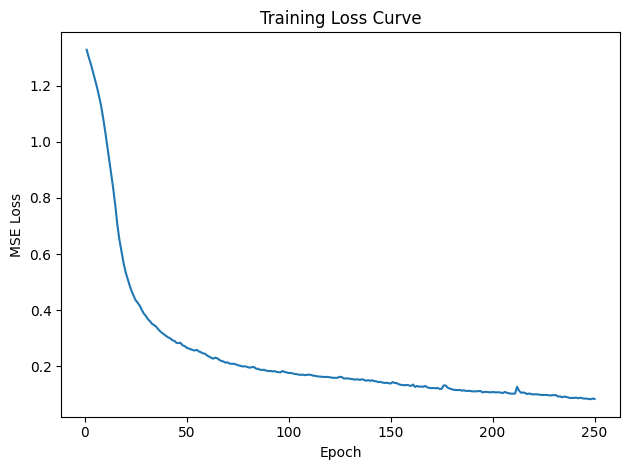

Fold 1 Training R²: 0.9294, Pearson r: 0.9658


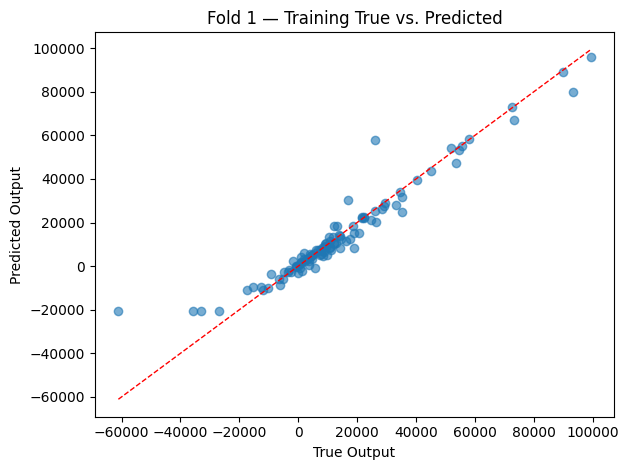

Fold 1 Validation MSE (norm): 0.1296
Fold 1 Validation R²: 0.3520, Pearson r: 0.7402


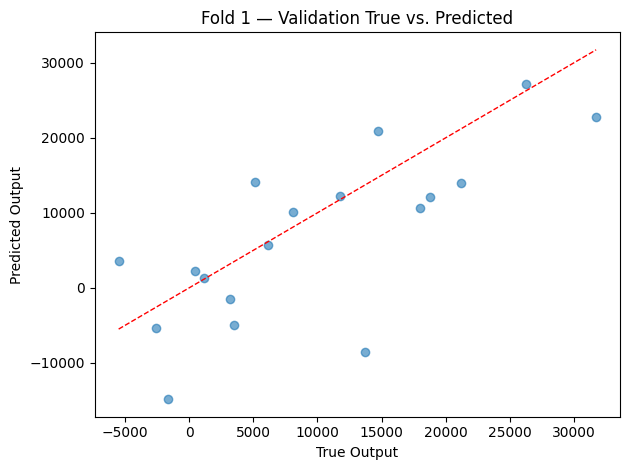


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9135
Epoch  10/250  MSE=0.7021
Epoch  20/250  MSE=0.5169
Epoch  30/250  MSE=0.4315
Epoch  40/250  MSE=0.3793
Epoch  50/250  MSE=0.3411
Epoch  60/250  MSE=0.3069
Epoch  70/250  MSE=0.2755
Epoch  80/250  MSE=0.2508
Epoch  90/250  MSE=0.2295
Epoch 100/250  MSE=0.2162
Epoch 110/250  MSE=0.2042
Epoch 120/250  MSE=0.1962
Epoch 130/250  MSE=0.1769
Epoch 140/250  MSE=0.1661
Epoch 150/250  MSE=0.1580
Epoch 160/250  MSE=0.1526
Epoch 170/250  MSE=0.1461
Epoch 180/250  MSE=0.1121
Epoch 190/250  MSE=0.1020
Epoch 200/250  MSE=0.0953
Epoch 210/250  MSE=0.0911
Epoch 220/250  MSE=0.0862
Epoch 230/250  MSE=0.0839
Epoch 240/250  MSE=0.0814
Epoch 250/250  MSE=0.0779


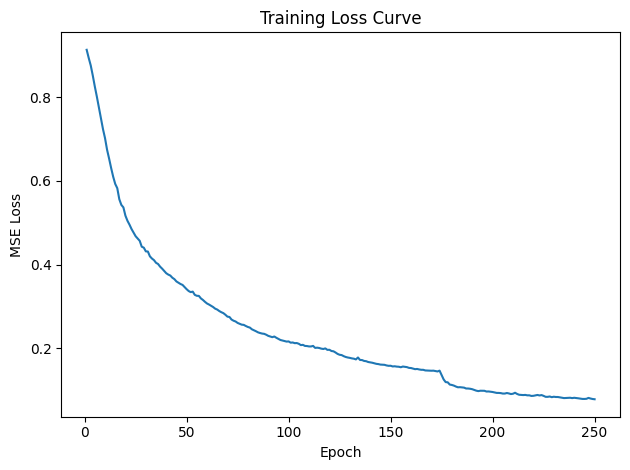

Fold 2 Training R²: 0.9162, Pearson r: 0.9597


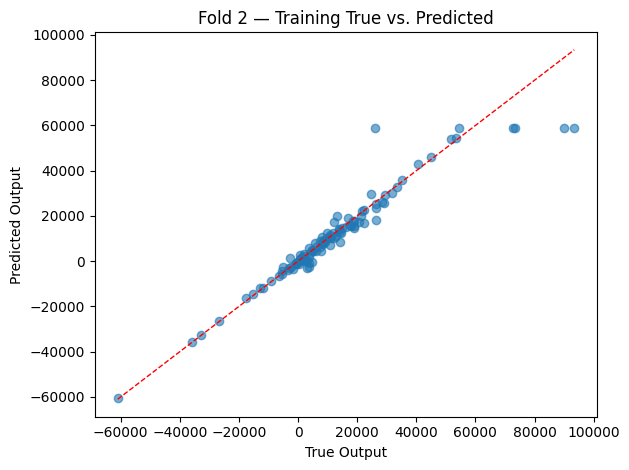

Fold 2 Validation MSE (norm): 0.3386
Fold 2 Validation R²: 0.7555, Pearson r: 0.8859


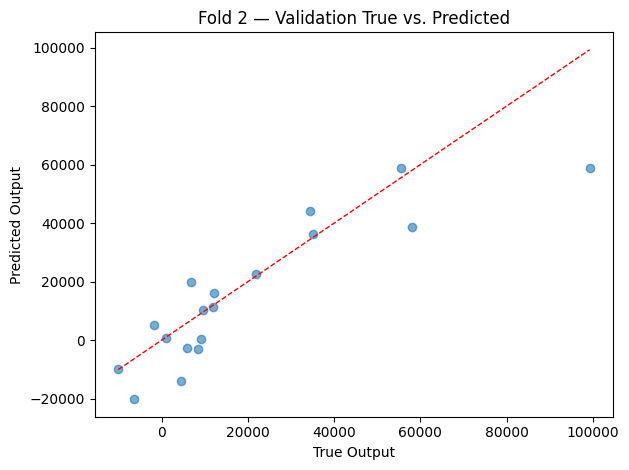


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0486
Epoch  10/250  MSE=0.8350
Epoch  20/250  MSE=0.4321
Epoch  30/250  MSE=0.2193
Epoch  40/250  MSE=0.1638
Epoch  50/250  MSE=0.1429
Epoch  60/250  MSE=0.1271
Epoch  70/250  MSE=0.1166
Epoch  80/250  MSE=0.1122
Epoch  90/250  MSE=0.1033
Epoch 100/250  MSE=0.1010
Epoch 110/250  MSE=0.0952
Epoch 120/250  MSE=0.0899
Epoch 130/250  MSE=0.0857
Epoch 140/250  MSE=0.0839
Epoch 150/250  MSE=0.0792
Epoch 160/250  MSE=0.0776
Epoch 170/250  MSE=0.0751
Epoch 180/250  MSE=0.0719
Epoch 190/250  MSE=0.0704
Epoch 200/250  MSE=0.0684
Epoch 210/250  MSE=0.0665
Epoch 220/250  MSE=0.0651
Epoch 230/250  MSE=0.0645
Epoch 240/250  MSE=0.0627
Epoch 250/250  MSE=0.0633


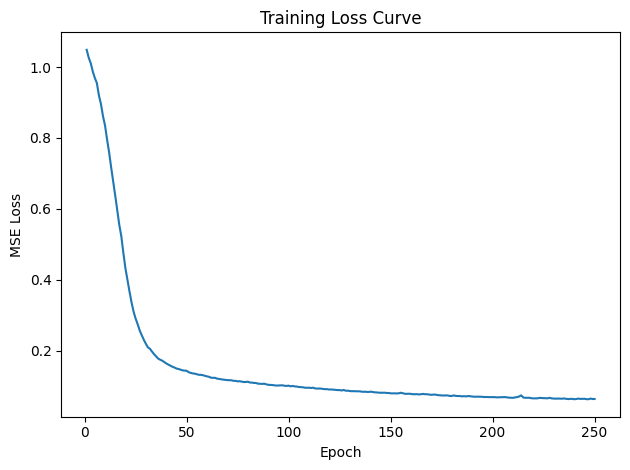

Fold 3 Training R²: 0.9401, Pearson r: 0.9699


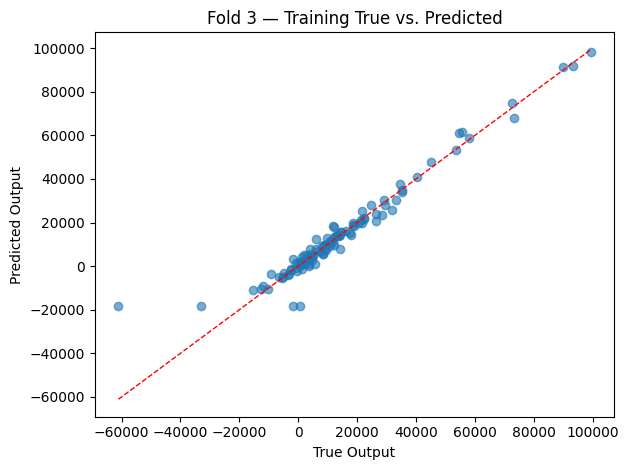

Fold 3 Validation MSE (norm): 0.4115
Fold 3 Validation R²: 0.4324, Pearson r: 0.8238


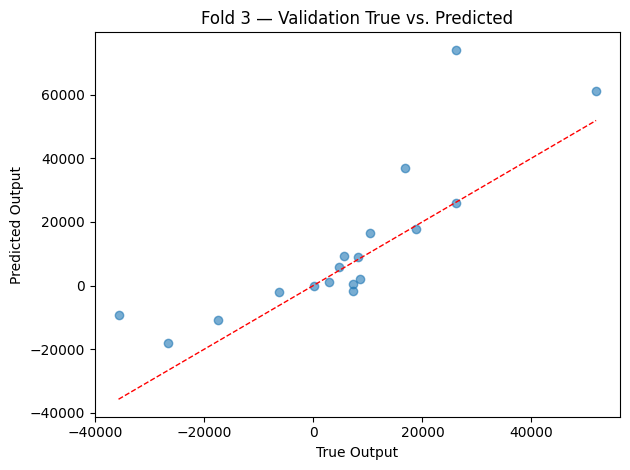


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8217
Epoch  10/250  MSE=0.5625
Epoch  20/250  MSE=0.3961
Epoch  30/250  MSE=0.3090
Epoch  40/250  MSE=0.2517
Epoch  50/250  MSE=0.2140
Epoch  60/250  MSE=0.1873
Epoch  70/250  MSE=0.1667
Epoch  80/250  MSE=0.1487
Epoch  90/250  MSE=0.1362
Epoch 100/250  MSE=0.1247
Epoch 110/250  MSE=0.1175
Epoch 120/250  MSE=0.1104
Epoch 130/250  MSE=0.1054
Epoch 140/250  MSE=0.1006
Epoch 150/250  MSE=0.0935
Epoch 160/250  MSE=0.0884
Epoch 170/250  MSE=0.0847
Epoch 180/250  MSE=0.0649
Epoch 190/250  MSE=0.0478
Epoch 200/250  MSE=0.0386
Epoch 210/250  MSE=0.0358
Epoch 220/250  MSE=0.0307
Epoch 230/250  MSE=0.0296
Epoch 240/250  MSE=0.0271
Epoch 250/250  MSE=0.0266


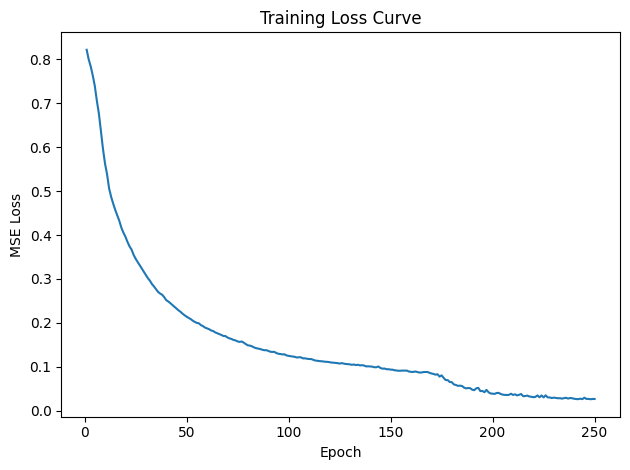

Fold 4 Training R²: 0.9700, Pearson r: 0.9850


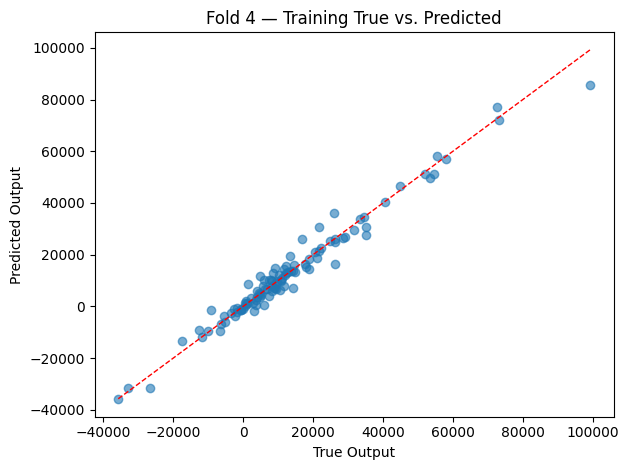

Fold 4 Validation MSE (norm): 1.0895
Fold 4 Validation R²: 0.4985, Pearson r: 0.7177


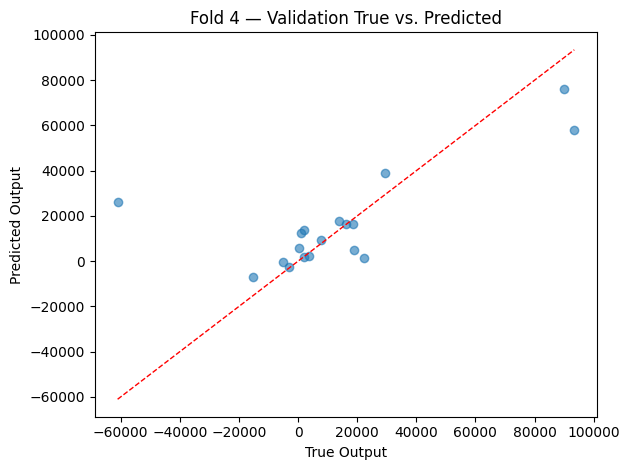


=== Fold 5/7 ===
Epoch   1/250  MSE=1.2164
Epoch  10/250  MSE=0.9610
Epoch  20/250  MSE=0.6822
Epoch  30/250  MSE=0.5613
Epoch  40/250  MSE=0.4868
Epoch  50/250  MSE=0.4147
Epoch  60/250  MSE=0.3554
Epoch  70/250  MSE=0.3159
Epoch  80/250  MSE=0.2798
Epoch  90/250  MSE=0.2502
Epoch 100/250  MSE=0.2247
Epoch 110/250  MSE=0.2022
Epoch 120/250  MSE=0.1850
Epoch 130/250  MSE=0.1700
Epoch 140/250  MSE=0.1589
Epoch 150/250  MSE=0.1482
Epoch 160/250  MSE=0.1389
Epoch 170/250  MSE=0.1309
Epoch 180/250  MSE=0.1271
Epoch 190/250  MSE=0.1158
Epoch 200/250  MSE=0.1123
Epoch 210/250  MSE=0.1062
Epoch 220/250  MSE=0.0967
Epoch 230/250  MSE=0.0873
Epoch 240/250  MSE=0.0822
Epoch 250/250  MSE=0.0762


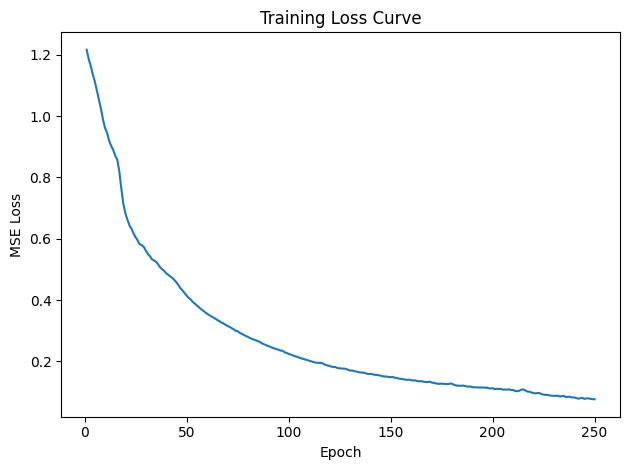

Fold 5 Training R²: 0.9298, Pearson r: 0.9695


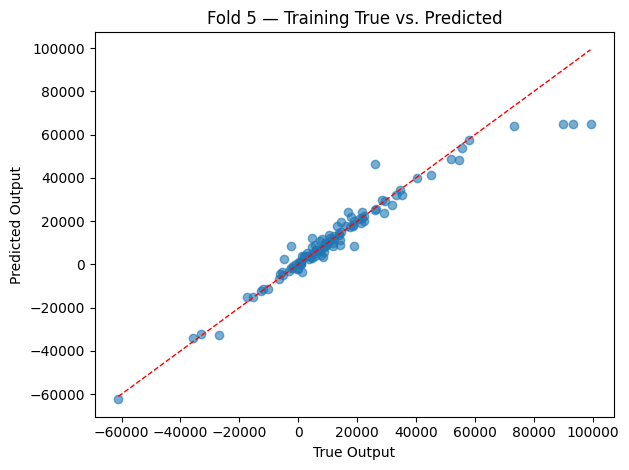

Fold 5 Validation MSE (norm): 0.3350
Fold 5 Validation R²: 0.5733, Pearson r: 0.7780


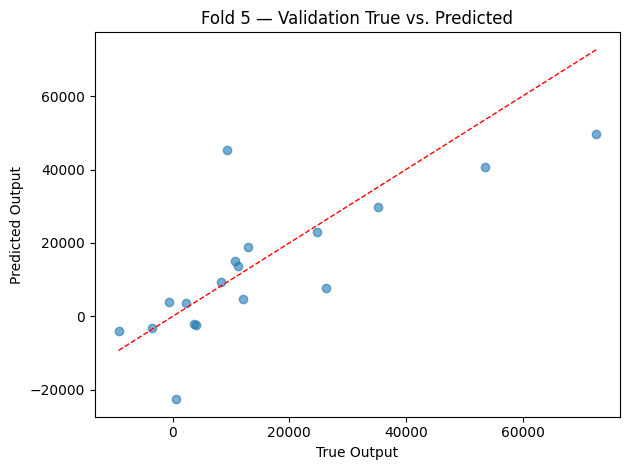


=== Fold 6/7 ===
Epoch   1/250  MSE=1.0839
Epoch  10/250  MSE=0.6011
Epoch  20/250  MSE=0.2075
Epoch  30/250  MSE=0.1209
Epoch  40/250  MSE=0.0943
Epoch  50/250  MSE=0.0719
Epoch  60/250  MSE=0.0629
Epoch  70/250  MSE=0.0561
Epoch  80/250  MSE=0.0489
Epoch  90/250  MSE=0.0459
Epoch 100/250  MSE=0.0407
Epoch 110/250  MSE=0.0372
Epoch 120/250  MSE=0.0356
Epoch 130/250  MSE=0.0352
Epoch 140/250  MSE=0.0323
Epoch 150/250  MSE=0.0309
Epoch 160/250  MSE=0.0315
Epoch 170/250  MSE=0.0298
Epoch 180/250  MSE=0.0279
Epoch 190/250  MSE=0.0278
Epoch 200/250  MSE=0.0269
Epoch 210/250  MSE=0.0283
Epoch 220/250  MSE=0.0254
Epoch 230/250  MSE=0.0253
Epoch 240/250  MSE=0.0266
Epoch 250/250  MSE=0.0252


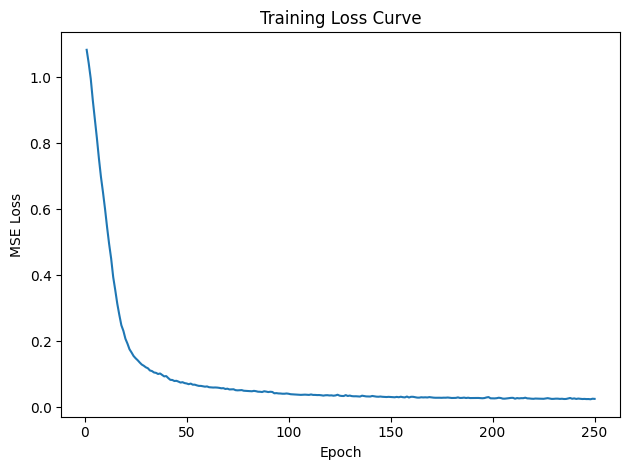

Fold 6 Training R²: 0.9760, Pearson r: 0.9883


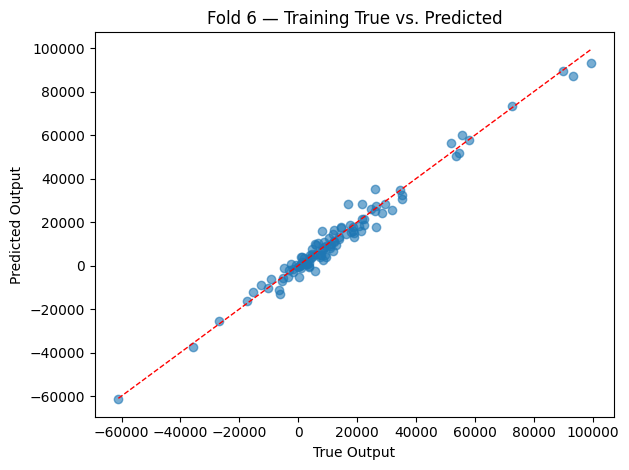

Fold 6 Validation MSE (norm): 0.6833
Fold 6 Validation R²: 0.3606, Pearson r: 0.6499


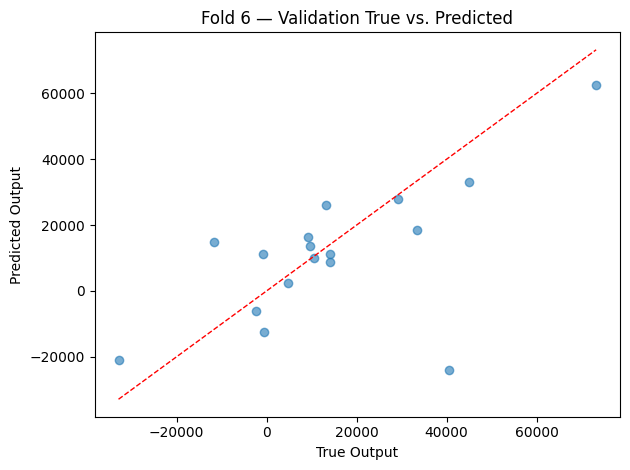


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1390
Epoch  10/250  MSE=1.1056
Epoch  20/250  MSE=1.0971
Epoch  30/250  MSE=1.0947
Epoch  40/250  MSE=1.0924
Epoch  50/250  MSE=1.0923
Epoch  60/250  MSE=1.0927
Epoch  70/250  MSE=1.0923
Epoch  80/250  MSE=1.0934
Epoch  90/250  MSE=1.0923
Epoch 100/250  MSE=1.0922
Epoch 110/250  MSE=1.0922
Epoch 120/250  MSE=1.0921
Epoch 130/250  MSE=1.0929
Epoch 140/250  MSE=1.0928
Epoch 150/250  MSE=1.0924
Epoch 160/250  MSE=1.0922
Epoch 170/250  MSE=1.0922
Epoch 180/250  MSE=0.8689
Epoch 190/250  MSE=0.6294
Epoch 200/250  MSE=0.5261
Epoch 210/250  MSE=0.4588
Epoch 220/250  MSE=0.4052
Epoch 230/250  MSE=0.3653
Epoch 240/250  MSE=0.3255
Epoch 250/250  MSE=0.2961


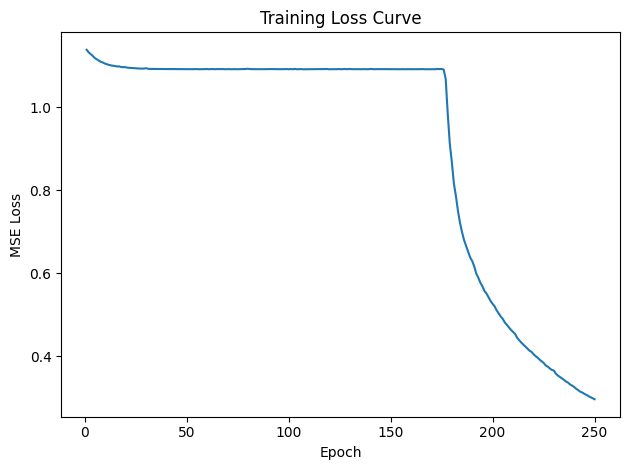

Fold 7 Training R²: 0.7308, Pearson r: 0.8809


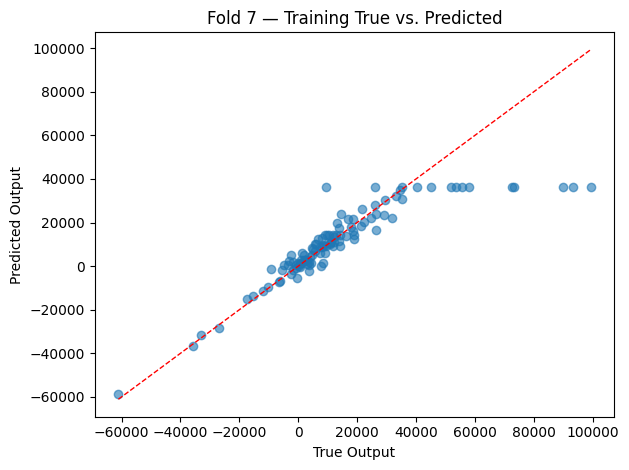

Fold 7 Validation MSE (norm): 0.1437
Fold 7 Validation R²: 0.6575, Pearson r: 0.8109


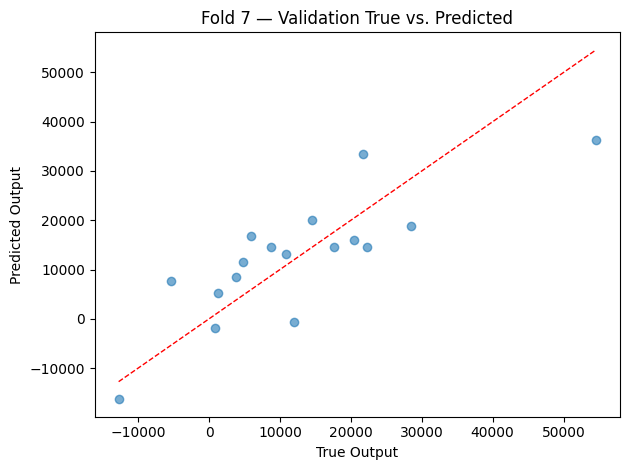


=== Validation MSE per fold ===
['0.1296', '0.3386', '0.4115', '1.0895', '0.3350', '0.6833', '0.1437']
Mean MSE (norm): 0.4473 ± 0.3133

=== Validation R² per fold ===
['0.3520', '0.7555', '0.4324', '0.4985', '0.5733', '0.3606', '0.6575']
Mean R²: 0.5185 ± 0.1409

=== Validation Pearson r per fold ===
['0.7402', '0.8859', '0.8238', '0.7177', '0.7780', '0.6499', '0.8109']
Mean Pearson r: 0.7724 ± 0.0718


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [36]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [3, 3],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")
'''
'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [4,4] Relu



=== Fold 1/7 ===
Epoch   1/250  MSE=1.2204
Epoch  10/250  MSE=1.0072
Epoch  20/250  MSE=0.8545
Epoch  30/250  MSE=0.7182
Epoch  40/250  MSE=0.6113
Epoch  50/250  MSE=0.5342
Epoch  60/250  MSE=0.2094
Epoch  70/250  MSE=0.1616
Epoch  80/250  MSE=0.1318
Epoch  90/250  MSE=0.1135
Epoch 100/250  MSE=0.1056
Epoch 110/250  MSE=0.1027
Epoch 120/250  MSE=0.0958
Epoch 130/250  MSE=0.0940
Epoch 140/250  MSE=0.0897
Epoch 150/250  MSE=0.0885
Epoch 160/250  MSE=0.0837
Epoch 170/250  MSE=0.0819
Epoch 180/250  MSE=0.0787
Epoch 190/250  MSE=0.0751
Epoch 200/250  MSE=0.0733
Epoch 210/250  MSE=0.0714
Epoch 220/250  MSE=0.0655
Epoch 230/250  MSE=0.0609
Epoch 240/250  MSE=0.0589
Epoch 250/250  MSE=0.0551


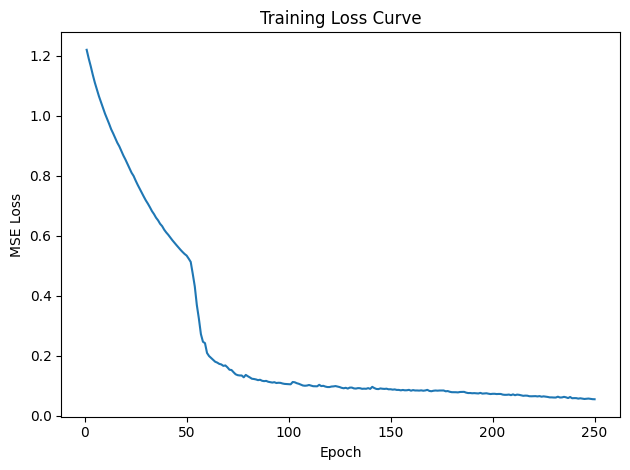

Fold 1 Training R²: 0.9521, Pearson r: 0.9758


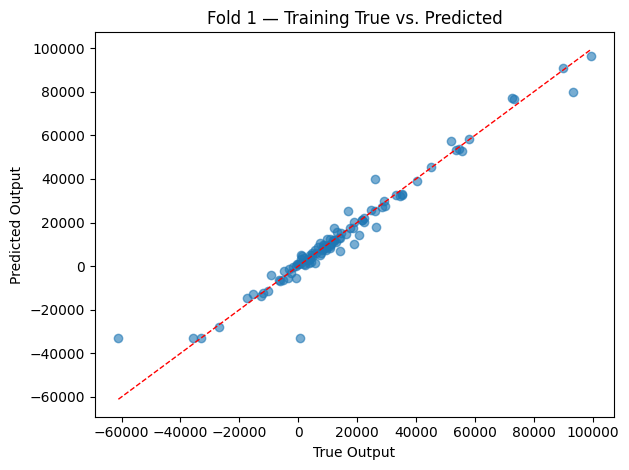

Fold 1 Validation MSE (norm): 0.2571
Fold 1 Validation R²: -0.2857, Pearson r: 0.7874


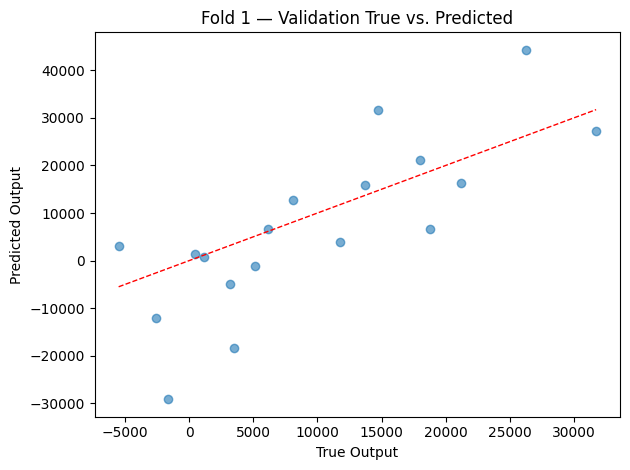


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9265
Epoch  10/250  MSE=0.7244
Epoch  20/250  MSE=0.3809
Epoch  30/250  MSE=0.2671
Epoch  40/250  MSE=0.2196
Epoch  50/250  MSE=0.1891
Epoch  60/250  MSE=0.1750
Epoch  70/250  MSE=0.1556
Epoch  80/250  MSE=0.1435
Epoch  90/250  MSE=0.1276
Epoch 100/250  MSE=0.1164
Epoch 110/250  MSE=0.1071
Epoch 120/250  MSE=0.0989
Epoch 130/250  MSE=0.0913
Epoch 140/250  MSE=0.0850
Epoch 150/250  MSE=0.0770
Epoch 160/250  MSE=0.0714
Epoch 170/250  MSE=0.0690
Epoch 180/250  MSE=0.0647
Epoch 190/250  MSE=0.0623
Epoch 200/250  MSE=0.0598
Epoch 210/250  MSE=0.0563
Epoch 220/250  MSE=0.0425
Epoch 230/250  MSE=0.0394
Epoch 240/250  MSE=0.0357
Epoch 250/250  MSE=0.0327


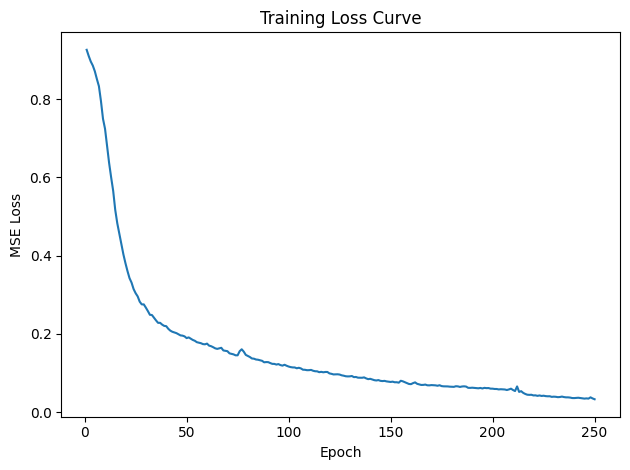

Fold 2 Training R²: 0.9650, Pearson r: 0.9836


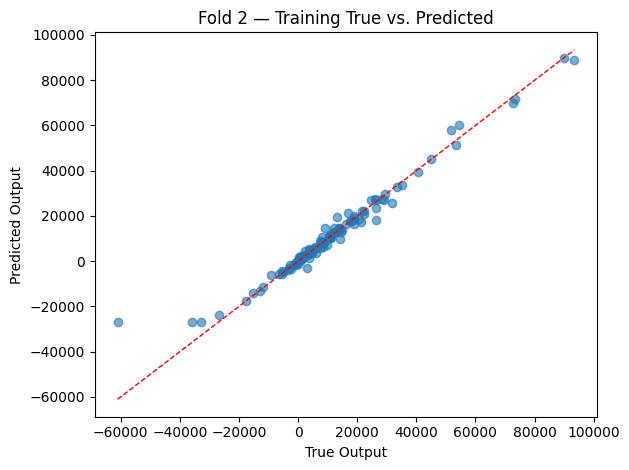

Fold 2 Validation MSE (norm): 0.4353
Fold 2 Validation R²: 0.6857, Pearson r: 0.8414


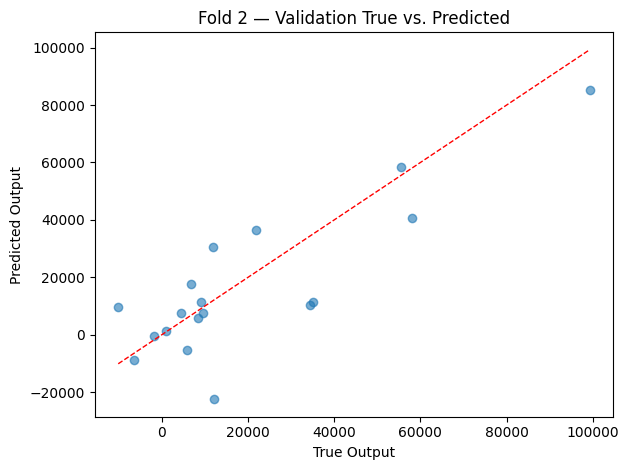


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0598
Epoch  10/250  MSE=0.9359
Epoch  20/250  MSE=0.6399
Epoch  30/250  MSE=0.3841
Epoch  40/250  MSE=0.2479
Epoch  50/250  MSE=0.1605
Epoch  60/250  MSE=0.1113
Epoch  70/250  MSE=0.0755
Epoch  80/250  MSE=0.0586
Epoch  90/250  MSE=0.0442
Epoch 100/250  MSE=0.0346
Epoch 110/250  MSE=0.0307
Epoch 120/250  MSE=0.0225
Epoch 130/250  MSE=0.0210
Epoch 140/250  MSE=0.0167
Epoch 150/250  MSE=0.0157
Epoch 160/250  MSE=0.0203
Epoch 170/250  MSE=0.0133
Epoch 180/250  MSE=0.0131
Epoch 190/250  MSE=0.0154
Epoch 200/250  MSE=0.0129
Epoch 210/250  MSE=0.0105
Epoch 220/250  MSE=0.0101
Epoch 230/250  MSE=0.0096
Epoch 240/250  MSE=0.0094
Epoch 250/250  MSE=0.0111


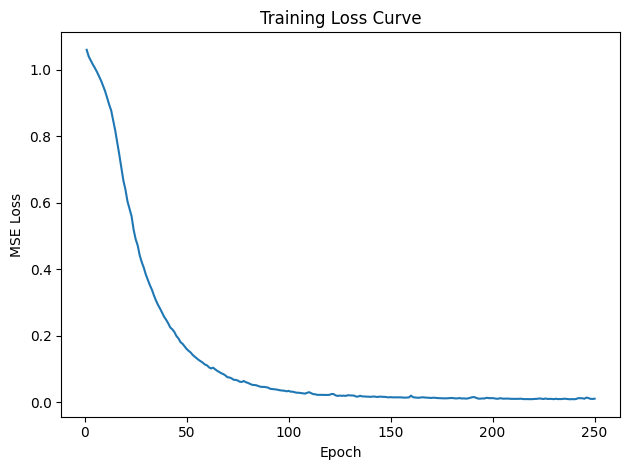

Fold 3 Training R²: 0.9901, Pearson r: 0.9954


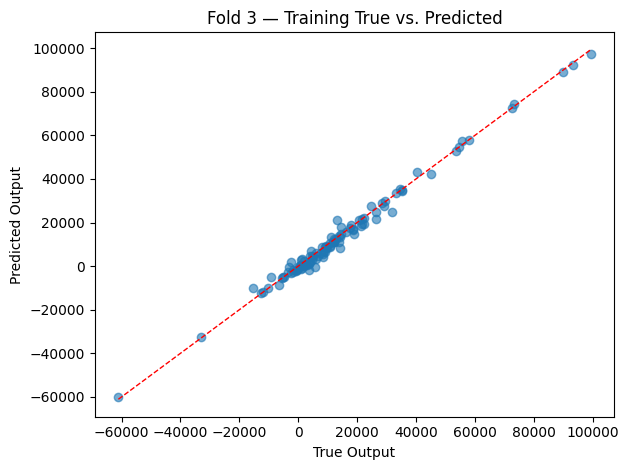

Fold 3 Validation MSE (norm): 0.2411
Fold 3 Validation R²: 0.6674, Pearson r: 0.8756


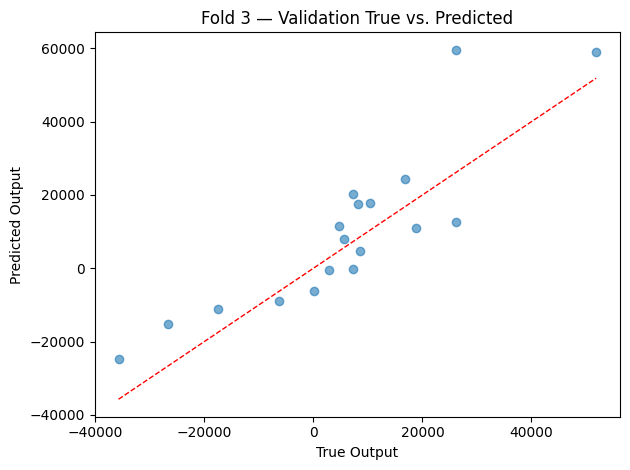


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8203
Epoch  10/250  MSE=0.6829
Epoch  20/250  MSE=0.2416
Epoch  30/250  MSE=0.0845
Epoch  40/250  MSE=0.0581
Epoch  50/250  MSE=0.0480
Epoch  60/250  MSE=0.0428
Epoch  70/250  MSE=0.0365
Epoch  80/250  MSE=0.0339
Epoch  90/250  MSE=0.0307
Epoch 100/250  MSE=0.0277
Epoch 110/250  MSE=0.0249
Epoch 120/250  MSE=0.0226
Epoch 130/250  MSE=0.0216
Epoch 140/250  MSE=0.0197
Epoch 150/250  MSE=0.0190
Epoch 160/250  MSE=0.0185
Epoch 170/250  MSE=0.0180
Epoch 180/250  MSE=0.0215
Epoch 190/250  MSE=0.0173
Epoch 200/250  MSE=0.0160
Epoch 210/250  MSE=0.0196
Epoch 220/250  MSE=0.0183
Epoch 230/250  MSE=0.0159
Epoch 240/250  MSE=0.0163
Epoch 250/250  MSE=0.0138


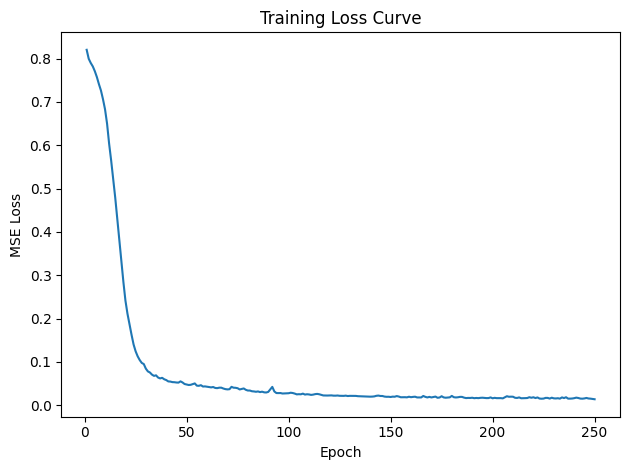

Fold 4 Training R²: 0.9836, Pearson r: 0.9918


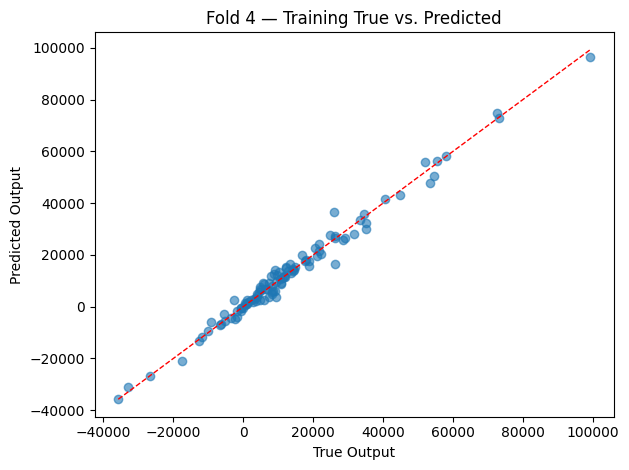

Fold 4 Validation MSE (norm): 1.1707
Fold 4 Validation R²: 0.4611, Pearson r: 0.6870


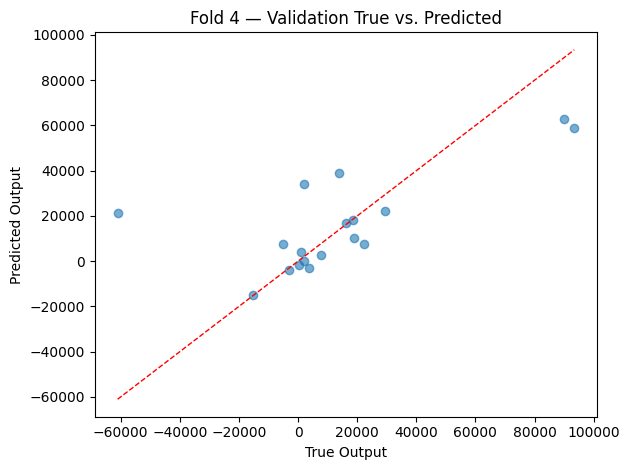


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0852
Epoch  10/250  MSE=0.9562
Epoch  20/250  MSE=0.6642
Epoch  30/250  MSE=0.4179
Epoch  40/250  MSE=0.2651
Epoch  50/250  MSE=0.1892
Epoch  60/250  MSE=0.1444
Epoch  70/250  MSE=0.1226
Epoch  80/250  MSE=0.0943
Epoch  90/250  MSE=0.0758
Epoch 100/250  MSE=0.0621
Epoch 110/250  MSE=0.0513
Epoch 120/250  MSE=0.0485
Epoch 130/250  MSE=0.0419
Epoch 140/250  MSE=0.0391
Epoch 150/250  MSE=0.0426
Epoch 160/250  MSE=0.0323
Epoch 170/250  MSE=0.0328
Epoch 180/250  MSE=0.0306
Epoch 190/250  MSE=0.0290
Epoch 200/250  MSE=0.0297
Epoch 210/250  MSE=0.0305
Epoch 220/250  MSE=0.0290
Epoch 230/250  MSE=0.0269
Epoch 240/250  MSE=0.0313
Epoch 250/250  MSE=0.0265


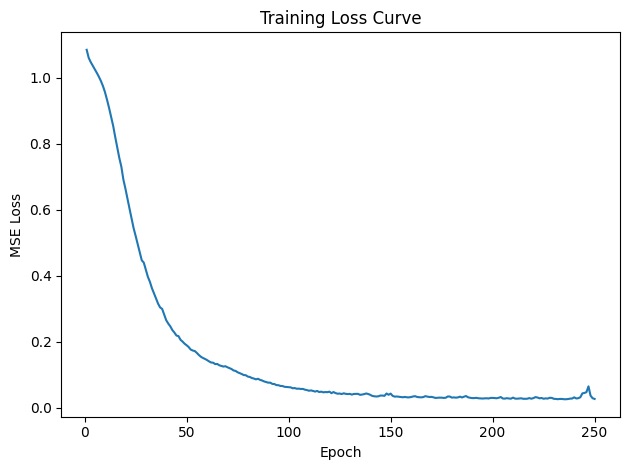

Fold 5 Training R²: 0.9739, Pearson r: 0.9884


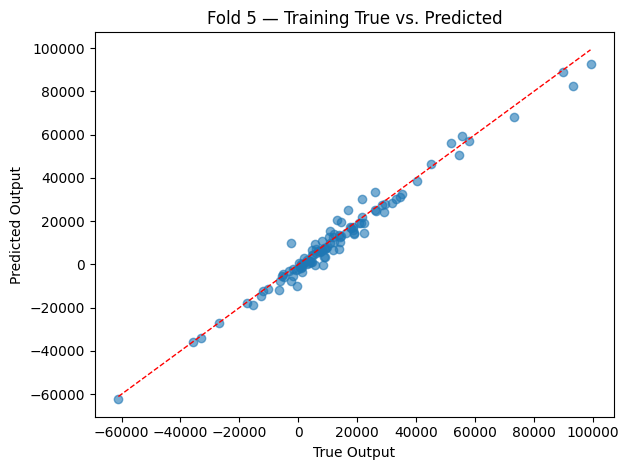

Fold 5 Validation MSE (norm): 0.4315
Fold 5 Validation R²: 0.4504, Pearson r: 0.8193


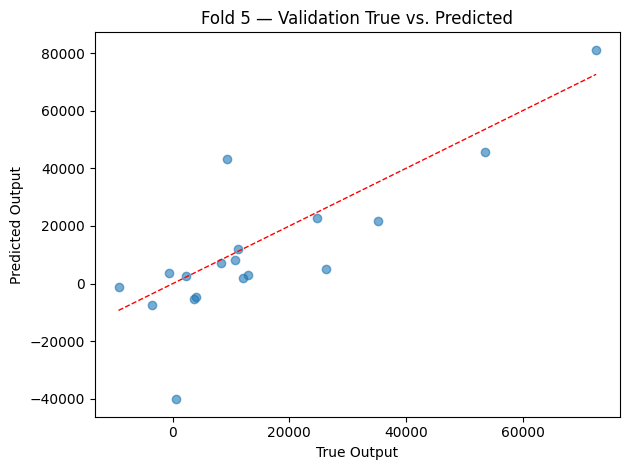


=== Fold 6/7 ===
Epoch   1/250  MSE=1.2824
Epoch  10/250  MSE=0.8562
Epoch  20/250  MSE=0.4582
Epoch  30/250  MSE=0.3372
Epoch  40/250  MSE=0.2825
Epoch  50/250  MSE=0.2531
Epoch  60/250  MSE=0.2311
Epoch  70/250  MSE=0.2102
Epoch  80/250  MSE=0.1848
Epoch  90/250  MSE=0.1631
Epoch 100/250  MSE=0.1542
Epoch 110/250  MSE=0.1349
Epoch 120/250  MSE=0.1233
Epoch 130/250  MSE=0.1203
Epoch 140/250  MSE=0.1063
Epoch 150/250  MSE=0.1006
Epoch 160/250  MSE=0.0959
Epoch 170/250  MSE=0.0898
Epoch 180/250  MSE=0.0895
Epoch 190/250  MSE=0.0845
Epoch 200/250  MSE=0.0818
Epoch 210/250  MSE=0.0876
Epoch 220/250  MSE=0.0747
Epoch 230/250  MSE=0.0721
Epoch 240/250  MSE=0.0759
Epoch 250/250  MSE=0.0666


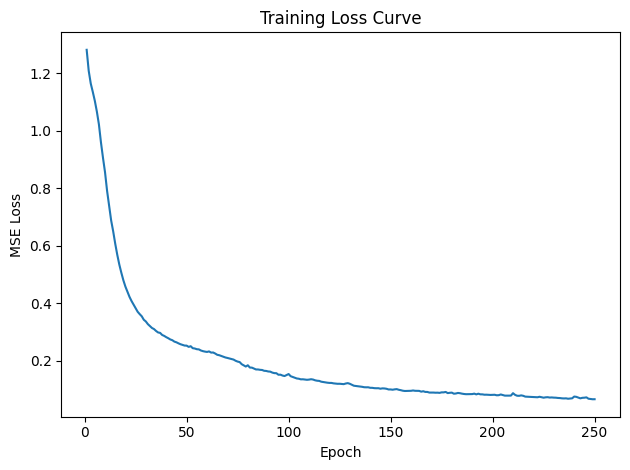

Fold 6 Training R²: 0.9343, Pearson r: 0.9672


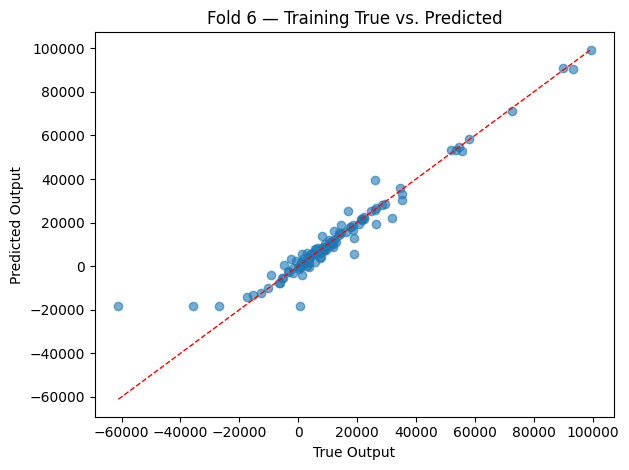

Fold 6 Validation MSE (norm): 0.6451
Fold 6 Validation R²: 0.3964, Pearson r: 0.6814


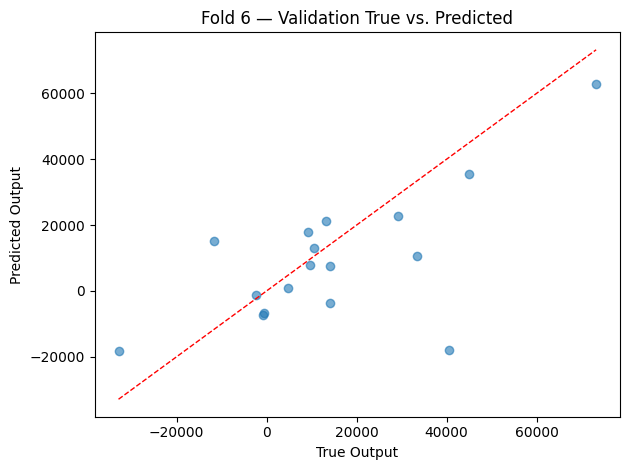


=== Fold 7/7 ===
Epoch   1/250  MSE=1.0998
Epoch  10/250  MSE=0.9081
Epoch  20/250  MSE=0.1889
Epoch  30/250  MSE=0.0966
Epoch  40/250  MSE=0.0732
Epoch  50/250  MSE=0.0574
Epoch  60/250  MSE=0.0505
Epoch  70/250  MSE=0.0487
Epoch  80/250  MSE=0.0438
Epoch  90/250  MSE=0.0402
Epoch 100/250  MSE=0.0398
Epoch 110/250  MSE=0.0363
Epoch 120/250  MSE=0.0351
Epoch 130/250  MSE=0.0354
Epoch 140/250  MSE=0.0316
Epoch 150/250  MSE=0.0319
Epoch 160/250  MSE=0.0294
Epoch 170/250  MSE=0.0285
Epoch 180/250  MSE=0.0288
Epoch 190/250  MSE=0.0313
Epoch 200/250  MSE=0.0261
Epoch 210/250  MSE=0.0277
Epoch 220/250  MSE=0.0261
Epoch 230/250  MSE=0.0267
Epoch 240/250  MSE=0.0240
Epoch 250/250  MSE=0.0230


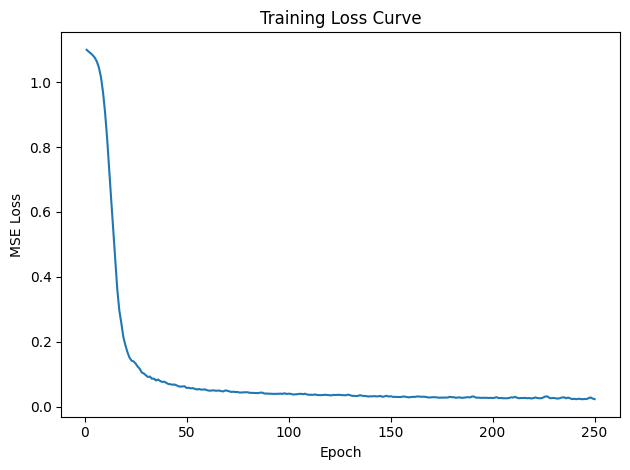

Fold 7 Training R²: 0.9807, Pearson r: 0.9904


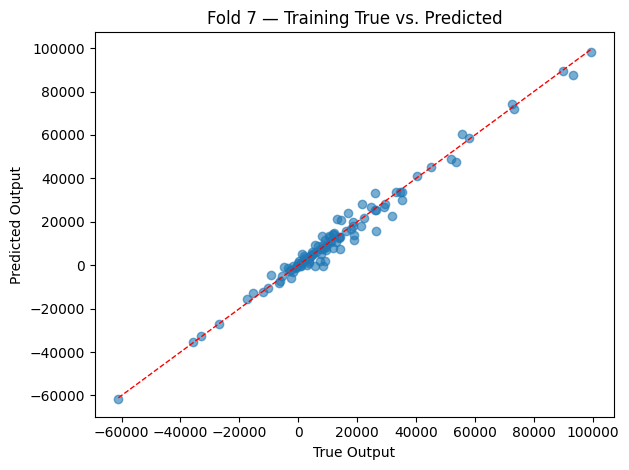

Fold 7 Validation MSE (norm): 0.1930
Fold 7 Validation R²: 0.5401, Pearson r: 0.8240


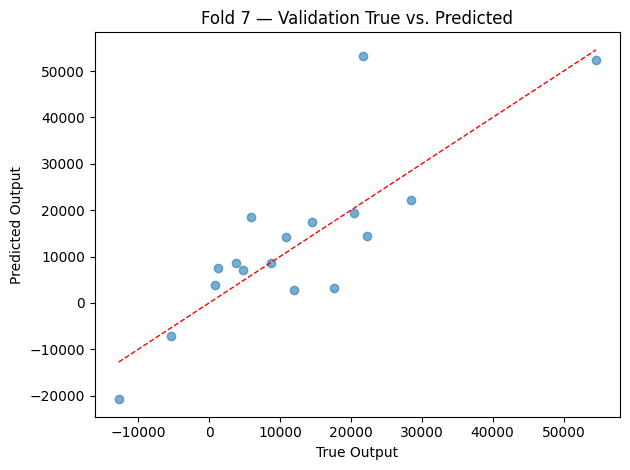


=== Validation MSE per fold ===
['0.2571', '0.4353', '0.2411', '1.1707', '0.4315', '0.6451', '0.1930']
Mean MSE (norm): 0.4820 ± 0.3157

=== Validation R² per fold ===
['-0.2857', '0.6857', '0.6674', '0.4611', '0.4504', '0.3964', '0.5401']
Mean R²: 0.4165 ± 0.3041

=== Validation Pearson r per fold ===
['0.7874', '0.8414', '0.8756', '0.6870', '0.8193', '0.6814', '0.8240']
Mean Pearson r: 0.7880 ± 0.0701


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [43]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [4, 4],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")
'''
'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [8, 8] ReLU 


=== Fold 1/7 ===
Epoch   1/250  MSE=1.1172
Epoch  10/250  MSE=0.6876
Epoch  20/250  MSE=0.5224
Epoch  30/250  MSE=0.4368
Epoch  40/250  MSE=0.3736
Epoch  50/250  MSE=0.3196
Epoch  60/250  MSE=0.2795
Epoch  70/250  MSE=0.2486
Epoch  80/250  MSE=0.2178
Epoch  90/250  MSE=0.1935
Epoch 100/250  MSE=0.1730
Epoch 110/250  MSE=0.1562
Epoch 120/250  MSE=0.1422
Epoch 130/250  MSE=0.1316
Epoch 140/250  MSE=0.1234
Epoch 150/250  MSE=0.1193
Epoch 160/250  MSE=0.1087
Epoch 170/250  MSE=0.1011
Epoch 180/250  MSE=0.1062
Epoch 190/250  MSE=0.0879
Epoch 200/250  MSE=0.0865
Epoch 210/250  MSE=0.0732
Epoch 220/250  MSE=0.0707
Epoch 230/250  MSE=0.0611
Epoch 240/250  MSE=0.0550
Epoch 250/250  MSE=0.0527


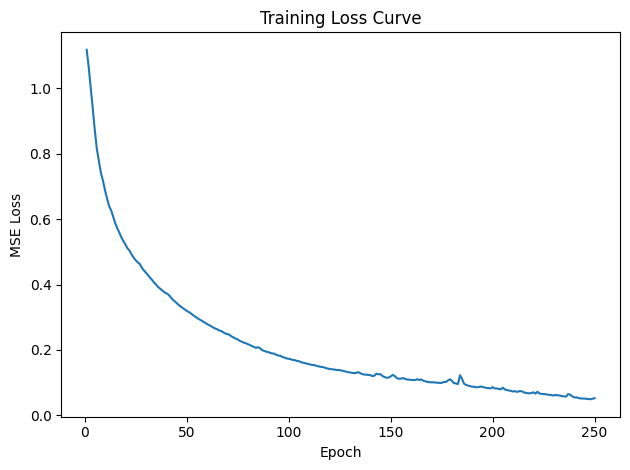

Fold 1 Training R²: 0.9578, Pearson r: 0.9811


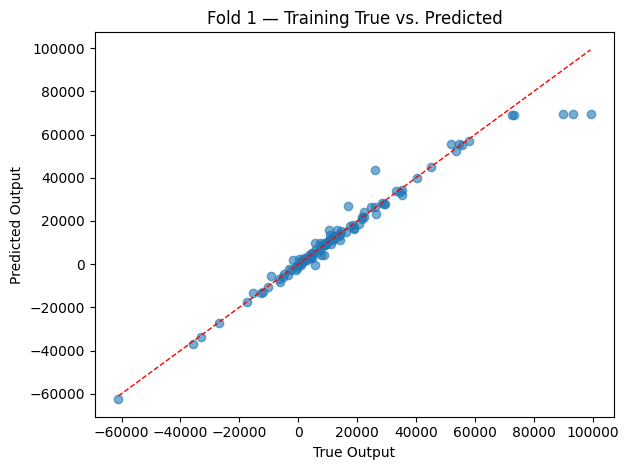

Fold 1 Validation MSE (norm): 0.2150
Fold 1 Validation R²: -0.0751, Pearson r: 0.5750


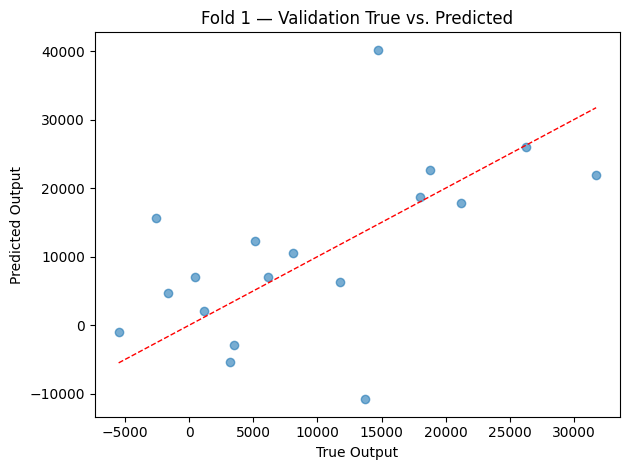


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9274
Epoch  10/250  MSE=0.4323
Epoch  20/250  MSE=0.0975
Epoch  30/250  MSE=0.0568
Epoch  40/250  MSE=0.0391
Epoch  50/250  MSE=0.0287
Epoch  60/250  MSE=0.0221
Epoch  70/250  MSE=0.0203
Epoch  80/250  MSE=0.0168
Epoch  90/250  MSE=0.0117
Epoch 100/250  MSE=0.0107
Epoch 110/250  MSE=0.0146
Epoch 120/250  MSE=0.0081
Epoch 130/250  MSE=0.0079
Epoch 140/250  MSE=0.0084
Epoch 150/250  MSE=0.0066
Epoch 160/250  MSE=0.0078
Epoch 170/250  MSE=0.0080
Epoch 180/250  MSE=0.0065
Epoch 190/250  MSE=0.0062
Epoch 200/250  MSE=0.0062
Epoch 210/250  MSE=0.0088
Epoch 220/250  MSE=0.0040
Epoch 230/250  MSE=0.0044
Epoch 240/250  MSE=0.0081
Epoch 250/250  MSE=0.0045


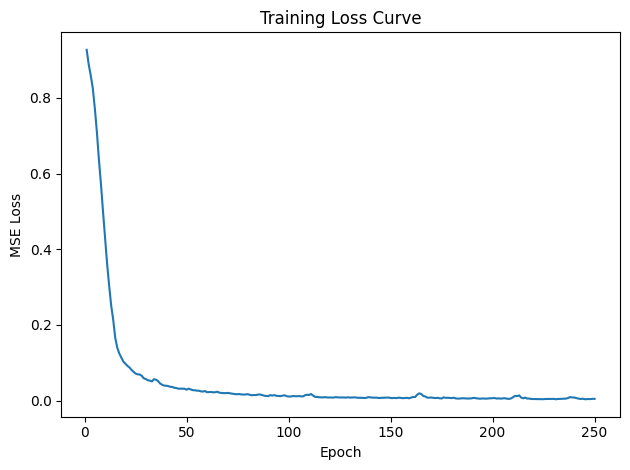

Fold 2 Training R²: 0.9964, Pearson r: 0.9983


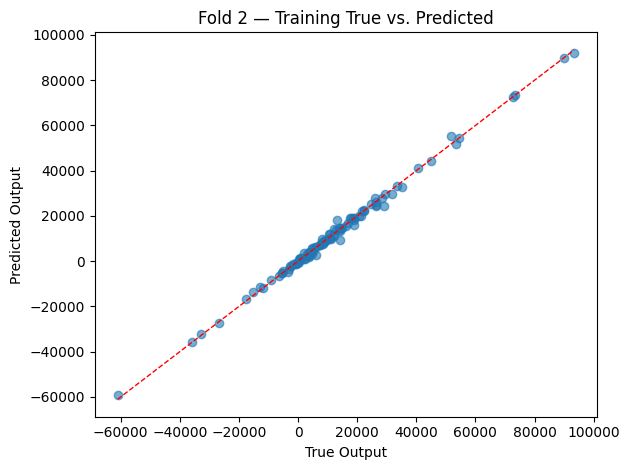

Fold 2 Validation MSE (norm): 0.4469
Fold 2 Validation R²: 0.6774, Pearson r: 0.8385


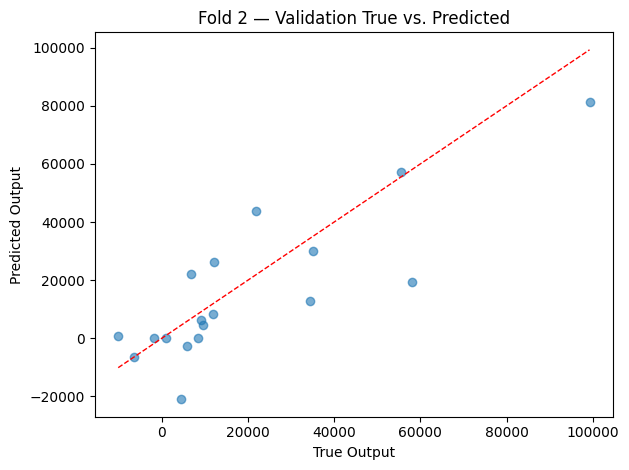


=== Fold 3/7 ===
Epoch   1/250  MSE=1.1280
Epoch  10/250  MSE=0.9092
Epoch  20/250  MSE=0.1827
Epoch  30/250  MSE=0.0651
Epoch  40/250  MSE=0.0500
Epoch  50/250  MSE=0.0267
Epoch  60/250  MSE=0.0275
Epoch  70/250  MSE=0.0209
Epoch  80/250  MSE=0.0189
Epoch  90/250  MSE=0.0188
Epoch 100/250  MSE=0.0185
Epoch 110/250  MSE=0.0187
Epoch 120/250  MSE=0.0183
Epoch 130/250  MSE=0.0189
Epoch 140/250  MSE=0.0146
Epoch 150/250  MSE=0.0186
Epoch 160/250  MSE=0.0128
Epoch 170/250  MSE=0.0145
Epoch 180/250  MSE=0.0130
Epoch 190/250  MSE=0.0116
Epoch 200/250  MSE=0.0167
Epoch 210/250  MSE=0.0117
Epoch 220/250  MSE=0.0111
Epoch 230/250  MSE=0.0163
Epoch 240/250  MSE=0.0110
Epoch 250/250  MSE=0.0124


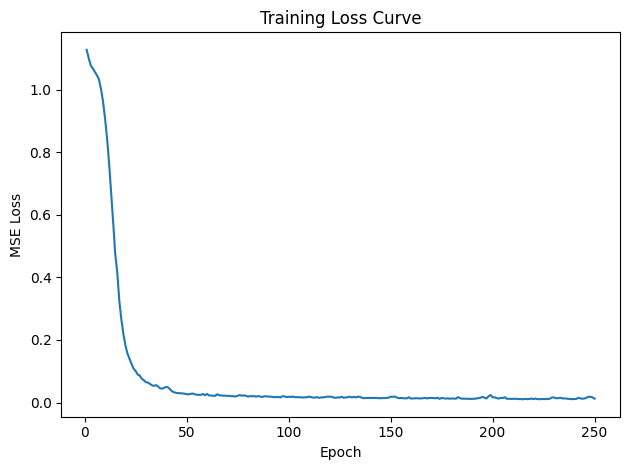

Fold 3 Training R²: 0.9904, Pearson r: 0.9953


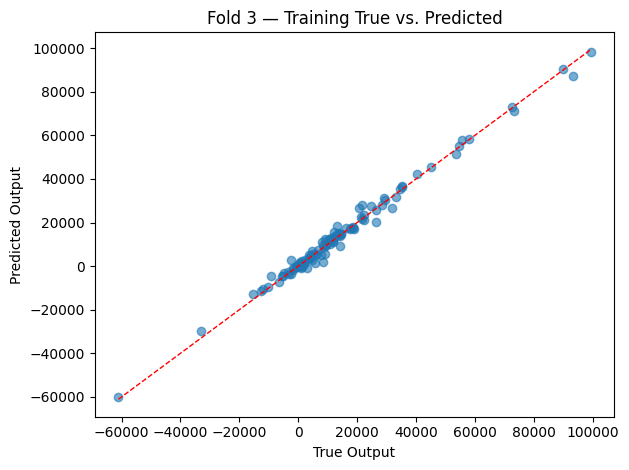

Fold 3 Validation MSE (norm): 0.3259
Fold 3 Validation R²: 0.5504, Pearson r: 0.8838


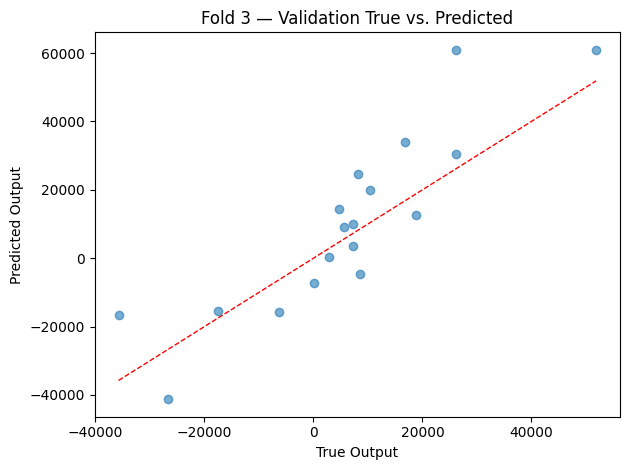


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8348
Epoch  10/250  MSE=0.3826
Epoch  20/250  MSE=0.1214
Epoch  30/250  MSE=0.0690
Epoch  40/250  MSE=0.0463
Epoch  50/250  MSE=0.0357
Epoch  60/250  MSE=0.0288
Epoch  70/250  MSE=0.0262
Epoch  80/250  MSE=0.0225
Epoch  90/250  MSE=0.0205
Epoch 100/250  MSE=0.0197
Epoch 110/250  MSE=0.0168
Epoch 120/250  MSE=0.0198
Epoch 130/250  MSE=0.0150
Epoch 140/250  MSE=0.0189
Epoch 150/250  MSE=0.0142
Epoch 160/250  MSE=0.0137
Epoch 170/250  MSE=0.0115
Epoch 180/250  MSE=0.0105
Epoch 190/250  MSE=0.0112
Epoch 200/250  MSE=0.0125
Epoch 210/250  MSE=0.0110
Epoch 220/250  MSE=0.0105
Epoch 230/250  MSE=0.0085
Epoch 240/250  MSE=0.0095
Epoch 250/250  MSE=0.0086


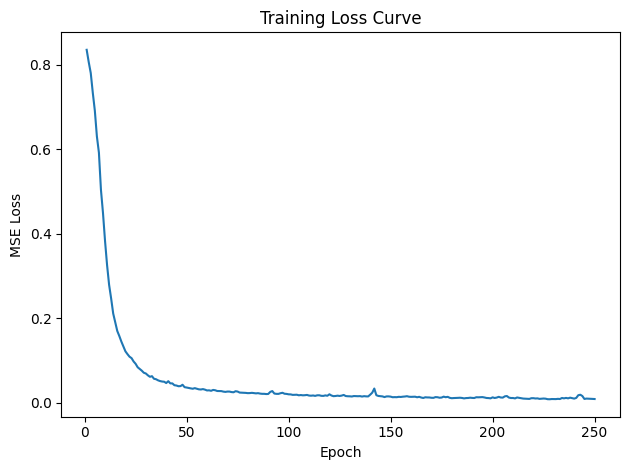

Fold 4 Training R²: 0.9909, Pearson r: 0.9956


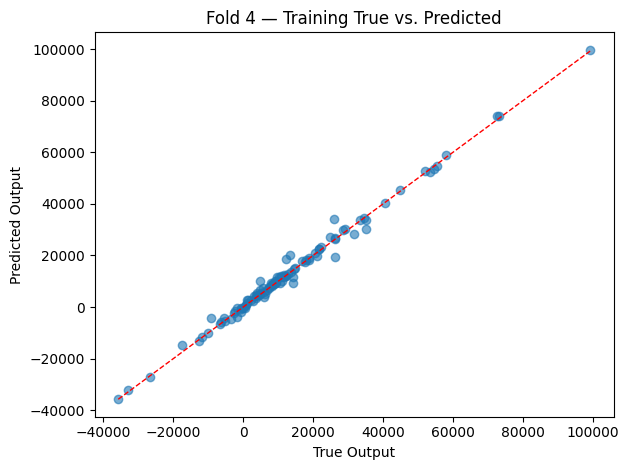

Fold 4 Validation MSE (norm): 1.4160
Fold 4 Validation R²: 0.3481, Pearson r: 0.6356


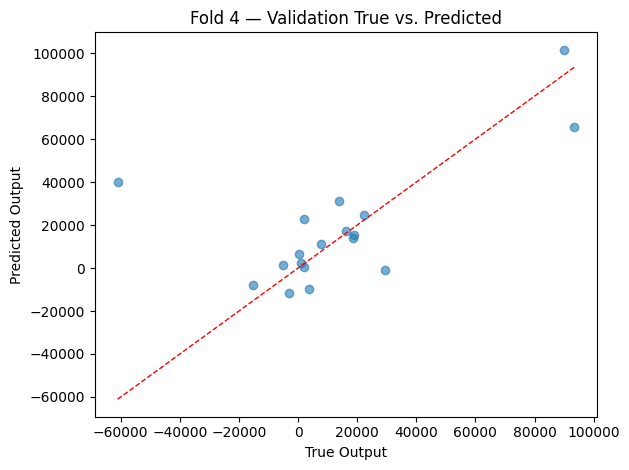


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0460
Epoch  10/250  MSE=0.2678
Epoch  20/250  MSE=0.0871
Epoch  30/250  MSE=0.0429
Epoch  40/250  MSE=0.0274
Epoch  50/250  MSE=0.0205
Epoch  60/250  MSE=0.0166
Epoch  70/250  MSE=0.0159
Epoch  80/250  MSE=0.0133
Epoch  90/250  MSE=0.0106
Epoch 100/250  MSE=0.0105
Epoch 110/250  MSE=0.0100
Epoch 120/250  MSE=0.0123
Epoch 130/250  MSE=0.0093
Epoch 140/250  MSE=0.0079
Epoch 150/250  MSE=0.0055
Epoch 160/250  MSE=0.0052
Epoch 170/250  MSE=0.0097
Epoch 180/250  MSE=0.0081
Epoch 190/250  MSE=0.0089
Epoch 200/250  MSE=0.0038
Epoch 210/250  MSE=0.0040
Epoch 220/250  MSE=0.0042
Epoch 230/250  MSE=0.0037
Epoch 240/250  MSE=0.0049
Epoch 250/250  MSE=0.0057


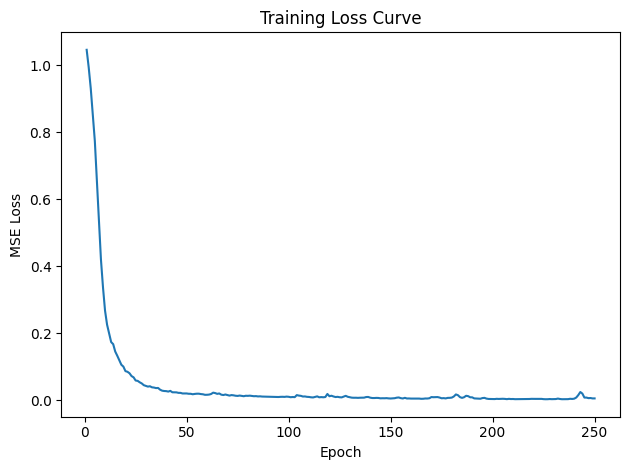

Fold 5 Training R²: 0.9964, Pearson r: 0.9984


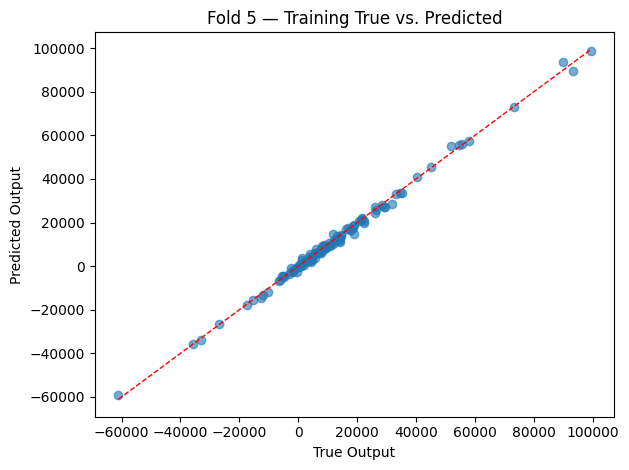

Fold 5 Validation MSE (norm): 0.4539
Fold 5 Validation R²: 0.4219, Pearson r: 0.8278


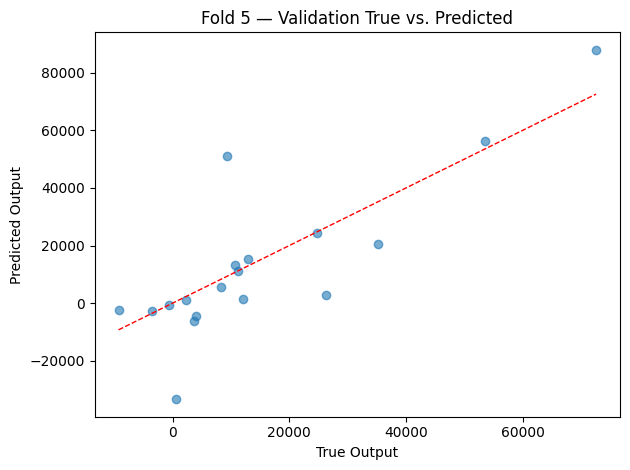


=== Fold 6/7 ===
Epoch   1/250  MSE=1.0051
Epoch  10/250  MSE=0.3489
Epoch  20/250  MSE=0.0961
Epoch  30/250  MSE=0.0580
Epoch  40/250  MSE=0.0435
Epoch  50/250  MSE=0.0364
Epoch  60/250  MSE=0.0310
Epoch  70/250  MSE=0.0249
Epoch  80/250  MSE=0.0221
Epoch  90/250  MSE=0.0176
Epoch 100/250  MSE=0.0176
Epoch 110/250  MSE=0.0160
Epoch 120/250  MSE=0.0352
Epoch 130/250  MSE=0.0120
Epoch 140/250  MSE=0.0169
Epoch 150/250  MSE=0.0103
Epoch 160/250  MSE=0.0083
Epoch 170/250  MSE=0.0088
Epoch 180/250  MSE=0.0131
Epoch 190/250  MSE=0.0077
Epoch 200/250  MSE=0.0089
Epoch 210/250  MSE=0.0078
Epoch 220/250  MSE=0.0049
Epoch 230/250  MSE=0.0041
Epoch 240/250  MSE=0.0041
Epoch 250/250  MSE=0.0032


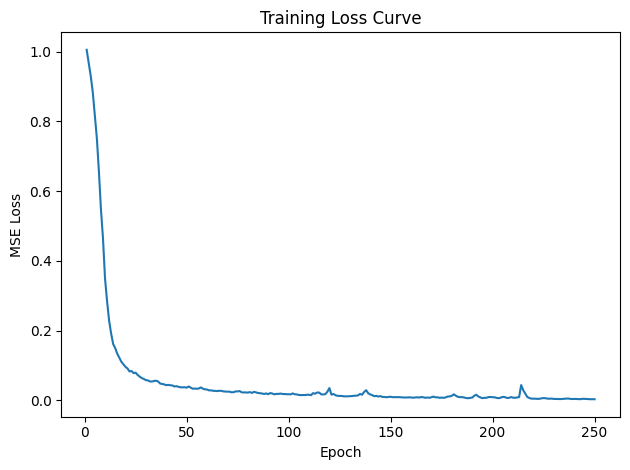

Fold 6 Training R²: 0.9972, Pearson r: 0.9987


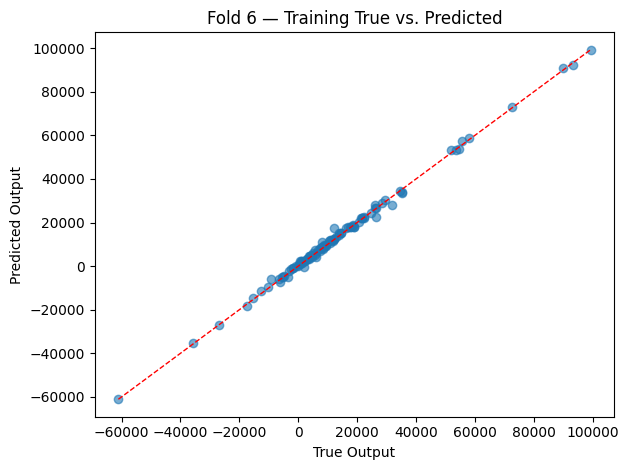

Fold 6 Validation MSE (norm): 0.6002
Fold 6 Validation R²: 0.4384, Pearson r: 0.7147


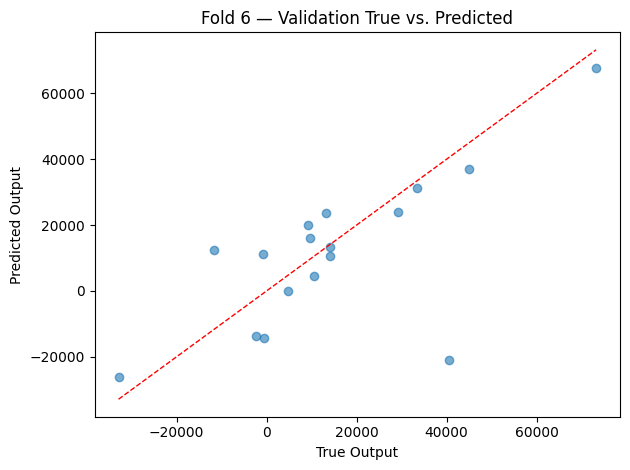


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1594
Epoch  10/250  MSE=0.4388
Epoch  20/250  MSE=0.1274
Epoch  30/250  MSE=0.0788
Epoch  40/250  MSE=0.0560
Epoch  50/250  MSE=0.0449
Epoch  60/250  MSE=0.0388
Epoch  70/250  MSE=0.0350
Epoch  80/250  MSE=0.0317
Epoch  90/250  MSE=0.0313
Epoch 100/250  MSE=0.0304
Epoch 110/250  MSE=0.0290
Epoch 120/250  MSE=0.0266
Epoch 130/250  MSE=0.0244
Epoch 140/250  MSE=0.0240
Epoch 150/250  MSE=0.0236
Epoch 160/250  MSE=0.0209
Epoch 170/250  MSE=0.0184
Epoch 180/250  MSE=0.0178
Epoch 190/250  MSE=0.0202
Epoch 200/250  MSE=0.0165
Epoch 210/250  MSE=0.0165
Epoch 220/250  MSE=0.0151
Epoch 230/250  MSE=0.0132
Epoch 240/250  MSE=0.0152
Epoch 250/250  MSE=0.0124


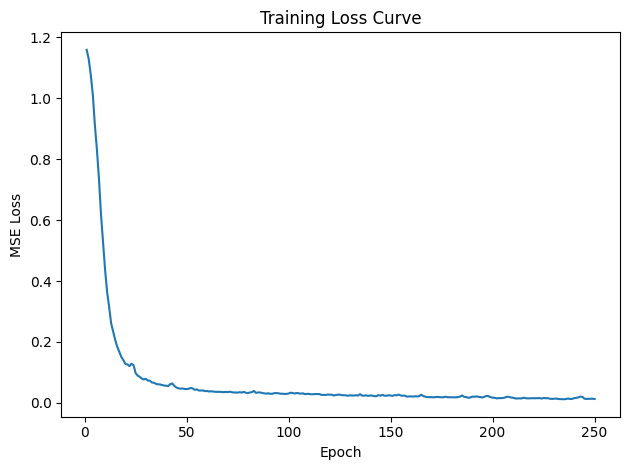

Fold 7 Training R²: 0.9886, Pearson r: 0.9947


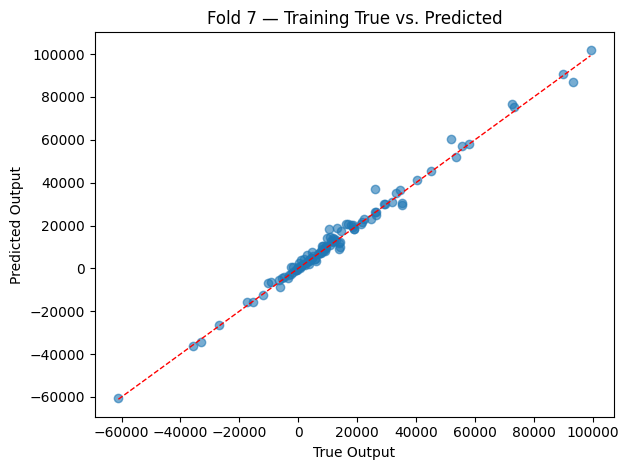

Fold 7 Validation MSE (norm): 0.4087
Fold 7 Validation R²: 0.0259, Pearson r: 0.6230


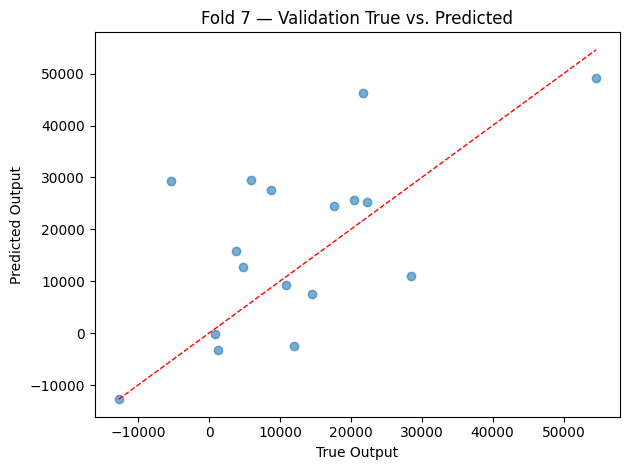


=== Validation MSE per fold ===
['0.2150', '0.4469', '0.3259', '1.4160', '0.4539', '0.6002', '0.4087']
Mean MSE (norm): 0.5524 ± 0.3693

=== Validation R² per fold ===
['-0.0751', '0.6774', '0.5504', '0.3481', '0.4219', '0.4384', '0.0259']
Mean R²: 0.3410 ± 0.2523

=== Validation Pearson r per fold ===
['0.5750', '0.8385', '0.8838', '0.6356', '0.8278', '0.7147', '0.6230']
Mean Pearson r: 0.7283 ± 0.1131


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [37]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [8, 8],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")
'''
'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [12] Relu


=== Fold 1/7 ===
Epoch   1/250  MSE=1.1294
Epoch  10/250  MSE=0.3272
Epoch  20/250  MSE=0.1252
Epoch  30/250  MSE=0.0815
Epoch  40/250  MSE=0.0559
Epoch  50/250  MSE=0.0420
Epoch  60/250  MSE=0.0302
Epoch  70/250  MSE=0.0245
Epoch  80/250  MSE=0.0197
Epoch  90/250  MSE=0.0172
Epoch 100/250  MSE=0.0144
Epoch 110/250  MSE=0.0125
Epoch 120/250  MSE=0.0119
Epoch 130/250  MSE=0.0109
Epoch 140/250  MSE=0.0085
Epoch 150/250  MSE=0.0187
Epoch 160/250  MSE=0.0068
Epoch 170/250  MSE=0.0061
Epoch 180/250  MSE=0.0059
Epoch 190/250  MSE=0.0054
Epoch 200/250  MSE=0.0041
Epoch 210/250  MSE=0.0048
Epoch 220/250  MSE=0.0040
Epoch 230/250  MSE=0.0030
Epoch 240/250  MSE=0.0206
Epoch 250/250  MSE=0.0051


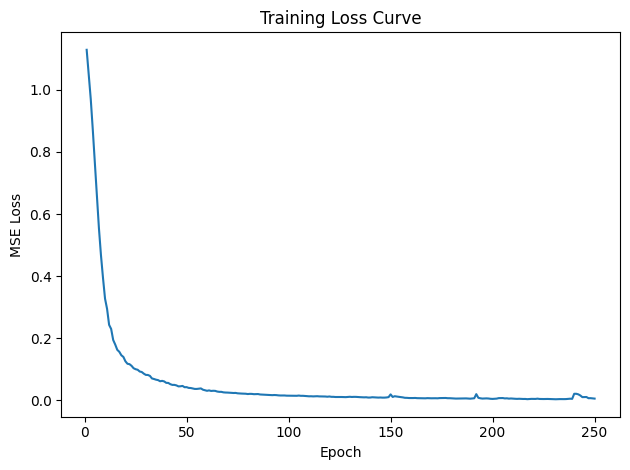

Fold 1 Training R²: 0.9971, Pearson r: 0.9987


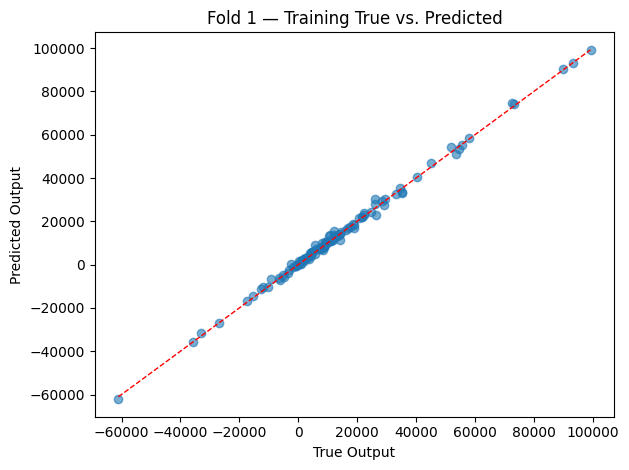

Fold 1 Validation MSE (norm): 0.0877
Fold 1 Validation R²: 0.5613, Pearson r: 0.7865


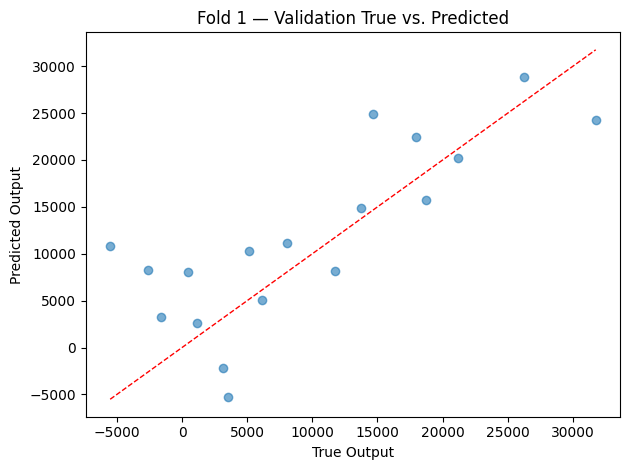


=== Fold 2/7 ===
Epoch   1/250  MSE=0.8597
Epoch  10/250  MSE=0.2535
Epoch  20/250  MSE=0.0877
Epoch  30/250  MSE=0.0521
Epoch  40/250  MSE=0.0378
Epoch  50/250  MSE=0.0300
Epoch  60/250  MSE=0.0242
Epoch  70/250  MSE=0.0182
Epoch  80/250  MSE=0.0178
Epoch  90/250  MSE=0.0132
Epoch 100/250  MSE=0.0149
Epoch 110/250  MSE=0.0102
Epoch 120/250  MSE=0.0096
Epoch 130/250  MSE=0.0086
Epoch 140/250  MSE=0.0080
Epoch 150/250  MSE=0.0081
Epoch 160/250  MSE=0.0064
Epoch 170/250  MSE=0.0056
Epoch 180/250  MSE=0.0058
Epoch 190/250  MSE=0.0071
Epoch 200/250  MSE=0.0054
Epoch 210/250  MSE=0.0061
Epoch 220/250  MSE=0.0052
Epoch 230/250  MSE=0.0040
Epoch 240/250  MSE=0.0067
Epoch 250/250  MSE=0.0046


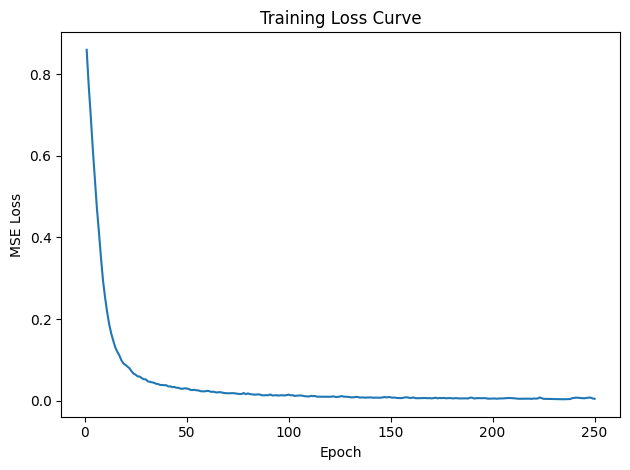

Fold 2 Training R²: 0.9947, Pearson r: 0.9977


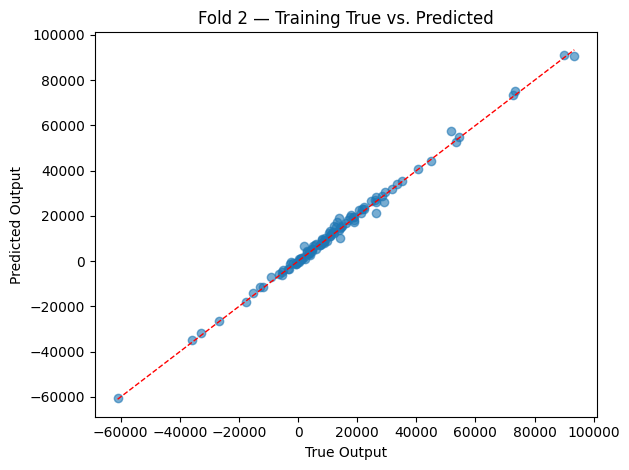

Fold 2 Validation MSE (norm): 0.2596
Fold 2 Validation R²: 0.8125, Pearson r: 0.9152


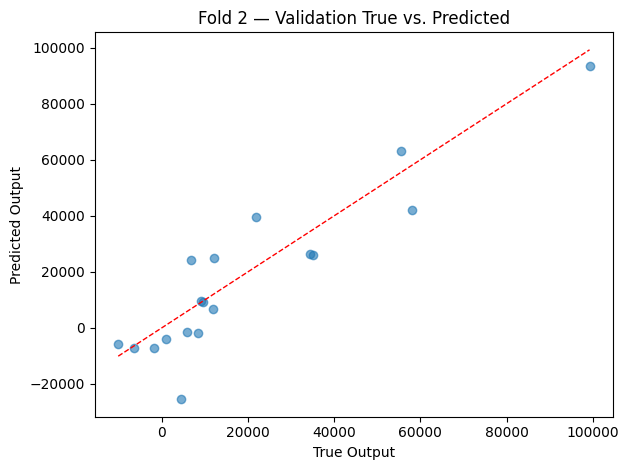


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0319
Epoch  10/250  MSE=0.2811
Epoch  20/250  MSE=0.0935
Epoch  30/250  MSE=0.0542
Epoch  40/250  MSE=0.0354
Epoch  50/250  MSE=0.0239
Epoch  60/250  MSE=0.0172
Epoch  70/250  MSE=0.0149
Epoch  80/250  MSE=0.0123
Epoch  90/250  MSE=0.0122
Epoch 100/250  MSE=0.0105
Epoch 110/250  MSE=0.0090
Epoch 120/250  MSE=0.0105
Epoch 130/250  MSE=0.0090
Epoch 140/250  MSE=0.0075
Epoch 150/250  MSE=0.0074
Epoch 160/250  MSE=0.0073
Epoch 170/250  MSE=0.0091
Epoch 180/250  MSE=0.0072
Epoch 190/250  MSE=0.0085
Epoch 200/250  MSE=0.0056
Epoch 210/250  MSE=0.0054
Epoch 220/250  MSE=0.0077
Epoch 230/250  MSE=0.0072
Epoch 240/250  MSE=0.0061
Epoch 250/250  MSE=0.0052


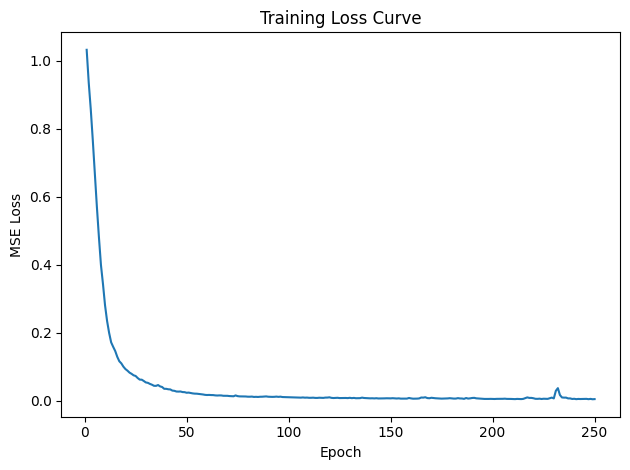

Fold 3 Training R²: 0.9955, Pearson r: 0.9979


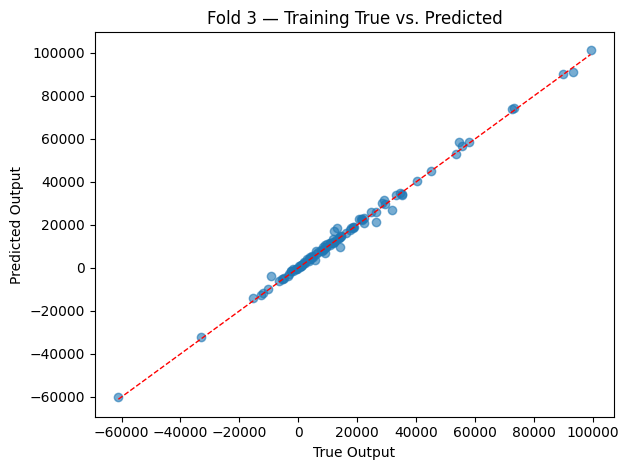

Fold 3 Validation MSE (norm): 0.2761
Fold 3 Validation R²: 0.6192, Pearson r: 0.8870


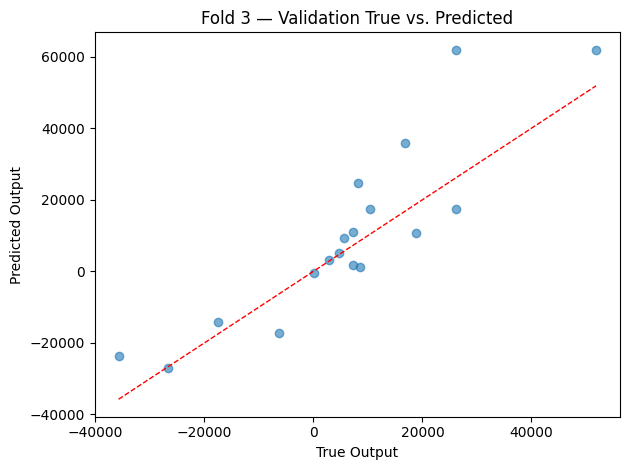


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8564
Epoch  10/250  MSE=0.2191
Epoch  20/250  MSE=0.0657
Epoch  30/250  MSE=0.0413
Epoch  40/250  MSE=0.0309
Epoch  50/250  MSE=0.0254
Epoch  60/250  MSE=0.0210
Epoch  70/250  MSE=0.0190
Epoch  80/250  MSE=0.0160
Epoch  90/250  MSE=0.0135
Epoch 100/250  MSE=0.0115
Epoch 110/250  MSE=0.0098
Epoch 120/250  MSE=0.0100
Epoch 130/250  MSE=0.0103
Epoch 140/250  MSE=0.0076
Epoch 150/250  MSE=0.0070
Epoch 160/250  MSE=0.0083
Epoch 170/250  MSE=0.0076
Epoch 180/250  MSE=0.0062
Epoch 190/250  MSE=0.0061
Epoch 200/250  MSE=0.0060
Epoch 210/250  MSE=0.0058
Epoch 220/250  MSE=0.0058
Epoch 230/250  MSE=0.0059
Epoch 240/250  MSE=0.0113
Epoch 250/250  MSE=0.0053


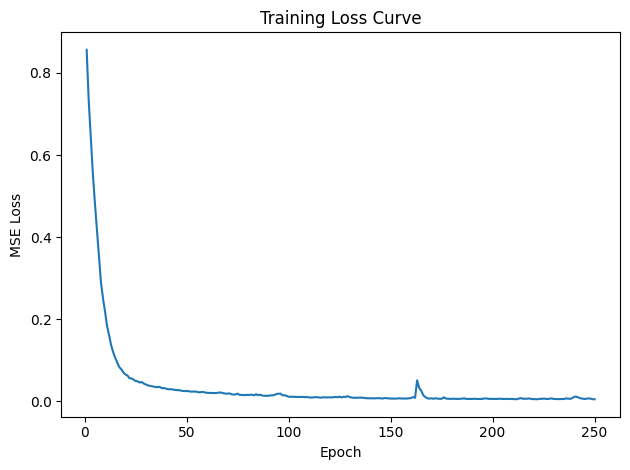

Fold 4 Training R²: 0.9936, Pearson r: 0.9971


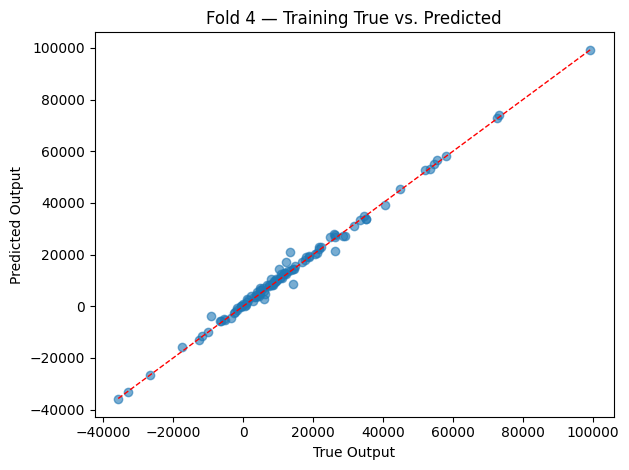

Fold 4 Validation MSE (norm): 0.9208
Fold 4 Validation R²: 0.5761, Pearson r: 0.7739


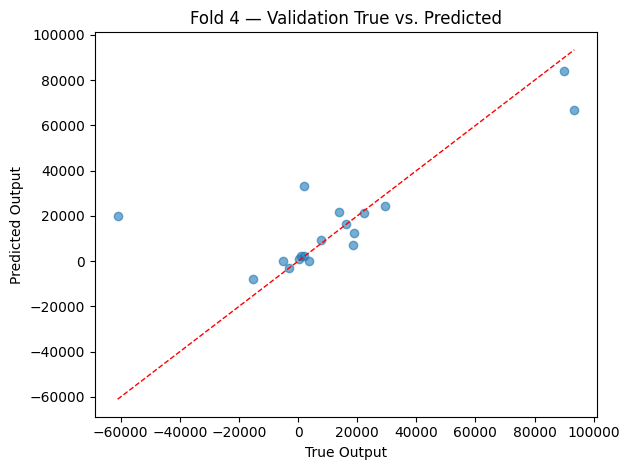


=== Fold 5/7 ===
Epoch   1/250  MSE=1.1131
Epoch  10/250  MSE=0.3759
Epoch  20/250  MSE=0.1179
Epoch  30/250  MSE=0.0765
Epoch  40/250  MSE=0.0569
Epoch  50/250  MSE=0.0486
Epoch  60/250  MSE=0.0384
Epoch  70/250  MSE=0.0326
Epoch  80/250  MSE=0.0279
Epoch  90/250  MSE=0.0236
Epoch 100/250  MSE=0.0204
Epoch 110/250  MSE=0.0176
Epoch 120/250  MSE=0.0176
Epoch 130/250  MSE=0.0142
Epoch 140/250  MSE=0.0134
Epoch 150/250  MSE=0.0122
Epoch 160/250  MSE=0.0109
Epoch 170/250  MSE=0.0116
Epoch 180/250  MSE=0.0100
Epoch 190/250  MSE=0.0112
Epoch 200/250  MSE=0.0095
Epoch 210/250  MSE=0.0088
Epoch 220/250  MSE=0.0088
Epoch 230/250  MSE=0.0102
Epoch 240/250  MSE=0.0100
Epoch 250/250  MSE=0.0073


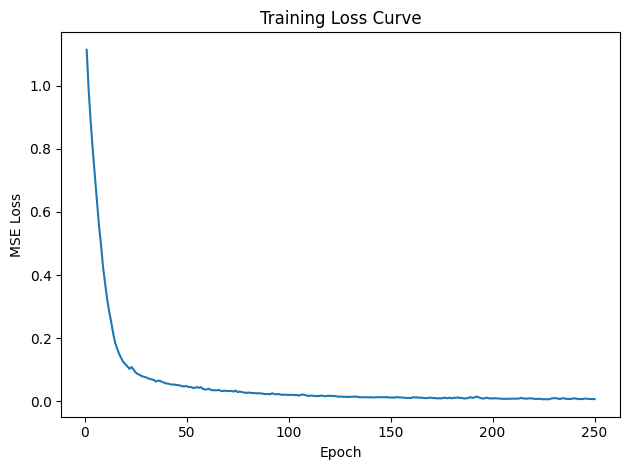

Fold 5 Training R²: 0.9908, Pearson r: 0.9971


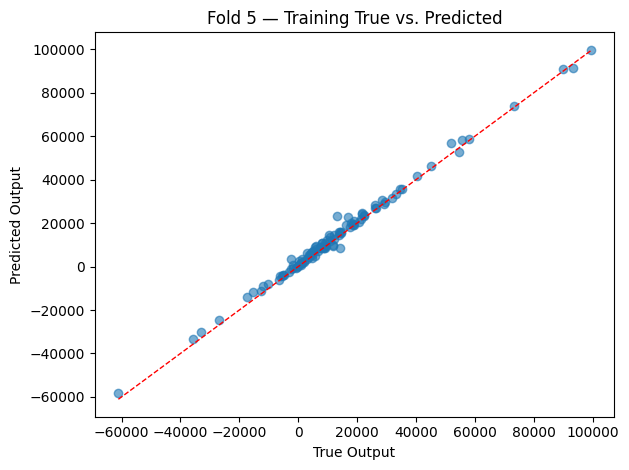

Fold 5 Validation MSE (norm): 0.4906
Fold 5 Validation R²: 0.3751, Pearson r: 0.7917


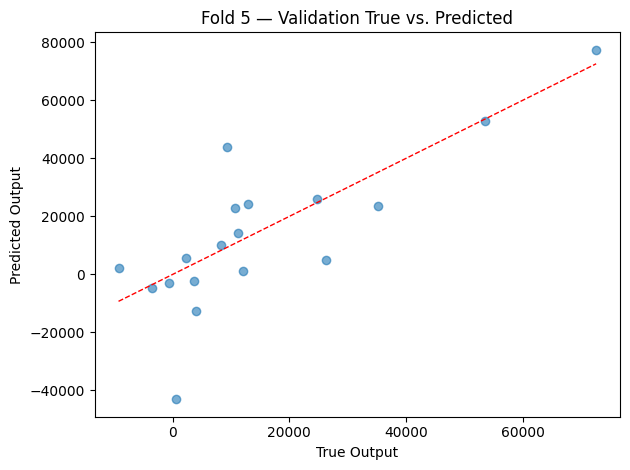


=== Fold 6/7 ===
Epoch   1/250  MSE=0.9875
Epoch  10/250  MSE=0.3700
Epoch  20/250  MSE=0.0896
Epoch  30/250  MSE=0.0538
Epoch  40/250  MSE=0.0352
Epoch  50/250  MSE=0.0274
Epoch  60/250  MSE=0.0225
Epoch  70/250  MSE=0.0199
Epoch  80/250  MSE=0.0168
Epoch  90/250  MSE=0.0154
Epoch 100/250  MSE=0.0137
Epoch 110/250  MSE=0.0107
Epoch 120/250  MSE=0.0108
Epoch 130/250  MSE=0.0081
Epoch 140/250  MSE=0.0078
Epoch 150/250  MSE=0.0066
Epoch 160/250  MSE=0.0060
Epoch 170/250  MSE=0.0052
Epoch 180/250  MSE=0.0050
Epoch 190/250  MSE=0.0051
Epoch 200/250  MSE=0.0044
Epoch 210/250  MSE=0.0057
Epoch 220/250  MSE=0.0062
Epoch 230/250  MSE=0.0051
Epoch 240/250  MSE=0.0051
Epoch 250/250  MSE=0.0038


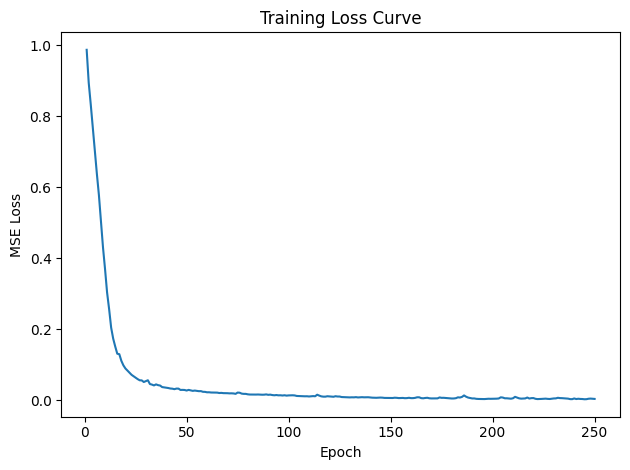

Fold 6 Training R²: 0.9966, Pearson r: 0.9987


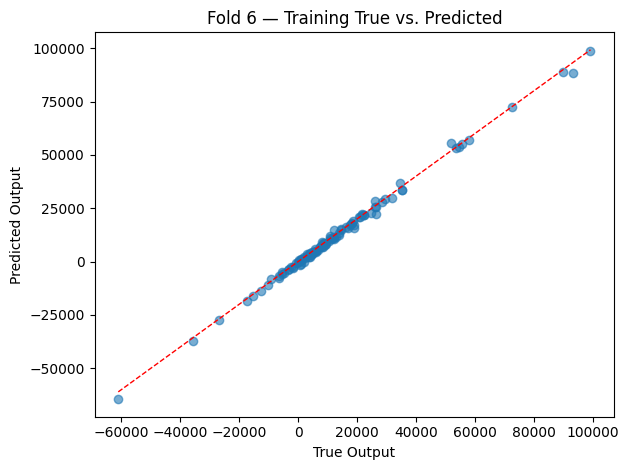

Fold 6 Validation MSE (norm): 1.4731
Fold 6 Validation R²: -0.3784, Pearson r: 0.5085


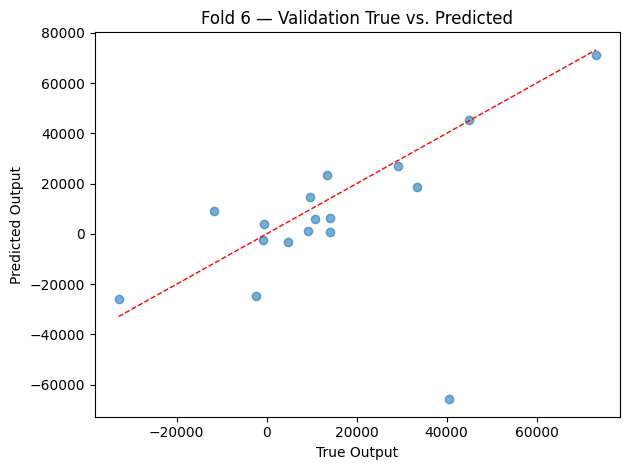


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1943
Epoch  10/250  MSE=0.4409
Epoch  20/250  MSE=0.1126
Epoch  30/250  MSE=0.0627
Epoch  40/250  MSE=0.0478
Epoch  50/250  MSE=0.0358
Epoch  60/250  MSE=0.0301
Epoch  70/250  MSE=0.0252
Epoch  80/250  MSE=0.0232
Epoch  90/250  MSE=0.0199
Epoch 100/250  MSE=0.0169
Epoch 110/250  MSE=0.0150
Epoch 120/250  MSE=0.0131
Epoch 130/250  MSE=0.0134
Epoch 140/250  MSE=0.0101
Epoch 150/250  MSE=0.0177
Epoch 160/250  MSE=0.0092
Epoch 170/250  MSE=0.0078
Epoch 180/250  MSE=0.0057
Epoch 190/250  MSE=0.0074
Epoch 200/250  MSE=0.0075
Epoch 210/250  MSE=0.0064
Epoch 220/250  MSE=0.0073
Epoch 230/250  MSE=0.0214
Epoch 240/250  MSE=0.0063
Epoch 250/250  MSE=0.0051


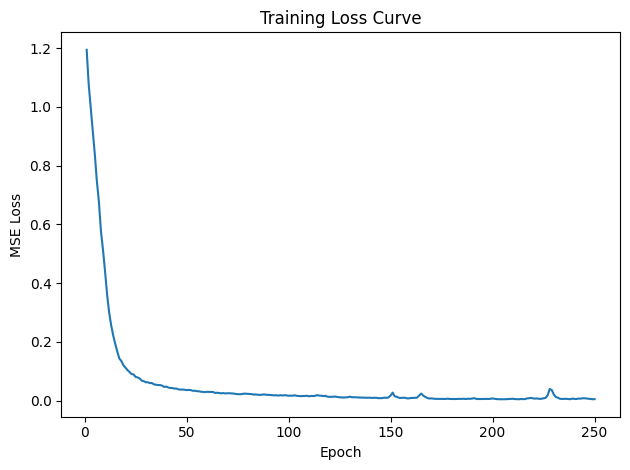

Fold 7 Training R²: 0.9957, Pearson r: 0.9978


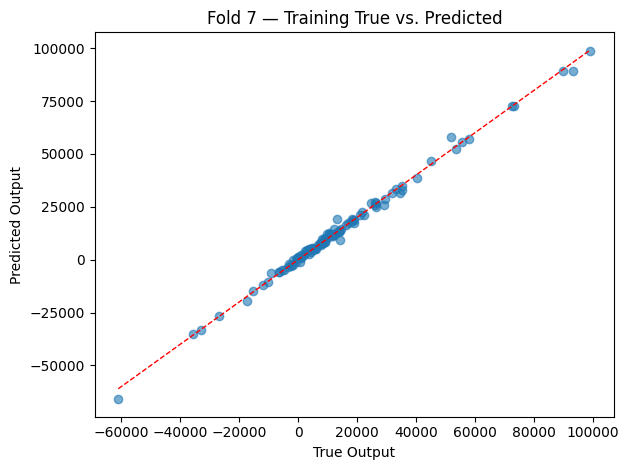

Fold 7 Validation MSE (norm): 0.2537
Fold 7 Validation R²: 0.3954, Pearson r: 0.7330


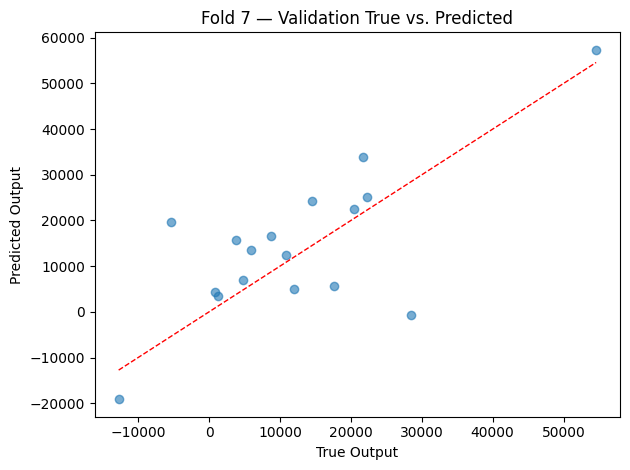


=== Validation MSE per fold ===
['0.0877', '0.2596', '0.2761', '0.9208', '0.4906', '1.4731', '0.2537']
Mean MSE (norm): 0.5374 ± 0.4556

=== Validation R² per fold ===
['0.5613', '0.8125', '0.6192', '0.5761', '0.3751', '-0.3784', '0.3954']
Mean R²: 0.4230 ± 0.3542

=== Validation Pearson r per fold ===
['0.7865', '0.9152', '0.8870', '0.7739', '0.7917', '0.5085', '0.7330']
Mean Pearson r: 0.7708 ± 0.1226


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [38]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [12],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [16] linear


=== Fold 1/7 ===
Epoch   1/250  MSE=1.0722
Epoch  10/250  MSE=0.2472
Epoch  20/250  MSE=0.1466
Epoch  30/250  MSE=0.1218
Epoch  40/250  MSE=0.1208
Epoch  50/250  MSE=0.1120
Epoch  60/250  MSE=0.1036
Epoch  70/250  MSE=0.0974
Epoch  80/250  MSE=0.0978
Epoch  90/250  MSE=0.0923
Epoch 100/250  MSE=0.0909
Epoch 110/250  MSE=0.0898
Epoch 120/250  MSE=0.0885
Epoch 130/250  MSE=0.0888
Epoch 140/250  MSE=0.0967
Epoch 150/250  MSE=0.0931
Epoch 160/250  MSE=0.0875
Epoch 170/250  MSE=0.0872
Epoch 180/250  MSE=0.0834
Epoch 190/250  MSE=0.0835
Epoch 200/250  MSE=0.0820
Epoch 210/250  MSE=0.0880
Epoch 220/250  MSE=0.0806
Epoch 230/250  MSE=0.0899
Epoch 240/250  MSE=0.0780
Epoch 250/250  MSE=0.0828


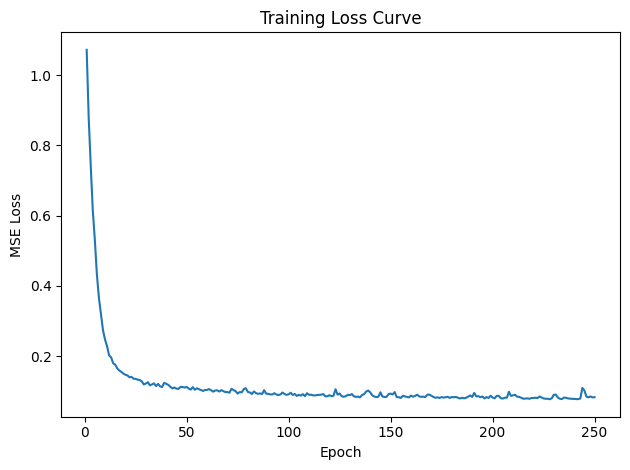

Fold 1 Training R²: 0.9348, Pearson r: 0.9670


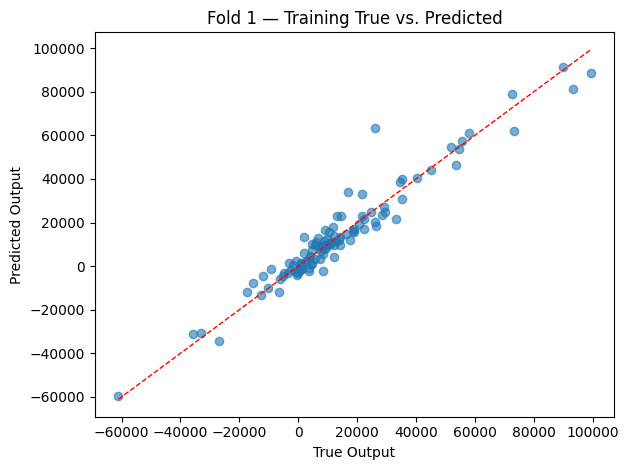

Fold 1 Validation MSE (norm): 0.1675
Fold 1 Validation R²: 0.1625, Pearson r: 0.6855


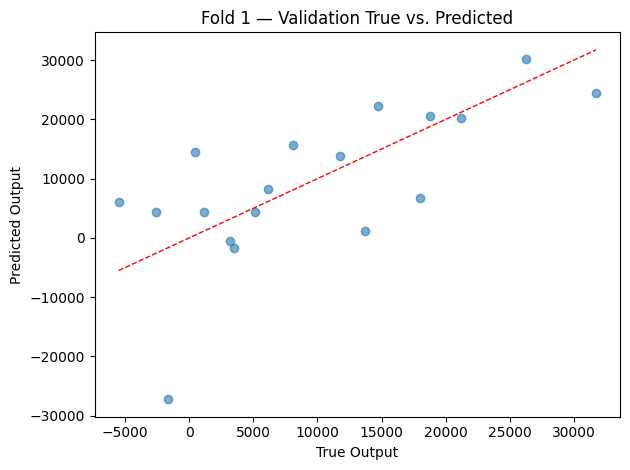


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9968
Epoch  10/250  MSE=0.2588
Epoch  20/250  MSE=0.1465
Epoch  30/250  MSE=0.1159
Epoch  40/250  MSE=0.1099
Epoch  50/250  MSE=0.1038
Epoch  60/250  MSE=0.1007
Epoch  70/250  MSE=0.1028
Epoch  80/250  MSE=0.0946
Epoch  90/250  MSE=0.0889
Epoch 100/250  MSE=0.0913
Epoch 110/250  MSE=0.0854
Epoch 120/250  MSE=0.0893
Epoch 130/250  MSE=0.0847
Epoch 140/250  MSE=0.0835
Epoch 150/250  MSE=0.0816
Epoch 160/250  MSE=0.0824
Epoch 170/250  MSE=0.1027
Epoch 180/250  MSE=0.0790
Epoch 190/250  MSE=0.0764
Epoch 200/250  MSE=0.0788
Epoch 210/250  MSE=0.0828
Epoch 220/250  MSE=0.0765
Epoch 230/250  MSE=0.0772
Epoch 240/250  MSE=0.0739
Epoch 250/250  MSE=0.0752


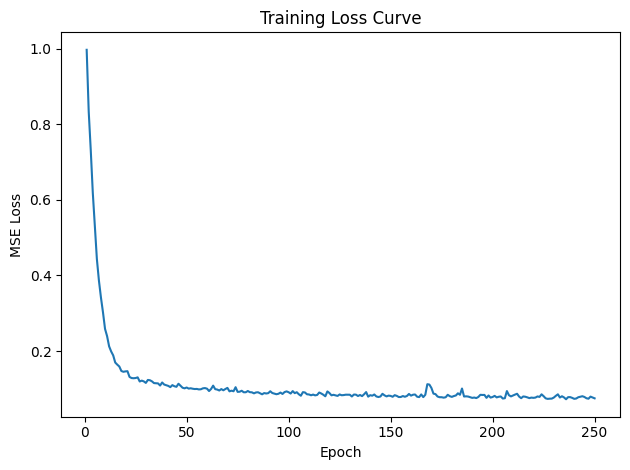

Fold 2 Training R²: 0.9245, Pearson r: 0.9616


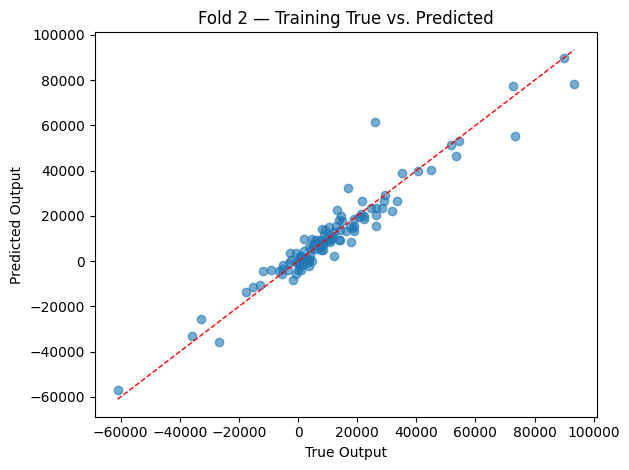

Fold 2 Validation MSE (norm): 0.1666
Fold 2 Validation R²: 0.8797, Pearson r: 0.9406


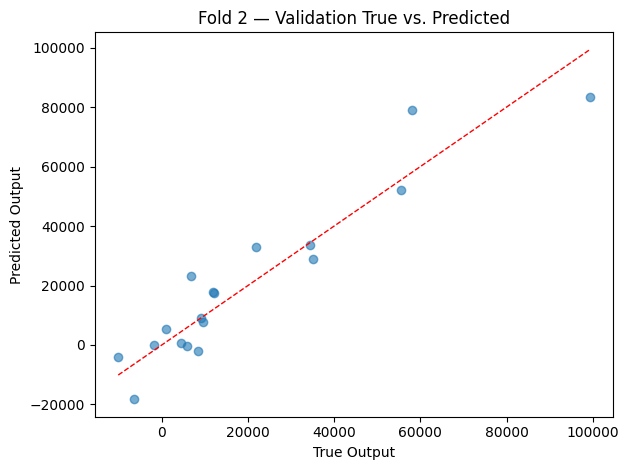


=== Fold 3/7 ===
Epoch   1/250  MSE=0.9199
Epoch  10/250  MSE=0.2532
Epoch  20/250  MSE=0.1256
Epoch  30/250  MSE=0.0895
Epoch  40/250  MSE=0.0802
Epoch  50/250  MSE=0.0651
Epoch  60/250  MSE=0.0642
Epoch  70/250  MSE=0.0619
Epoch  80/250  MSE=0.0602
Epoch  90/250  MSE=0.0597
Epoch 100/250  MSE=0.0603
Epoch 110/250  MSE=0.0543
Epoch 120/250  MSE=0.0565
Epoch 130/250  MSE=0.0568
Epoch 140/250  MSE=0.0537
Epoch 150/250  MSE=0.0537
Epoch 160/250  MSE=0.0561
Epoch 170/250  MSE=0.0624
Epoch 180/250  MSE=0.0527
Epoch 190/250  MSE=0.0518
Epoch 200/250  MSE=0.0542
Epoch 210/250  MSE=0.0520
Epoch 220/250  MSE=0.0515
Epoch 230/250  MSE=0.0597
Epoch 240/250  MSE=0.0505
Epoch 250/250  MSE=0.0526


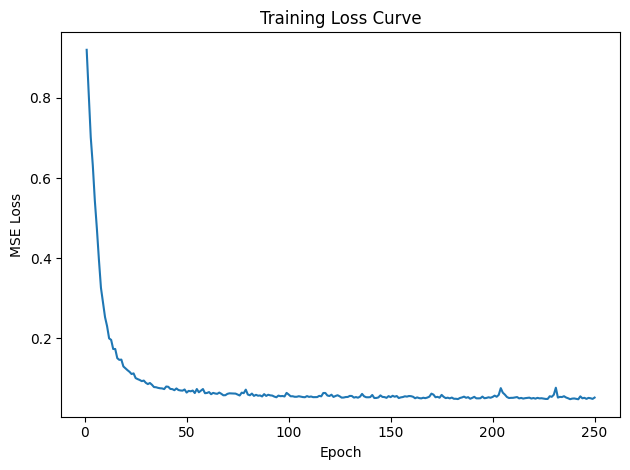

Fold 3 Training R²: 0.9542, Pearson r: 0.9771


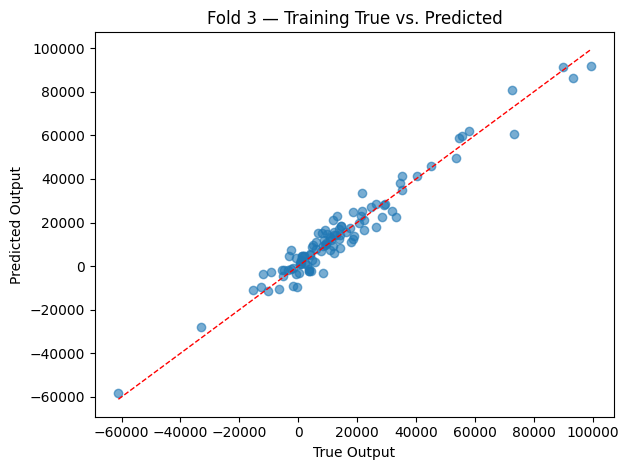

Fold 3 Validation MSE (norm): 0.3241
Fold 3 Validation R²: 0.5529, Pearson r: 0.9130


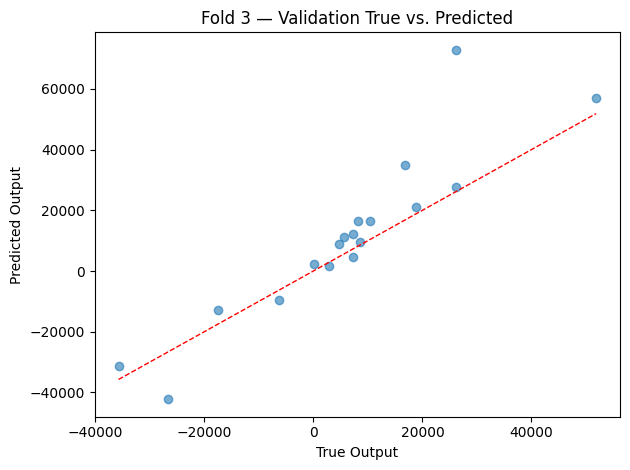


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8009
Epoch  10/250  MSE=0.1487
Epoch  20/250  MSE=0.0914
Epoch  30/250  MSE=0.0843
Epoch  40/250  MSE=0.0814
Epoch  50/250  MSE=0.0758
Epoch  60/250  MSE=0.0758
Epoch  70/250  MSE=0.0868
Epoch  80/250  MSE=0.0742
Epoch  90/250  MSE=0.0732
Epoch 100/250  MSE=0.0756
Epoch 110/250  MSE=0.0713
Epoch 120/250  MSE=0.0733
Epoch 130/250  MSE=0.0734
Epoch 140/250  MSE=0.0747
Epoch 150/250  MSE=0.0726
Epoch 160/250  MSE=0.0738
Epoch 170/250  MSE=0.0825
Epoch 180/250  MSE=0.0740
Epoch 190/250  MSE=0.0724
Epoch 200/250  MSE=0.0715
Epoch 210/250  MSE=0.0759
Epoch 220/250  MSE=0.0720
Epoch 230/250  MSE=0.0706
Epoch 240/250  MSE=0.0710
Epoch 250/250  MSE=0.0714


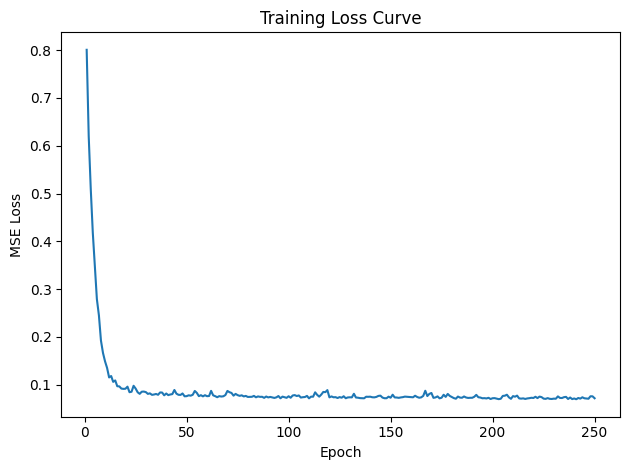

Fold 4 Training R²: 0.9154, Pearson r: 0.9575


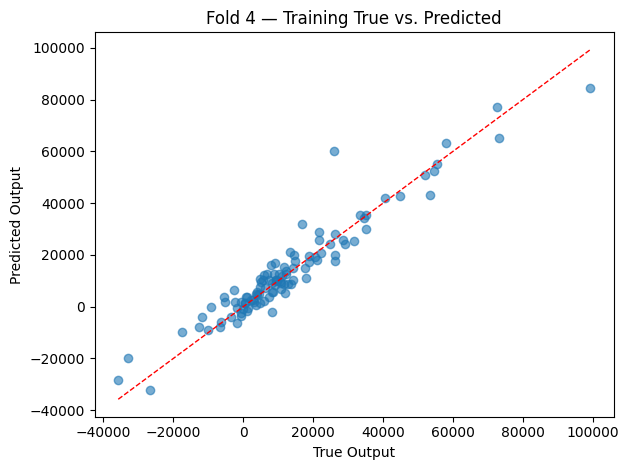

Fold 4 Validation MSE (norm): 1.1313
Fold 4 Validation R²: 0.4792, Pearson r: 0.7126


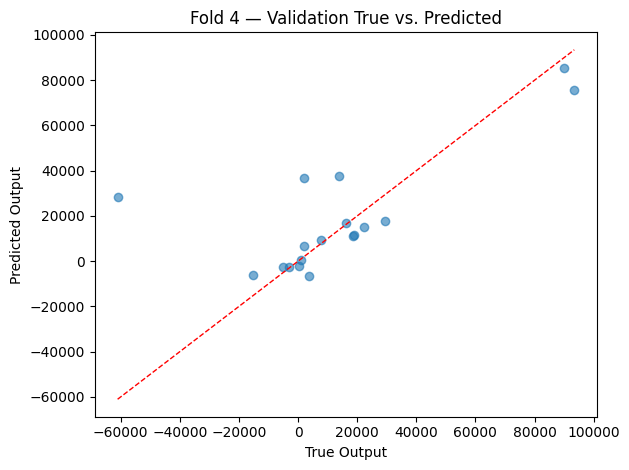


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0839
Epoch  10/250  MSE=0.2392
Epoch  20/250  MSE=0.1425
Epoch  30/250  MSE=0.1299
Epoch  40/250  MSE=0.1144
Epoch  50/250  MSE=0.1069
Epoch  60/250  MSE=0.1013
Epoch  70/250  MSE=0.1024
Epoch  80/250  MSE=0.1091
Epoch  90/250  MSE=0.0956
Epoch 100/250  MSE=0.1029
Epoch 110/250  MSE=0.0910
Epoch 120/250  MSE=0.0962
Epoch 130/250  MSE=0.0882
Epoch 140/250  MSE=0.0878
Epoch 150/250  MSE=0.1072
Epoch 160/250  MSE=0.0851
Epoch 170/250  MSE=0.0844
Epoch 180/250  MSE=0.0835
Epoch 190/250  MSE=0.0854
Epoch 200/250  MSE=0.0953
Epoch 210/250  MSE=0.0792
Epoch 220/250  MSE=0.0830
Epoch 230/250  MSE=0.0836
Epoch 240/250  MSE=0.0868
Epoch 250/250  MSE=0.0802


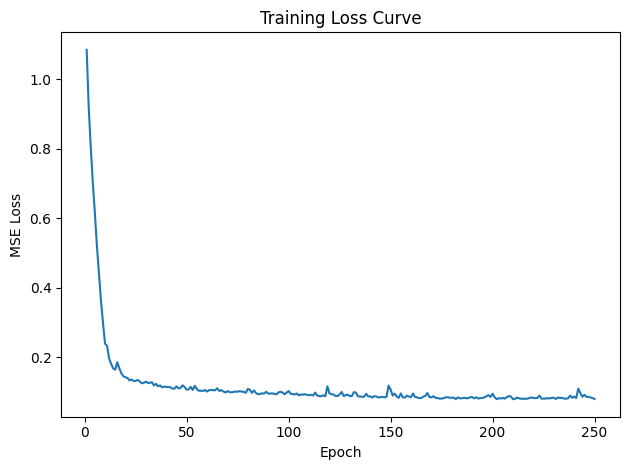

Fold 5 Training R²: 0.9254, Pearson r: 0.9629


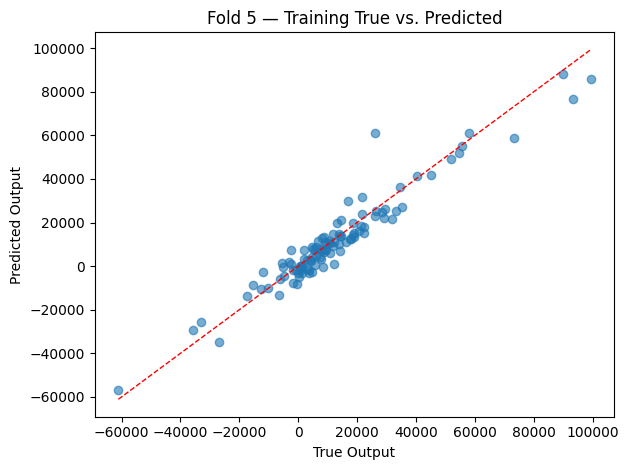

Fold 5 Validation MSE (norm): 0.1793
Fold 5 Validation R²: 0.7716, Pearson r: 0.9265


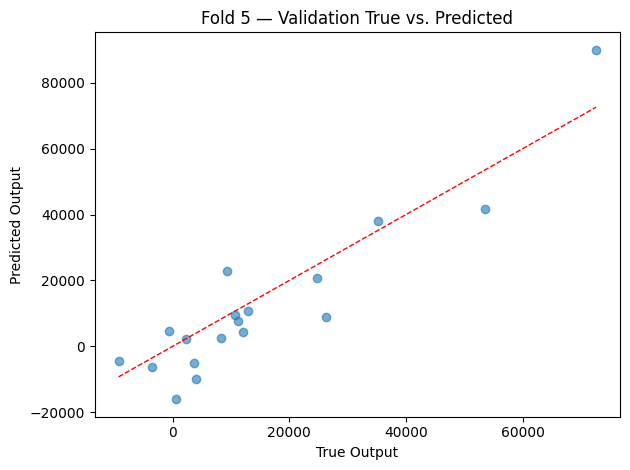


=== Fold 6/7 ===
Epoch   1/250  MSE=1.0647
Epoch  10/250  MSE=0.2414
Epoch  20/250  MSE=0.1206
Epoch  30/250  MSE=0.0932
Epoch  40/250  MSE=0.0826
Epoch  50/250  MSE=0.0806
Epoch  60/250  MSE=0.0896
Epoch  70/250  MSE=0.0759
Epoch  80/250  MSE=0.0720
Epoch  90/250  MSE=0.0723
Epoch 100/250  MSE=0.0713
Epoch 110/250  MSE=0.0754
Epoch 120/250  MSE=0.0722
Epoch 130/250  MSE=0.0742
Epoch 140/250  MSE=0.0710
Epoch 150/250  MSE=0.0685
Epoch 160/250  MSE=0.0705
Epoch 170/250  MSE=0.0694
Epoch 180/250  MSE=0.0743
Epoch 190/250  MSE=0.0678
Epoch 200/250  MSE=0.0819
Epoch 210/250  MSE=0.0733
Epoch 220/250  MSE=0.0676
Epoch 230/250  MSE=0.0676
Epoch 240/250  MSE=0.0687
Epoch 250/250  MSE=0.0701


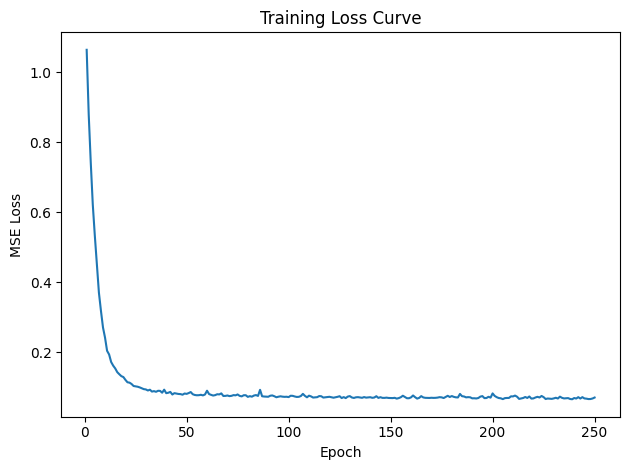

Fold 6 Training R²: 0.9364, Pearson r: 0.9682


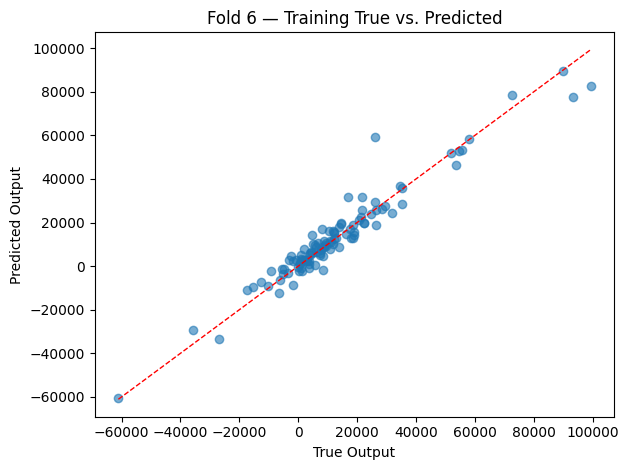

Fold 6 Validation MSE (norm): 1.0840
Fold 6 Validation R²: -0.0143, Pearson r: 0.5014


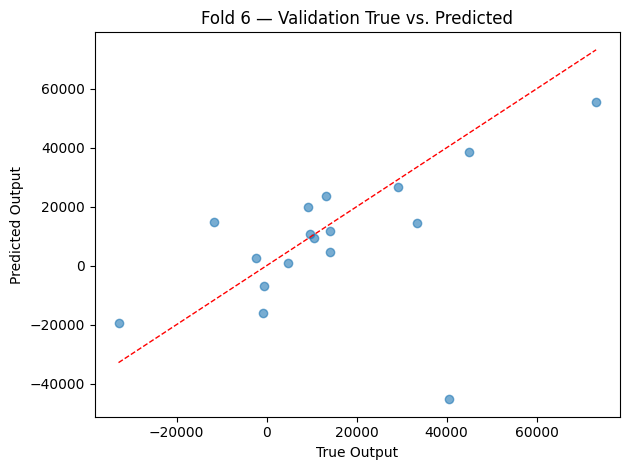


=== Fold 7/7 ===
Epoch   1/250  MSE=1.0447
Epoch  10/250  MSE=0.2256
Epoch  20/250  MSE=0.1411
Epoch  30/250  MSE=0.1241
Epoch  40/250  MSE=0.1178
Epoch  50/250  MSE=0.1074
Epoch  60/250  MSE=0.1038
Epoch  70/250  MSE=0.1023
Epoch  80/250  MSE=0.0944
Epoch  90/250  MSE=0.0884
Epoch 100/250  MSE=0.0924
Epoch 110/250  MSE=0.0868
Epoch 120/250  MSE=0.0823
Epoch 130/250  MSE=0.0859
Epoch 140/250  MSE=0.0854
Epoch 150/250  MSE=0.0868
Epoch 160/250  MSE=0.0868
Epoch 170/250  MSE=0.0846
Epoch 180/250  MSE=0.0840
Epoch 190/250  MSE=0.0803
Epoch 200/250  MSE=0.0807
Epoch 210/250  MSE=0.0781
Epoch 220/250  MSE=0.0848
Epoch 230/250  MSE=0.0796
Epoch 240/250  MSE=0.0843
Epoch 250/250  MSE=0.0750


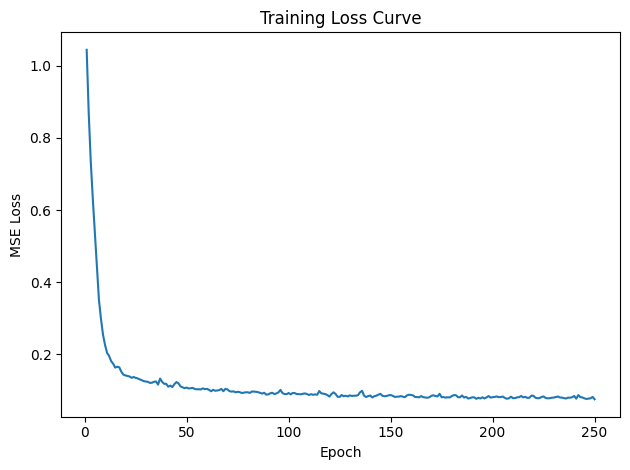

Fold 7 Training R²: 0.9334, Pearson r: 0.9663


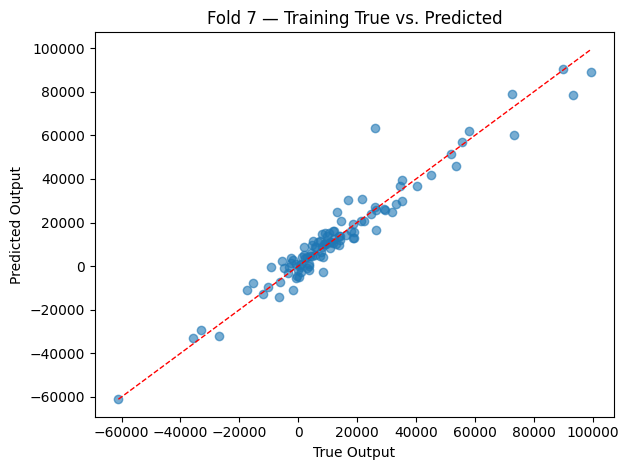

Fold 7 Validation MSE (norm): 0.2429
Fold 7 Validation R²: 0.4210, Pearson r: 0.7560


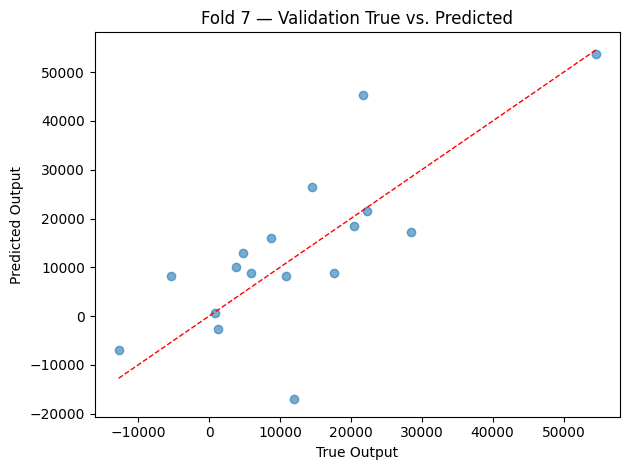


=== Validation MSE per fold ===
['0.1675', '0.1666', '0.3241', '1.1313', '0.1793', '1.0840', '0.2429']
Mean MSE (norm): 0.4708 ± 0.4063

=== Validation R² per fold ===
['0.1625', '0.8797', '0.5529', '0.4792', '0.7716', '-0.0143', '0.4210']
Mean R²: 0.4647 ± 0.2921

=== Validation Pearson r per fold ===
['0.6855', '0.9406', '0.9130', '0.7126', '0.9265', '0.5014', '0.7560']
Mean Pearson r: 0.7765 ± 0.1495


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [39]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [16],
    'activation':  'linear',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [8,8] linear


=== Fold 1/7 ===
Epoch   1/250  MSE=1.1861
Epoch  10/250  MSE=0.2810
Epoch  20/250  MSE=0.1513
Epoch  30/250  MSE=0.1265
Epoch  40/250  MSE=0.1140
Epoch  50/250  MSE=0.1216
Epoch  60/250  MSE=0.1020
Epoch  70/250  MSE=0.0959
Epoch  80/250  MSE=0.0995
Epoch  90/250  MSE=0.0922
Epoch 100/250  MSE=0.0882
Epoch 110/250  MSE=0.0957
Epoch 120/250  MSE=0.0884
Epoch 130/250  MSE=0.0862
Epoch 140/250  MSE=0.0831
Epoch 150/250  MSE=0.0832
Epoch 160/250  MSE=0.0821
Epoch 170/250  MSE=0.0835
Epoch 180/250  MSE=0.0855
Epoch 190/250  MSE=0.0871
Epoch 200/250  MSE=0.0835
Epoch 210/250  MSE=0.0781
Epoch 220/250  MSE=0.0781
Epoch 230/250  MSE=0.0821
Epoch 240/250  MSE=0.0770
Epoch 250/250  MSE=0.0801


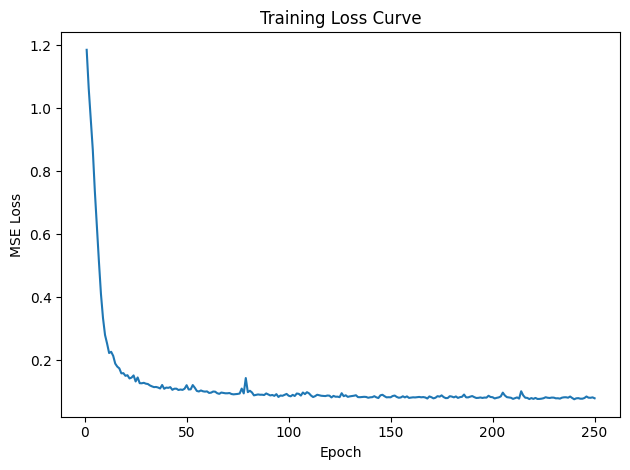

Fold 1 Training R²: 0.9355, Pearson r: 0.9673


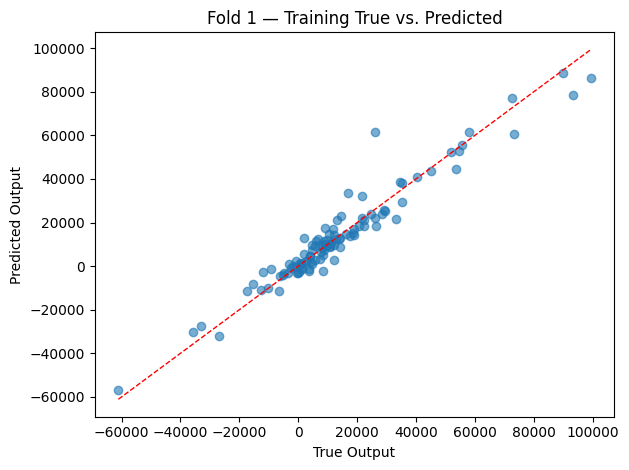

Fold 1 Validation MSE (norm): 0.1376
Fold 1 Validation R²: 0.3120, Pearson r: 0.7072


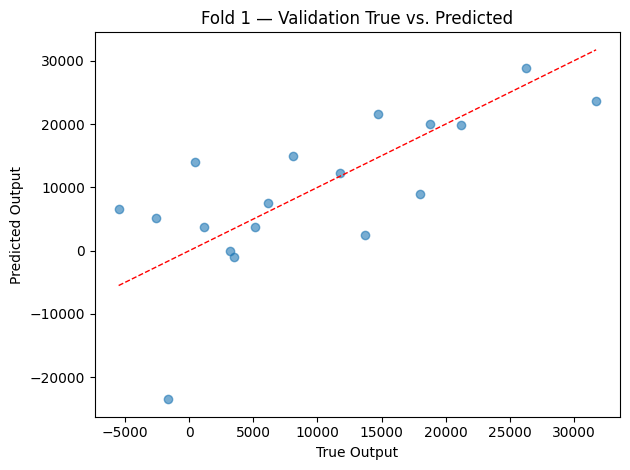


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9282
Epoch  10/250  MSE=0.2556
Epoch  20/250  MSE=0.1385
Epoch  30/250  MSE=0.1350
Epoch  40/250  MSE=0.1224
Epoch  50/250  MSE=0.1074
Epoch  60/250  MSE=0.1086
Epoch  70/250  MSE=0.0976
Epoch  80/250  MSE=0.0987
Epoch  90/250  MSE=0.0958
Epoch 100/250  MSE=0.0904
Epoch 110/250  MSE=0.0905
Epoch 120/250  MSE=0.0910
Epoch 130/250  MSE=0.0958
Epoch 140/250  MSE=0.0834
Epoch 150/250  MSE=0.0838
Epoch 160/250  MSE=0.0849
Epoch 170/250  MSE=0.0867
Epoch 180/250  MSE=0.0822
Epoch 190/250  MSE=0.0803
Epoch 200/250  MSE=0.0787
Epoch 210/250  MSE=0.0755
Epoch 220/250  MSE=0.0761
Epoch 230/250  MSE=0.0756
Epoch 240/250  MSE=0.0754
Epoch 250/250  MSE=0.0781


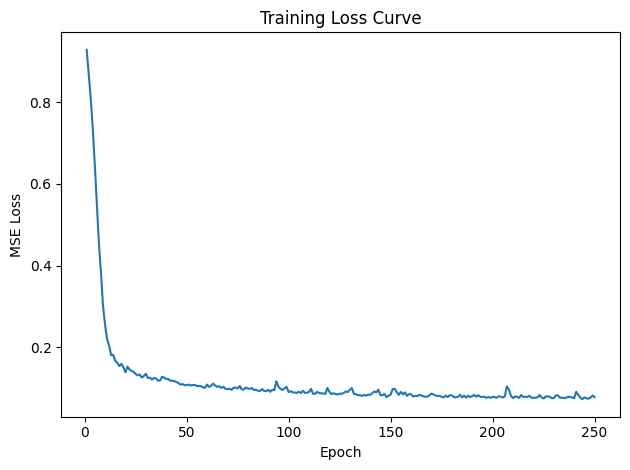

Fold 2 Training R²: 0.9191, Pearson r: 0.9590


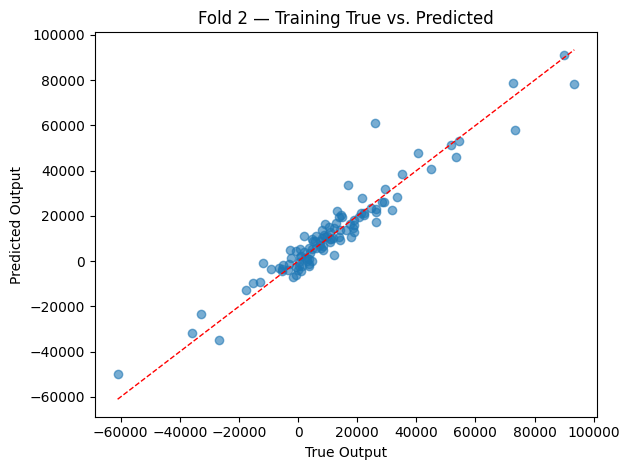

Fold 2 Validation MSE (norm): 0.1661
Fold 2 Validation R²: 0.8801, Pearson r: 0.9421


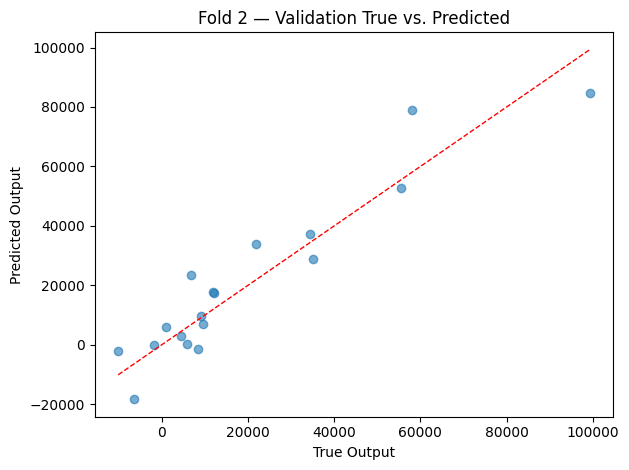


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0384
Epoch  10/250  MSE=0.2317
Epoch  20/250  MSE=0.1237
Epoch  30/250  MSE=0.0924
Epoch  40/250  MSE=0.0806
Epoch  50/250  MSE=0.0704
Epoch  60/250  MSE=0.0687
Epoch  70/250  MSE=0.0627
Epoch  80/250  MSE=0.0624
Epoch  90/250  MSE=0.0579
Epoch 100/250  MSE=0.0587
Epoch 110/250  MSE=0.0611
Epoch 120/250  MSE=0.0568
Epoch 130/250  MSE=0.0576
Epoch 140/250  MSE=0.0558
Epoch 150/250  MSE=0.0582
Epoch 160/250  MSE=0.0595
Epoch 170/250  MSE=0.0563
Epoch 180/250  MSE=0.0530
Epoch 190/250  MSE=0.0543
Epoch 200/250  MSE=0.0550
Epoch 210/250  MSE=0.0558
Epoch 220/250  MSE=0.0586
Epoch 230/250  MSE=0.0518
Epoch 240/250  MSE=0.0526
Epoch 250/250  MSE=0.0557


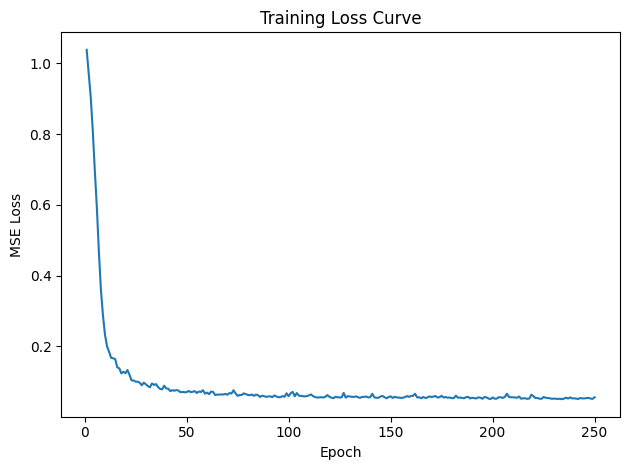

Fold 3 Training R²: 0.9509, Pearson r: 0.9754


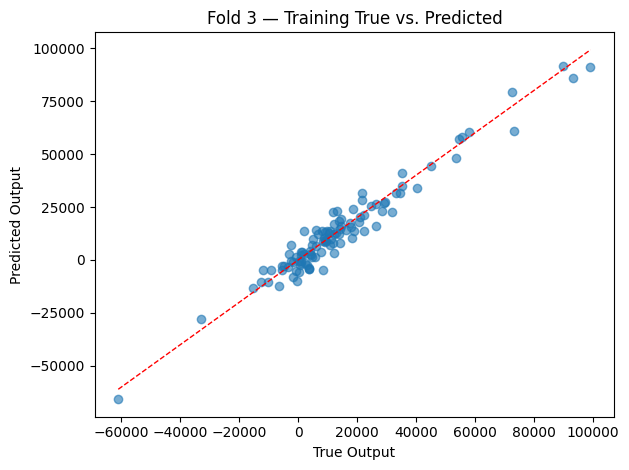

Fold 3 Validation MSE (norm): 0.3284
Fold 3 Validation R²: 0.5469, Pearson r: 0.9114


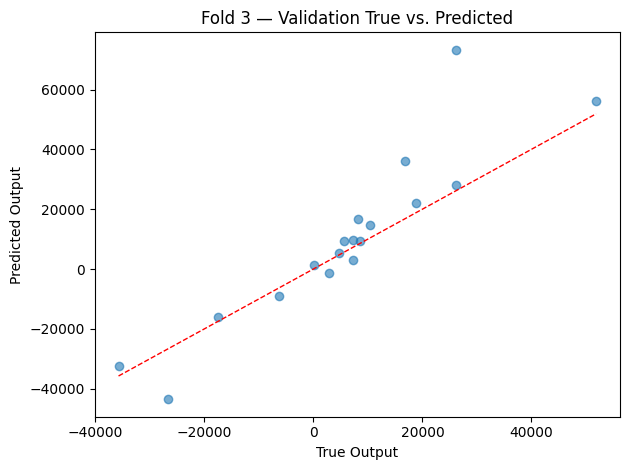


=== Fold 4/7 ===
Epoch   1/250  MSE=0.7774
Epoch  10/250  MSE=0.1402
Epoch  20/250  MSE=0.0869
Epoch  30/250  MSE=0.0811
Epoch  40/250  MSE=0.0769
Epoch  50/250  MSE=0.0800
Epoch  60/250  MSE=0.0741
Epoch  70/250  MSE=0.0748
Epoch  80/250  MSE=0.0770
Epoch  90/250  MSE=0.0806
Epoch 100/250  MSE=0.0750
Epoch 110/250  MSE=0.0733
Epoch 120/250  MSE=0.0742
Epoch 130/250  MSE=0.0784
Epoch 140/250  MSE=0.0725
Epoch 150/250  MSE=0.0714
Epoch 160/250  MSE=0.0721
Epoch 170/250  MSE=0.0710
Epoch 180/250  MSE=0.0749
Epoch 190/250  MSE=0.0713
Epoch 200/250  MSE=0.0710
Epoch 210/250  MSE=0.0704
Epoch 220/250  MSE=0.0724
Epoch 230/250  MSE=0.0704
Epoch 240/250  MSE=0.0695
Epoch 250/250  MSE=0.0711


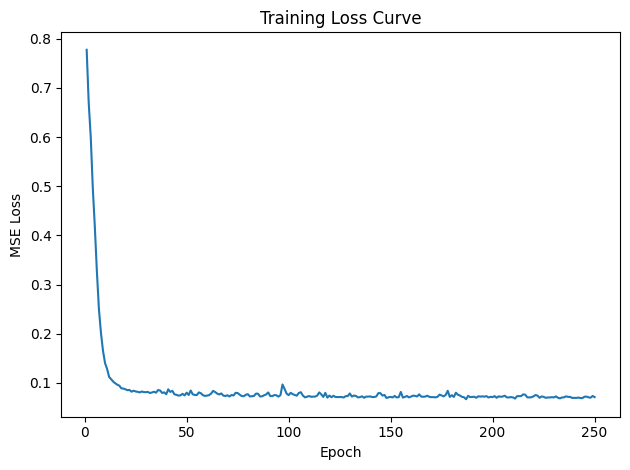

Fold 4 Training R²: 0.9162, Pearson r: 0.9575


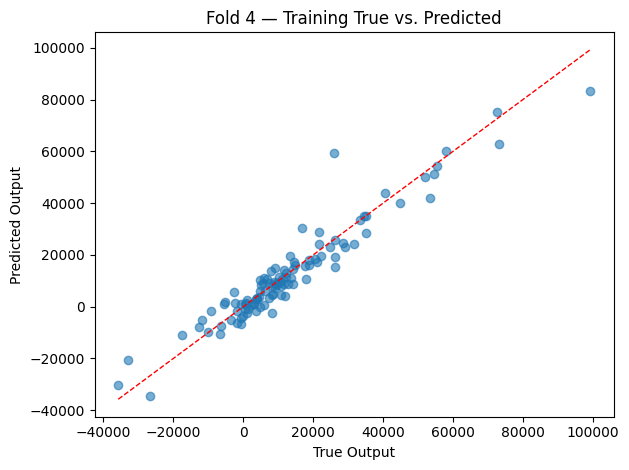

Fold 4 Validation MSE (norm): 1.0867
Fold 4 Validation R²: 0.4997, Pearson r: 0.7182


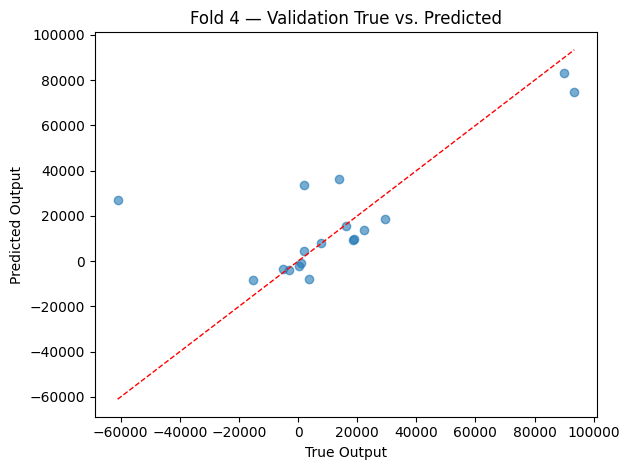


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0779
Epoch  10/250  MSE=0.4345
Epoch  20/250  MSE=0.1634
Epoch  30/250  MSE=0.1400
Epoch  40/250  MSE=0.1179
Epoch  50/250  MSE=0.1126
Epoch  60/250  MSE=0.1037
Epoch  70/250  MSE=0.0974
Epoch  80/250  MSE=0.0982
Epoch  90/250  MSE=0.0940
Epoch 100/250  MSE=0.0901
Epoch 110/250  MSE=0.0887
Epoch 120/250  MSE=0.0879
Epoch 130/250  MSE=0.1062
Epoch 140/250  MSE=0.0899
Epoch 150/250  MSE=0.0828
Epoch 160/250  MSE=0.0839
Epoch 170/250  MSE=0.0845
Epoch 180/250  MSE=0.0874
Epoch 190/250  MSE=0.0814
Epoch 200/250  MSE=0.0837
Epoch 210/250  MSE=0.0847
Epoch 220/250  MSE=0.0798
Epoch 230/250  MSE=0.0793
Epoch 240/250  MSE=0.0798
Epoch 250/250  MSE=0.0855


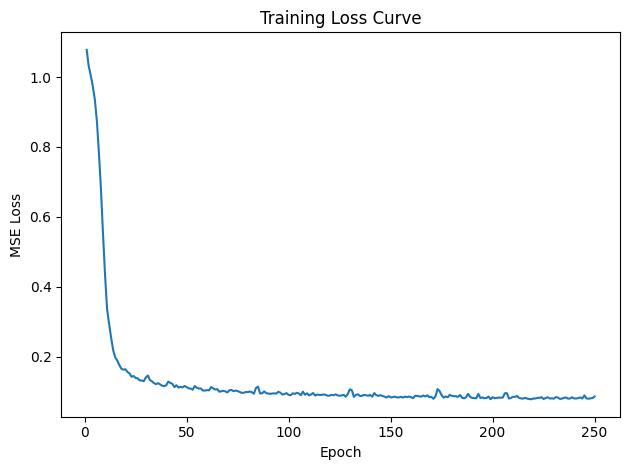

Fold 5 Training R²: 0.9262, Pearson r: 0.9636


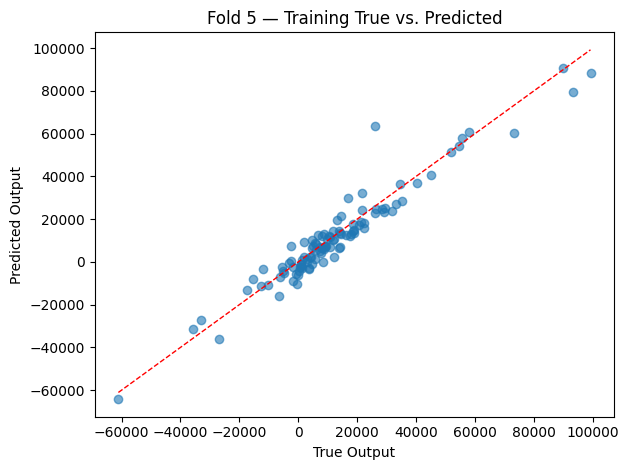

Fold 5 Validation MSE (norm): 0.2224
Fold 5 Validation R²: 0.7167, Pearson r: 0.9210


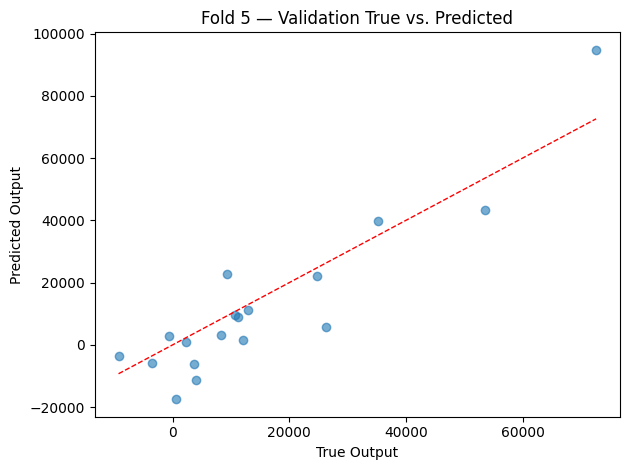


=== Fold 6/7 ===
Epoch   1/250  MSE=1.0986
Epoch  10/250  MSE=0.2549
Epoch  20/250  MSE=0.1091
Epoch  30/250  MSE=0.0856
Epoch  40/250  MSE=0.0815
Epoch  50/250  MSE=0.0773
Epoch  60/250  MSE=0.0753
Epoch  70/250  MSE=0.0774
Epoch  80/250  MSE=0.0752
Epoch  90/250  MSE=0.0780
Epoch 100/250  MSE=0.0762
Epoch 110/250  MSE=0.0733
Epoch 120/250  MSE=0.0707
Epoch 130/250  MSE=0.0778
Epoch 140/250  MSE=0.0731
Epoch 150/250  MSE=0.0740
Epoch 160/250  MSE=0.0710
Epoch 170/250  MSE=0.0707
Epoch 180/250  MSE=0.0686
Epoch 190/250  MSE=0.0667
Epoch 200/250  MSE=0.0728
Epoch 210/250  MSE=0.0702
Epoch 220/250  MSE=0.0727
Epoch 230/250  MSE=0.0668
Epoch 240/250  MSE=0.0671
Epoch 250/250  MSE=0.0697


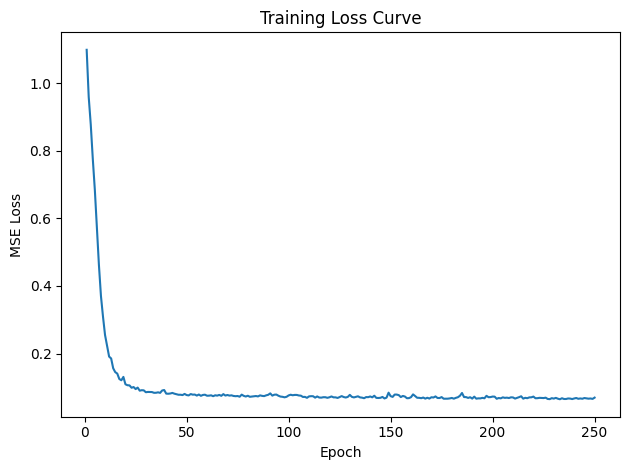

Fold 6 Training R²: 0.9368, Pearson r: 0.9681


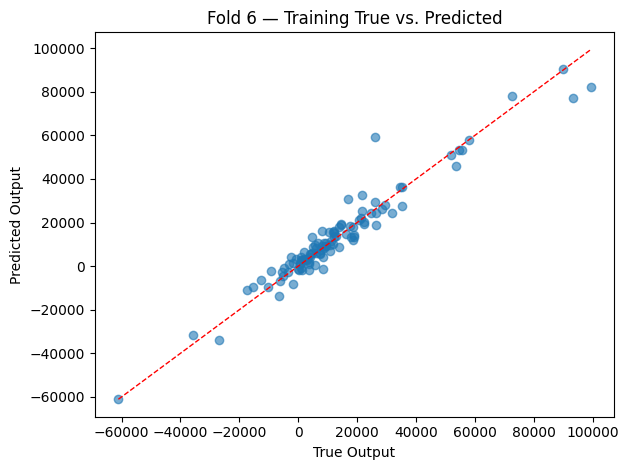

Fold 6 Validation MSE (norm): 1.1451
Fold 6 Validation R²: -0.0715, Pearson r: 0.4825


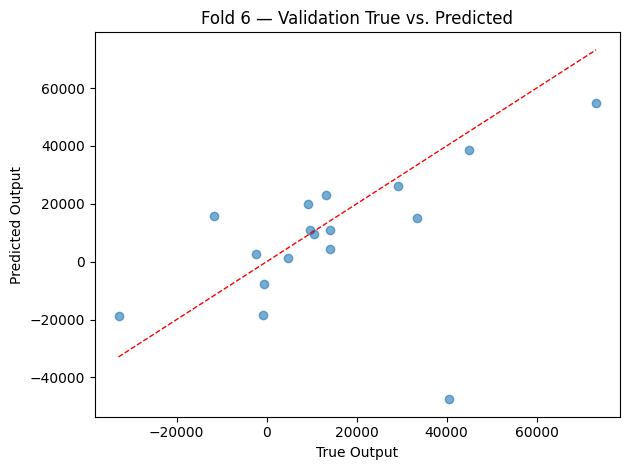


=== Fold 7/7 ===
Epoch   1/250  MSE=1.2033
Epoch  10/250  MSE=0.3356
Epoch  20/250  MSE=0.1548
Epoch  30/250  MSE=0.1292
Epoch  40/250  MSE=0.1194
Epoch  50/250  MSE=0.1058
Epoch  60/250  MSE=0.1053
Epoch  70/250  MSE=0.0937
Epoch  80/250  MSE=0.0924
Epoch  90/250  MSE=0.0948
Epoch 100/250  MSE=0.0931
Epoch 110/250  MSE=0.0873
Epoch 120/250  MSE=0.0884
Epoch 130/250  MSE=0.0856
Epoch 140/250  MSE=0.0859
Epoch 150/250  MSE=0.0828
Epoch 160/250  MSE=0.0938
Epoch 170/250  MSE=0.0798
Epoch 180/250  MSE=0.0815
Epoch 190/250  MSE=0.0761
Epoch 200/250  MSE=0.0814
Epoch 210/250  MSE=0.0806
Epoch 220/250  MSE=0.0771
Epoch 230/250  MSE=0.0773
Epoch 240/250  MSE=0.0774
Epoch 250/250  MSE=0.0878


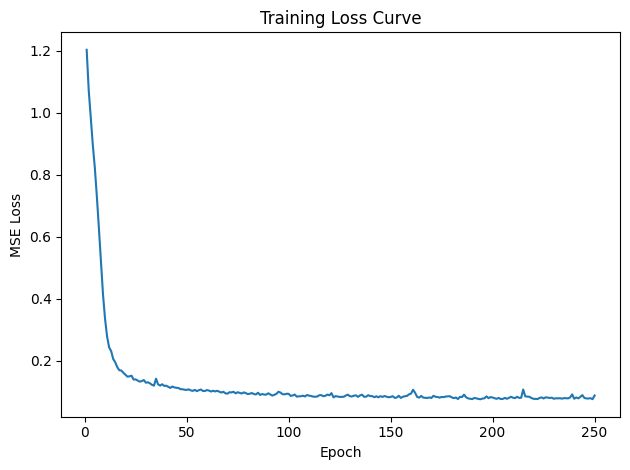

Fold 7 Training R²: 0.9296, Pearson r: 0.9661


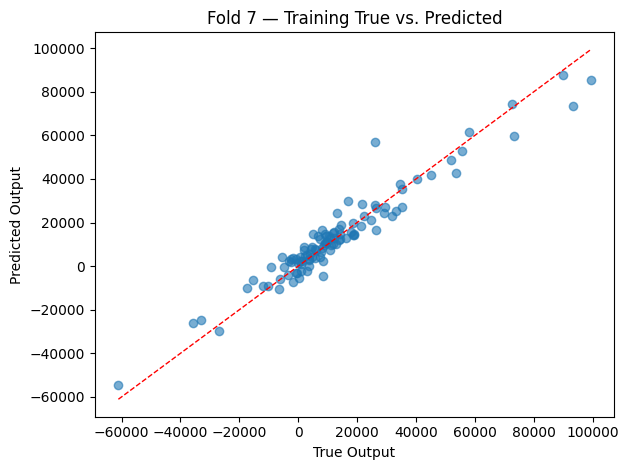

Fold 7 Validation MSE (norm): 0.2710
Fold 7 Validation R²: 0.3541, Pearson r: 0.7043


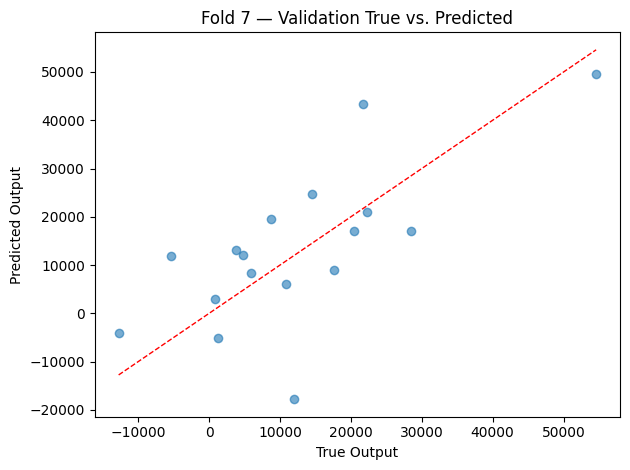


=== Validation MSE per fold ===
['0.1376', '0.1661', '0.3284', '1.0867', '0.2224', '1.1451', '0.2710']
Mean MSE (norm): 0.4796 ± 0.4069

=== Validation R² per fold ===
['0.3120', '0.8801', '0.5469', '0.4997', '0.7167', '-0.0715', '0.3541']
Mean R²: 0.4626 ± 0.2846

=== Validation Pearson r per fold ===
['0.7072', '0.9421', '0.9114', '0.7182', '0.9210', '0.4825', '0.7043']
Mean Pearson r: 0.7695 ± 0.1540


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [40]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [8,8],
    'activation':  'linear',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [16,8,4] linear 


=== Fold 1/7 ===
Epoch   1/250  MSE=1.1805


Epoch  10/250  MSE=0.2379
Epoch  20/250  MSE=0.1345
Epoch  30/250  MSE=0.1216
Epoch  40/250  MSE=0.1117
Epoch  50/250  MSE=0.1018
Epoch  60/250  MSE=0.1199
Epoch  70/250  MSE=0.0941
Epoch  80/250  MSE=0.0998
Epoch  90/250  MSE=0.0890
Epoch 100/250  MSE=0.0879
Epoch 110/250  MSE=0.0877
Epoch 120/250  MSE=0.0891
Epoch 130/250  MSE=0.0848
Epoch 140/250  MSE=0.0813
Epoch 150/250  MSE=0.0902
Epoch 160/250  MSE=0.0915
Epoch 170/250  MSE=0.0803
Epoch 180/250  MSE=0.0826
Epoch 190/250  MSE=0.0796
Epoch 200/250  MSE=0.0869
Epoch 210/250  MSE=0.0837
Epoch 220/250  MSE=0.0832
Epoch 230/250  MSE=0.0799
Epoch 240/250  MSE=0.0804
Epoch 250/250  MSE=0.0819


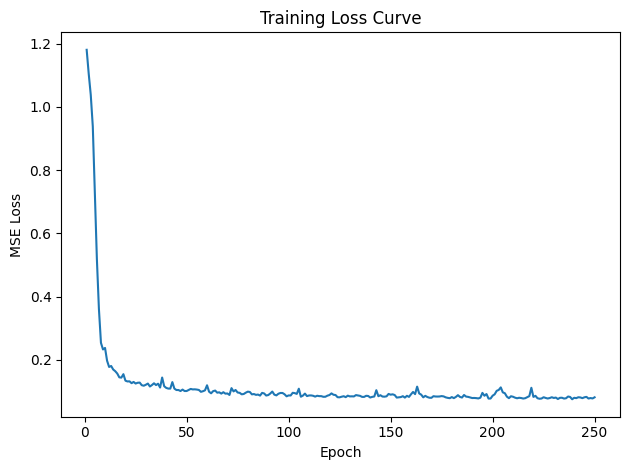

Fold 1 Training R²: 0.9356, Pearson r: 0.9674


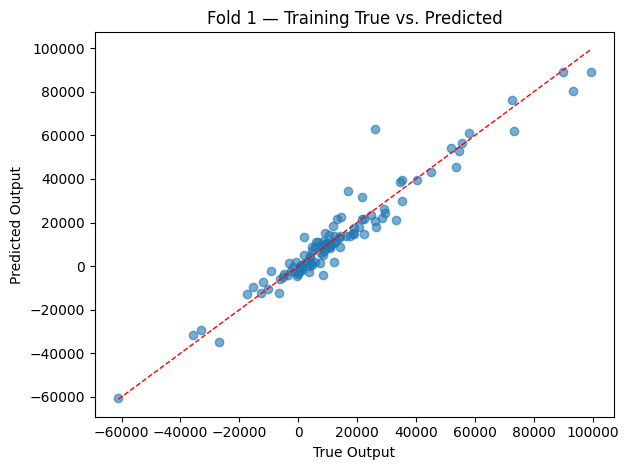

Fold 1 Validation MSE (norm): 0.1478
Fold 1 Validation R²: 0.2608, Pearson r: 0.7121


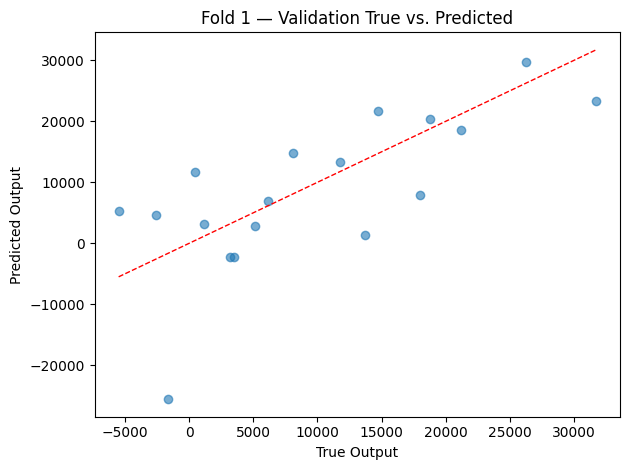


=== Fold 2/7 ===
Epoch   1/250  MSE=1.0638
Epoch  10/250  MSE=0.2024
Epoch  20/250  MSE=0.1397
Epoch  30/250  MSE=0.1173
Epoch  40/250  MSE=0.1112
Epoch  50/250  MSE=0.1098
Epoch  60/250  MSE=0.1031
Epoch  70/250  MSE=0.0920
Epoch  80/250  MSE=0.0968
Epoch  90/250  MSE=0.0950
Epoch 100/250  MSE=0.0859
Epoch 110/250  MSE=0.0858
Epoch 120/250  MSE=0.0820
Epoch 130/250  MSE=0.0818
Epoch 140/250  MSE=0.0813
Epoch 150/250  MSE=0.0842
Epoch 160/250  MSE=0.0877
Epoch 170/250  MSE=0.0769
Epoch 180/250  MSE=0.0761
Epoch 190/250  MSE=0.0780
Epoch 200/250  MSE=0.0755
Epoch 210/250  MSE=0.0749
Epoch 220/250  MSE=0.0782
Epoch 230/250  MSE=0.0790
Epoch 240/250  MSE=0.0755
Epoch 250/250  MSE=0.0794


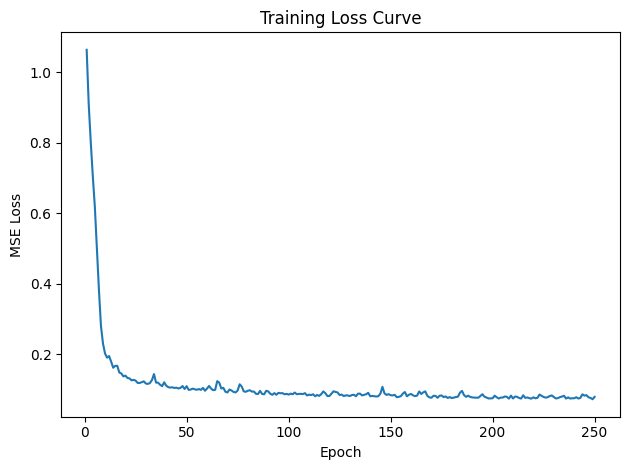

Fold 2 Training R²: 0.9205, Pearson r: 0.9615


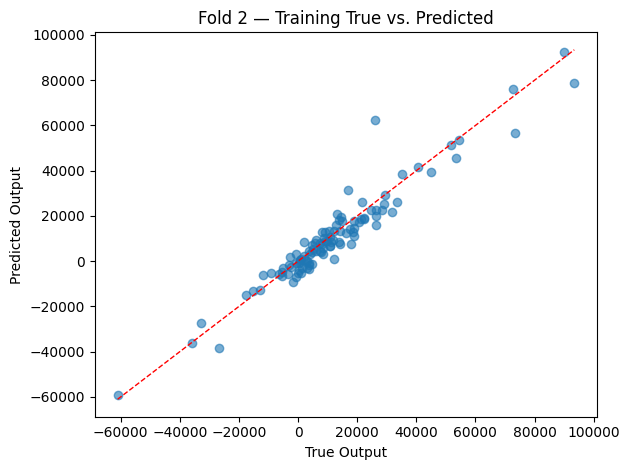

Fold 2 Validation MSE (norm): 0.1870
Fold 2 Validation R²: 0.8650, Pearson r: 0.9376


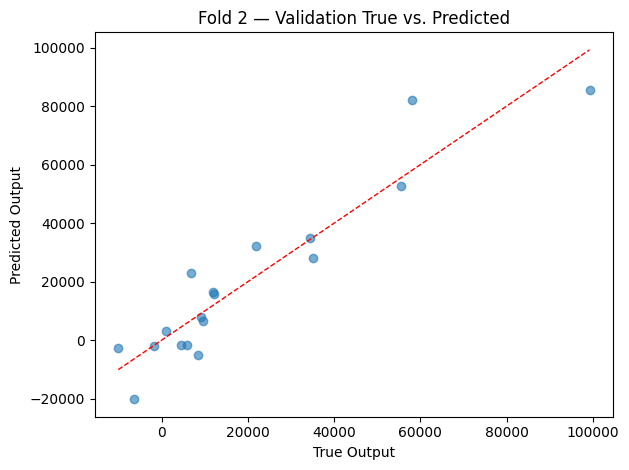


=== Fold 3/7 ===
Epoch   1/250  MSE=1.2232
Epoch  10/250  MSE=0.1740
Epoch  20/250  MSE=0.1093
Epoch  30/250  MSE=0.0870
Epoch  40/250  MSE=0.0718
Epoch  50/250  MSE=0.0698
Epoch  60/250  MSE=0.0652
Epoch  70/250  MSE=0.0616
Epoch  80/250  MSE=0.0553
Epoch  90/250  MSE=0.0660
Epoch 100/250  MSE=0.0563
Epoch 110/250  MSE=0.0614
Epoch 120/250  MSE=0.0654
Epoch 130/250  MSE=0.0602
Epoch 140/250  MSE=0.0506
Epoch 150/250  MSE=0.0553
Epoch 160/250  MSE=0.0551
Epoch 170/250  MSE=0.0578
Epoch 180/250  MSE=0.0552
Epoch 190/250  MSE=0.0536
Epoch 200/250  MSE=0.0584
Epoch 210/250  MSE=0.0534
Epoch 220/250  MSE=0.0515
Epoch 230/250  MSE=0.0528
Epoch 240/250  MSE=0.0498
Epoch 250/250  MSE=0.0596


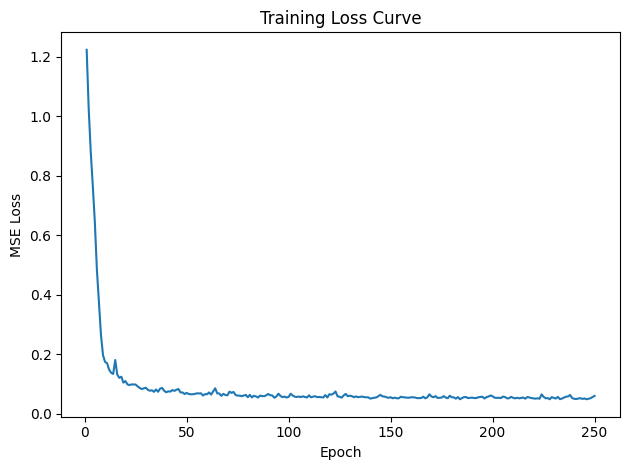

Fold 3 Training R²: 0.9514, Pearson r: 0.9762


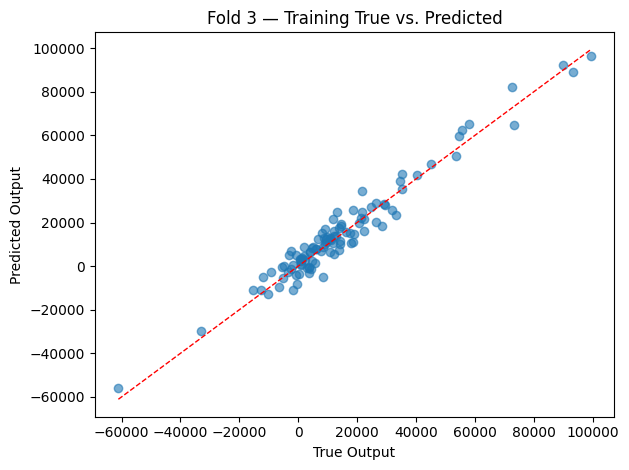

Fold 3 Validation MSE (norm): 0.3529
Fold 3 Validation R²: 0.5131, Pearson r: 0.9152


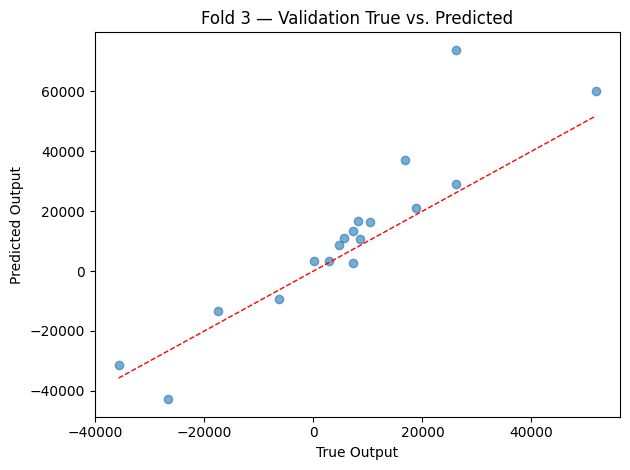


=== Fold 4/7 ===
Epoch   1/250  MSE=1.0201
Epoch  10/250  MSE=0.1287
Epoch  20/250  MSE=0.0870
Epoch  30/250  MSE=0.0792
Epoch  40/250  MSE=0.0831
Epoch  50/250  MSE=0.0747
Epoch  60/250  MSE=0.0765
Epoch  70/250  MSE=0.0809
Epoch  80/250  MSE=0.0772
Epoch  90/250  MSE=0.0789
Epoch 100/250  MSE=0.0786
Epoch 110/250  MSE=0.0768
Epoch 120/250  MSE=0.0722
Epoch 130/250  MSE=0.0729
Epoch 140/250  MSE=0.0713
Epoch 150/250  MSE=0.0713
Epoch 160/250  MSE=0.0734
Epoch 170/250  MSE=0.0754
Epoch 180/250  MSE=0.0735
Epoch 190/250  MSE=0.0707
Epoch 200/250  MSE=0.0791
Epoch 210/250  MSE=0.0694
Epoch 220/250  MSE=0.0762
Epoch 230/250  MSE=0.0726
Epoch 240/250  MSE=0.0697
Epoch 250/250  MSE=0.0728


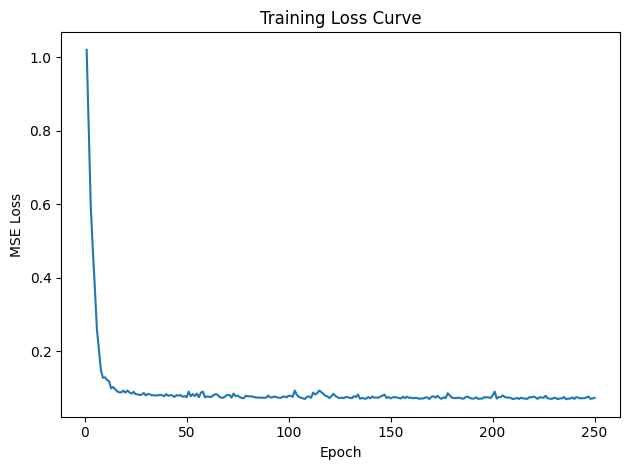

Fold 4 Training R²: 0.9175, Pearson r: 0.9580


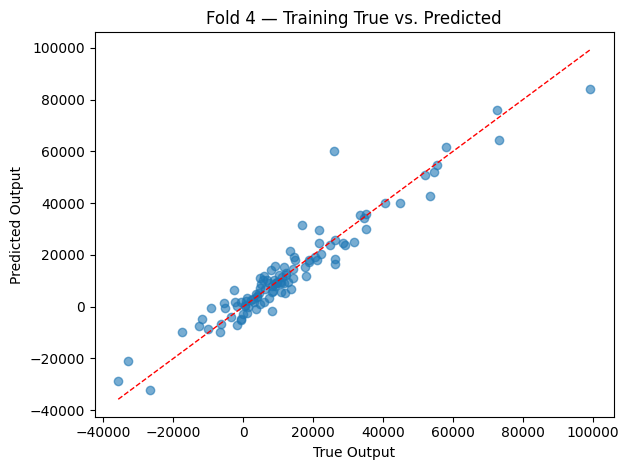

Fold 4 Validation MSE (norm): 1.0825
Fold 4 Validation R²: 0.5017, Pearson r: 0.7235


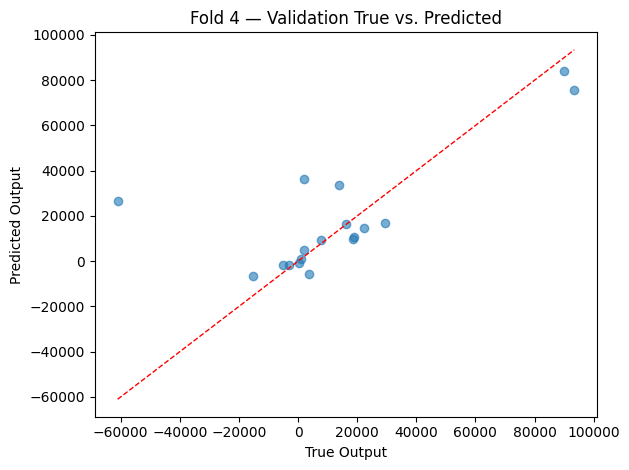


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0276
Epoch  10/250  MSE=0.1680
Epoch  20/250  MSE=0.1463
Epoch  30/250  MSE=0.1330
Epoch  40/250  MSE=0.1133
Epoch  50/250  MSE=0.1091
Epoch  60/250  MSE=0.1087
Epoch  70/250  MSE=0.1148
Epoch  80/250  MSE=0.0962
Epoch  90/250  MSE=0.0957
Epoch 100/250  MSE=0.0871
Epoch 110/250  MSE=0.0929
Epoch 120/250  MSE=0.0929
Epoch 130/250  MSE=0.0869
Epoch 140/250  MSE=0.0910
Epoch 150/250  MSE=0.0820
Epoch 160/250  MSE=0.0822
Epoch 170/250  MSE=0.0971
Epoch 180/250  MSE=0.0827
Epoch 190/250  MSE=0.0818
Epoch 200/250  MSE=0.0843
Epoch 210/250  MSE=0.0846
Epoch 220/250  MSE=0.0849
Epoch 230/250  MSE=0.0912
Epoch 240/250  MSE=0.0832
Epoch 250/250  MSE=0.0816


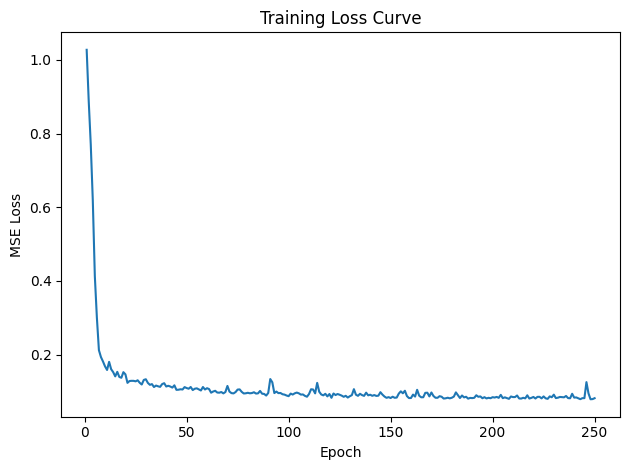

Fold 5 Training R²: 0.9276, Pearson r: 0.9632


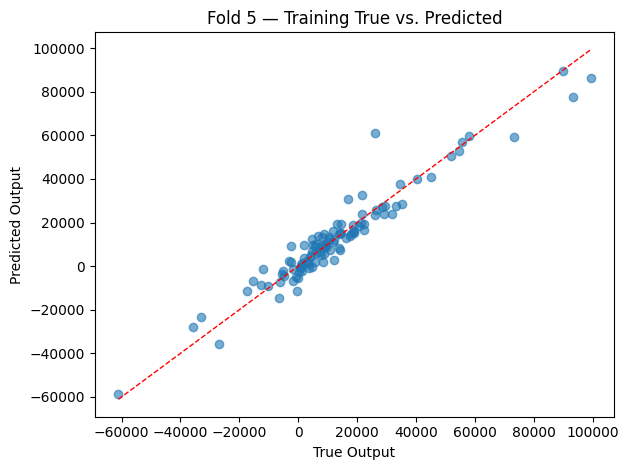

Fold 5 Validation MSE (norm): 0.2077
Fold 5 Validation R²: 0.7355, Pearson r: 0.9169


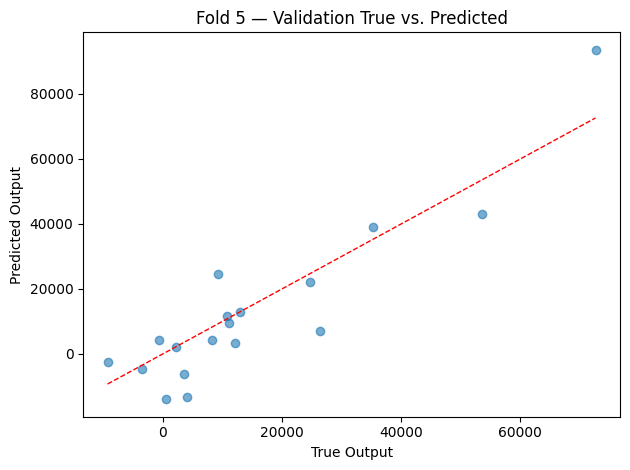


=== Fold 6/7 ===
Epoch   1/250  MSE=0.9928
Epoch  10/250  MSE=0.1579
Epoch  20/250  MSE=0.1044
Epoch  30/250  MSE=0.0837
Epoch  40/250  MSE=0.0817
Epoch  50/250  MSE=0.0772
Epoch  60/250  MSE=0.0865
Epoch  70/250  MSE=0.0726
Epoch  80/250  MSE=0.0774
Epoch  90/250  MSE=0.0782
Epoch 100/250  MSE=0.0935
Epoch 110/250  MSE=0.0780
Epoch 120/250  MSE=0.0707
Epoch 130/250  MSE=0.0695
Epoch 140/250  MSE=0.0680
Epoch 150/250  MSE=0.0737
Epoch 160/250  MSE=0.0696
Epoch 170/250  MSE=0.0743
Epoch 180/250  MSE=0.0716
Epoch 190/250  MSE=0.0680
Epoch 200/250  MSE=0.0683
Epoch 210/250  MSE=0.0690
Epoch 220/250  MSE=0.0708
Epoch 230/250  MSE=0.0696
Epoch 240/250  MSE=0.0707
Epoch 250/250  MSE=0.0727


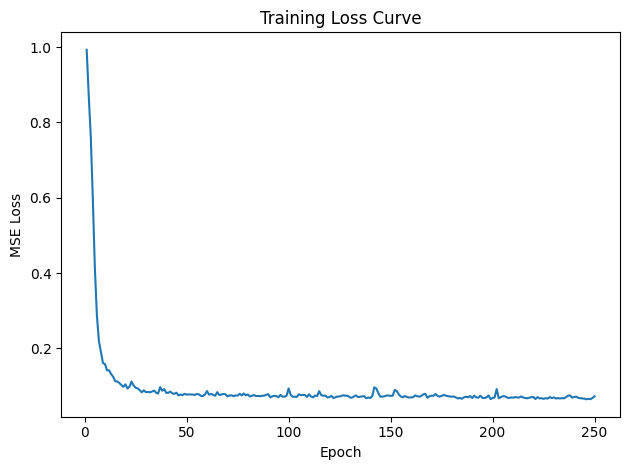

Fold 6 Training R²: 0.9359, Pearson r: 0.9682


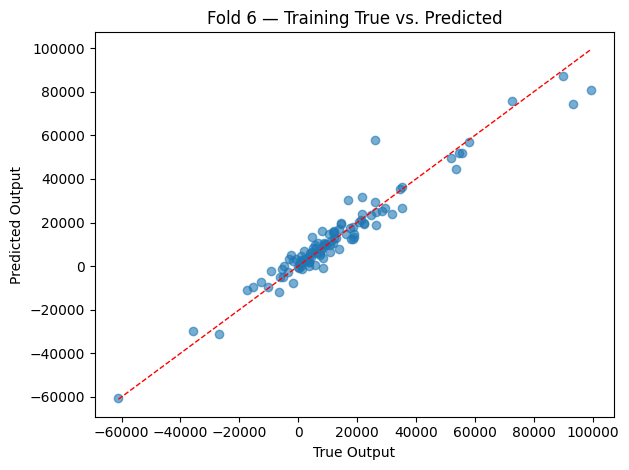

Fold 6 Validation MSE (norm): 1.0956
Fold 6 Validation R²: -0.0252, Pearson r: 0.4885


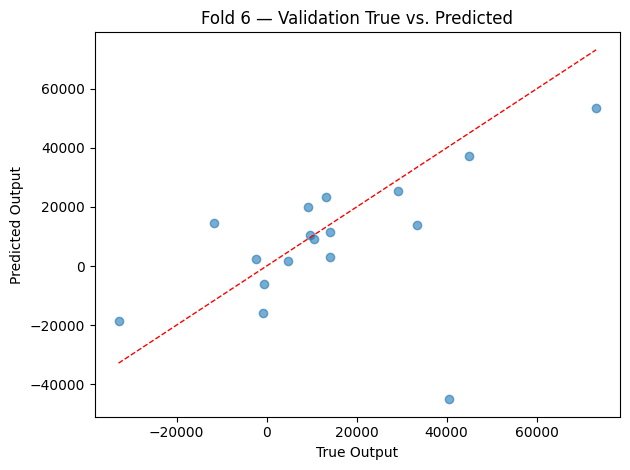


=== Fold 7/7 ===
Epoch   1/250  MSE=1.0997
Epoch  10/250  MSE=0.2067
Epoch  20/250  MSE=0.1395
Epoch  30/250  MSE=0.1211
Epoch  40/250  MSE=0.1133
Epoch  50/250  MSE=0.1271
Epoch  60/250  MSE=0.1018
Epoch  70/250  MSE=0.0943
Epoch  80/250  MSE=0.0922
Epoch  90/250  MSE=0.0840
Epoch 100/250  MSE=0.0927
Epoch 110/250  MSE=0.0790
Epoch 120/250  MSE=0.0901
Epoch 130/250  MSE=0.0857
Epoch 140/250  MSE=0.0826
Epoch 150/250  MSE=0.0849
Epoch 160/250  MSE=0.0784
Epoch 170/250  MSE=0.0761
Epoch 180/250  MSE=0.0809
Epoch 190/250  MSE=0.0810
Epoch 200/250  MSE=0.0828
Epoch 210/250  MSE=0.0882
Epoch 220/250  MSE=0.0807
Epoch 230/250  MSE=0.0966
Epoch 240/250  MSE=0.0889
Epoch 250/250  MSE=0.0805


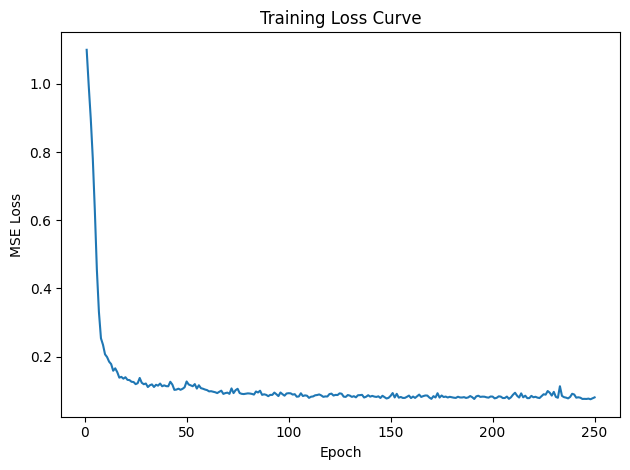

Fold 7 Training R²: 0.9315, Pearson r: 0.9669


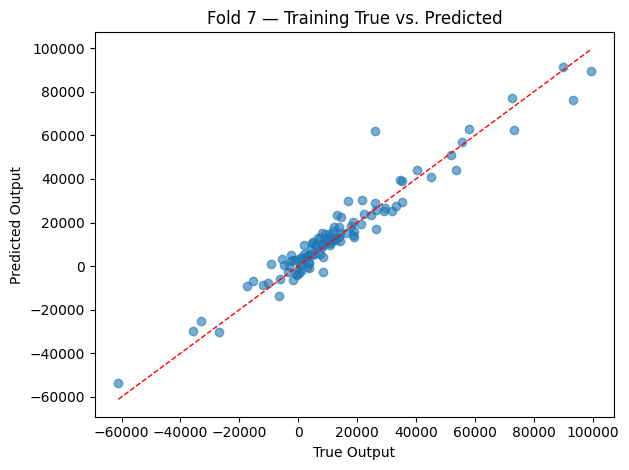

Fold 7 Validation MSE (norm): 0.2398
Fold 7 Validation R²: 0.4284, Pearson r: 0.7459


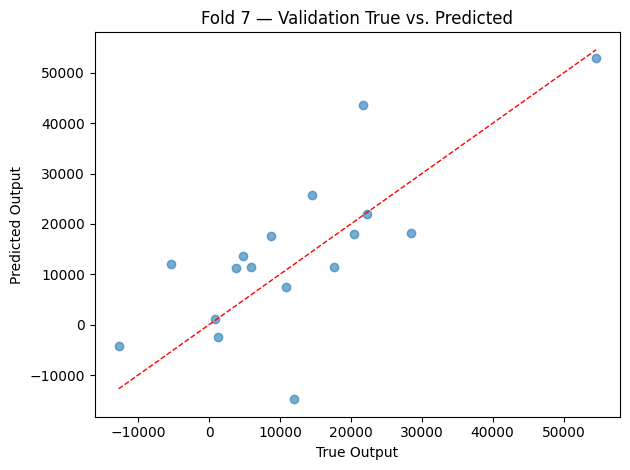


=== Validation MSE per fold ===
['0.1478', '0.1870', '0.3529', '1.0825', '0.2077', '1.0956', '0.2398']
Mean MSE (norm): 0.4733 ± 0.3939

=== Validation R² per fold ===
['0.2608', '0.8650', '0.5131', '0.5017', '0.7355', '-0.0252', '0.4284']
Mean R²: 0.4685 ± 0.2726

=== Validation Pearson r per fold ===
['0.7121', '0.9376', '0.9152', '0.7235', '0.9169', '0.4885', '0.7459']
Mean Pearson r: 0.7771 ± 0.1492


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [41]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [16,8,4],
    'activation':  'linear',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# singel run to save  [3, 3] ReLU

Epoch   1/250  MSE=0.9601


Epoch  10/250  MSE=0.7806
Epoch  20/250  MSE=0.6348
Epoch  30/250  MSE=0.5090
Epoch  40/250  MSE=0.4287
Epoch  50/250  MSE=0.3701
Epoch  60/250  MSE=0.3292
Epoch  70/250  MSE=0.2890
Epoch  80/250  MSE=0.2641
Epoch  90/250  MSE=0.2279
Epoch 100/250  MSE=0.1915
Epoch 110/250  MSE=0.1709
Epoch 120/250  MSE=0.1560
Epoch 130/250  MSE=0.1402
Epoch 140/250  MSE=0.1317
Epoch 150/250  MSE=0.1223
Epoch 160/250  MSE=0.1129
Epoch 170/250  MSE=0.1083
Epoch 180/250  MSE=0.1043
Epoch 190/250  MSE=0.1004
Epoch 200/250  MSE=0.0967
Epoch 210/250  MSE=0.0908
Epoch 220/250  MSE=0.0876
Epoch 230/250  MSE=0.0862
Epoch 240/250  MSE=0.0823
Epoch 250/250  MSE=0.0852


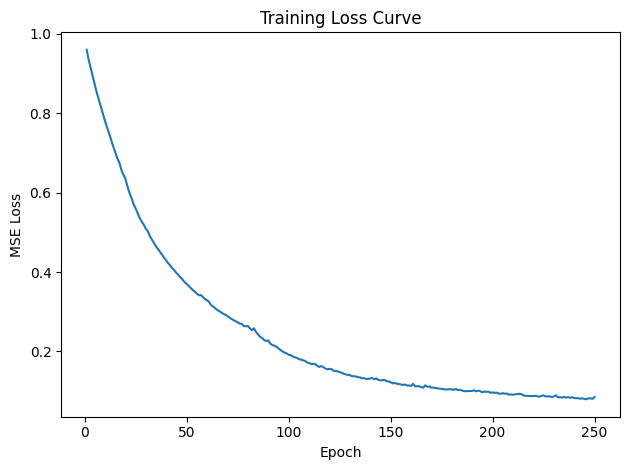

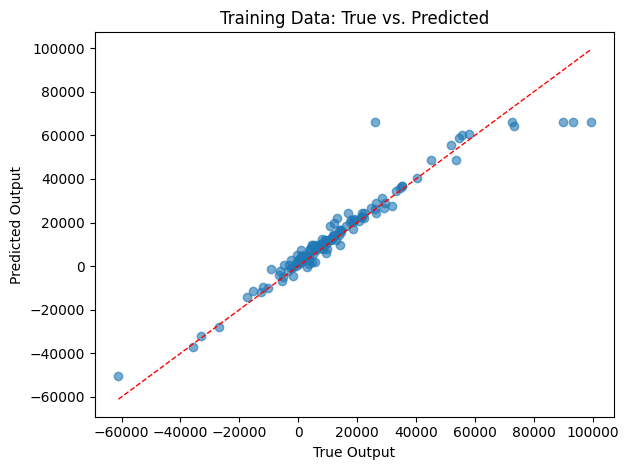

Saved model to:  trained_model_4aab1066.pt
Saved params to: trained_model_4aab1066_params.txt


In [ ]:
import uuid
import torch
from Plot_helper import plot_train_scatter

# 1) Generate a random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [3, 3],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Train your model
model, losses = train_nn(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size']
)

# 4) Plot true vs. predicted
plot_train_scatter(model, X, y, scaler_y=scaler_y, device='cpu')

# 5) Construct filenames with tag
model_fp  = f"trained_model_{tag}.pt"
params_fp = f"trained_model_{tag}_params.txt"

# 6) Save the model weights
torch.save(model.state_dict(), model_fp)

# 7) Save the hyper-parameters
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")

print(f"Saved model to:  {model_fp}")
print(f"Saved params to: {params_fp}")


# [8,8] Relu

Epoch   1/250  MSE=1.2705
Epoch  10/250  MSE=0.9223
Epoch  20/250  MSE=0.4401
Epoch  30/250  MSE=0.1648
Epoch  40/250  MSE=0.1154
Epoch  50/250  MSE=0.0886
Epoch  60/250  MSE=0.0740
Epoch  70/250  MSE=0.0643
Epoch  80/250  MSE=0.0565
Epoch  90/250  MSE=0.0532
Epoch 100/250  MSE=0.0490
Epoch 110/250  MSE=0.0480
Epoch 120/250  MSE=0.0472
Epoch 130/250  MSE=0.0424
Epoch 140/250  MSE=0.0413
Epoch 150/250  MSE=0.0405
Epoch 160/250  MSE=0.0429
Epoch 170/250  MSE=0.0384
Epoch 180/250  MSE=0.0364
Epoch 190/250  MSE=0.0364
Epoch 200/250  MSE=0.0363
Epoch 210/250  MSE=0.0350
Epoch 220/250  MSE=0.0333
Epoch 230/250  MSE=0.0338
Epoch 240/250  MSE=0.0359
Epoch 250/250  MSE=0.0323


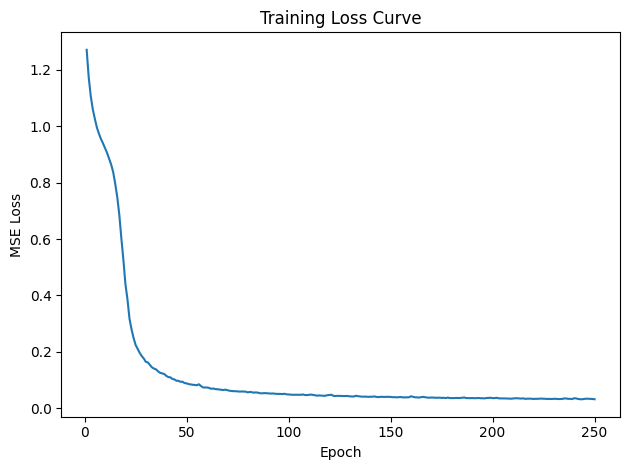

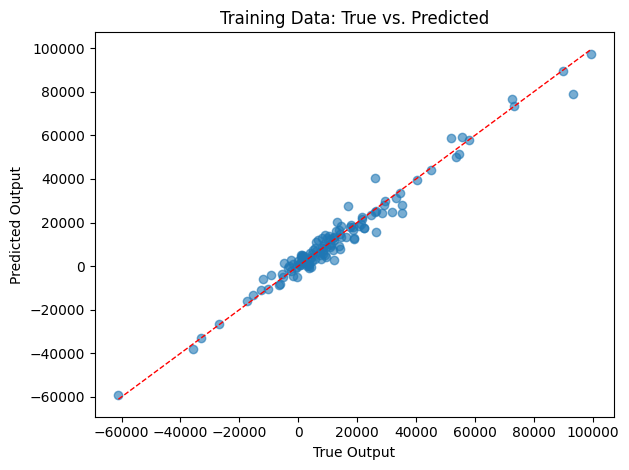

Saved model to:  trained_model_a98375b5.pt
Saved params to: trained_model_a98375b5_params.txt


In [56]:
import uuid
import torch
from Plot_helper import plot_train_scatter

# 1) Generate a random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [2, 2],
    'activation':  'Softplus',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Train your model
model, losses = train_nn(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size']
)

# 4) Plot true vs. predicted
plot_train_scatter(model, X, y, scaler_y=scaler_y, device='cpu')

# 5) Construct filenames with tag
model_fp  = f"trained_model_{tag}.pt"
params_fp = f"trained_model_{tag}_params.txt"

# 6) Save the model weights
torch.save(model.state_dict(), model_fp)

# 7) Save the hyper-parameters
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")

print(f"Saved model to:  {model_fp}")
print(f"Saved params to: {params_fp}")
